In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/RADIOLOGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=71.3, y0=109.5, x1=79.7, y1=121.6
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 63
Page 1, Q1, A: Yellow percentage: 0.0%


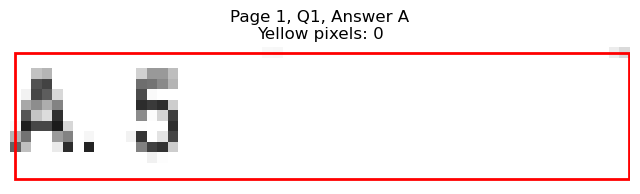

Page 1, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=88.7, y1=133.6
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 54
Page 1, Q1, B: Yellow percentage: 0.0%


Page 1, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=89.5, y1=145.6
Page 1, Q1, C: Yellow pixels: 144
Page 1, Q1, C: Total non-white pixels: 221
Page 1, Q1, C: Yellow percentage: 65.2%


Page 1, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=341.0, y1=121.6
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 64
Page 1, Q1, D: Yellow percentage: 0.0%


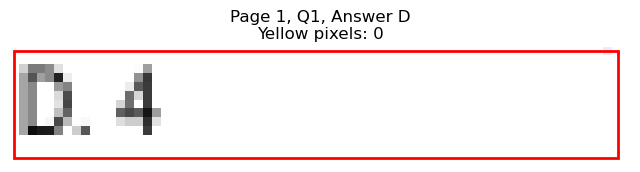

Page 1, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=340.3, y1=133.6
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 69
Page 1, Q1, E: Yellow percentage: 0.0%


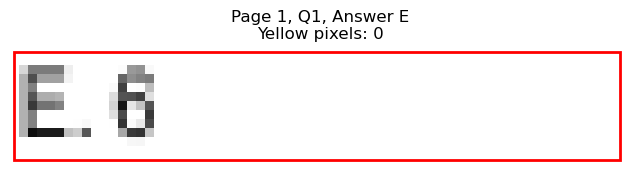


Page 1, Q1 - Selected Answer: C (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=97.0, y1=193.6
Page 1, Q2, A: Yellow pixels: 96
Page 1, Q2, A: Total non-white pixels: 169
Page 1, Q2, A: Yellow percentage: 56.8%


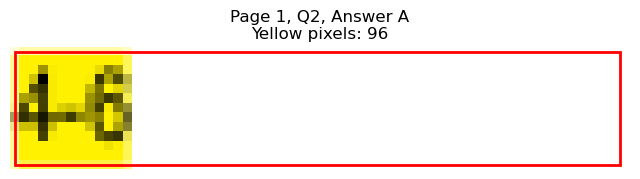

Page 1, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=100.8, y1=205.6
Page 1, Q2, B: Yellow pixels: 12
Page 1, Q2, B: Total non-white pixels: 140
Page 1, Q2, B: Yellow percentage: 8.6%


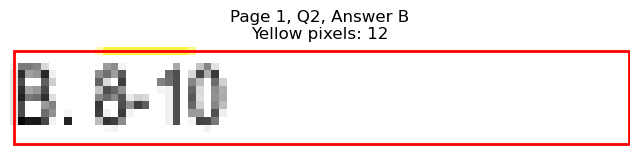

Page 1, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=106.0, y1=217.7
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 119
Page 1, Q2, C: Yellow percentage: 0.0%


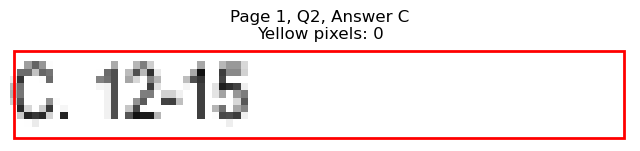

Page 1, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=350.8, y1=193.6
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 90
Page 1, Q2, D: Yellow percentage: 0.0%


Page 1, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=347.8, y1=205.6
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 97
Page 1, Q2, E: Yellow percentage: 0.0%



Page 1, Q2 - Selected Answer: A (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=177.2, y1=253.7
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 465
Page 1, Q3, A: Yellow percentage: 0.0%


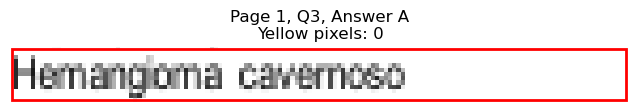

Page 1, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=152.6, y1=265.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 378
Page 1, Q3, B: Yellow percentage: 0.0%


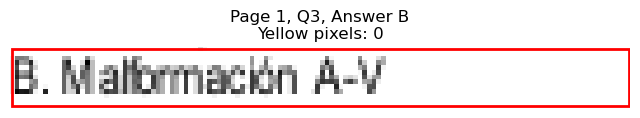

Page 1, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=125.5, y1=277.7
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 240
Page 1, Q3, C: Yellow percentage: 0.0%


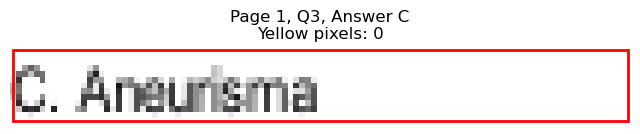

Page 1, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=399.6, y1=253.7
Page 1, Q3, D: Yellow pixels: 589
Page 1, Q3, D: Total non-white pixels: 990
Page 1, Q3, D: Yellow percentage: 59.5%


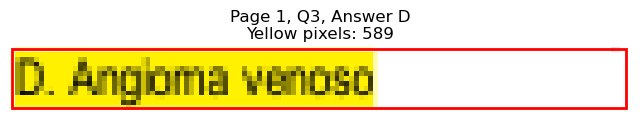

Page 1, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=375.5, y1=265.7
Page 1, Q3, E: Yellow pixels: 74
Page 1, Q3, E: Total non-white pixels: 316
Page 1, Q3, E: Yellow percentage: 23.4%


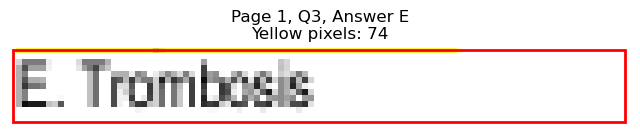


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=145.7, y1=314.5
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 335
Page 1, Q4, A: Yellow percentage: 0.0%


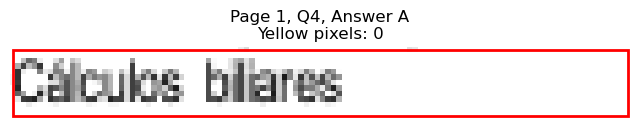

Page 1, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=214.0, y1=326.5
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 692
Page 1, Q4, B: Yellow percentage: 0.0%


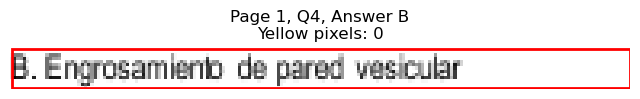

Page 1, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=160.0, y1=338.5
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 411
Page 1, Q4, C: Yellow percentage: 0.0%


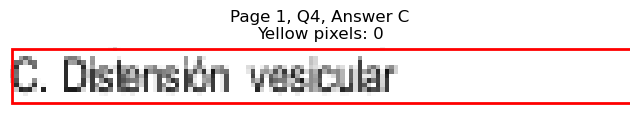

Page 1, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=404.8, y1=314.5
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 412
Page 1, Q4, D: Yellow percentage: 0.0%


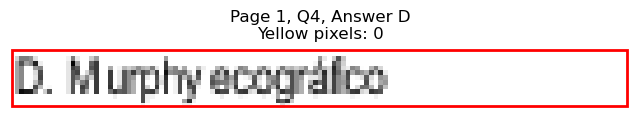

Page 1, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=423.7, y1=326.5
Page 1, Q4, E: Yellow pixels: 893
Page 1, Q4, E: Total non-white pixels: 1300
Page 1, Q4, E: Yellow percentage: 68.7%


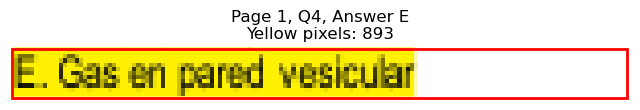


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=130.0, y1=386.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 414
Page 1, Q5, A: Yellow percentage: 0.0%


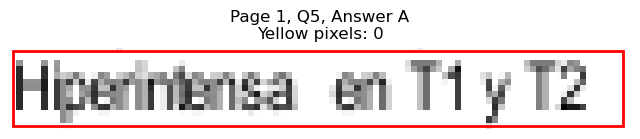

Page 1, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=126.2, y1=398.6
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 449
Page 1, Q5, B: Yellow percentage: 0.0%


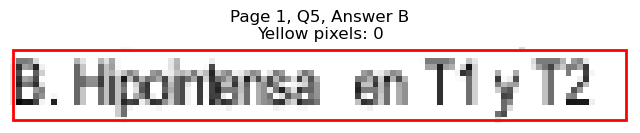

Page 1, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=200.5, y1=410.6
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 684
Page 1, Q5, C: Yellow percentage: 0.0%


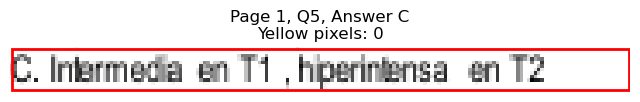

Page 1, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=446.8, y1=386.6
Page 1, Q5, D: Yellow pixels: 1364
Page 1, Q5, D: Total non-white pixels: 1963
Page 1, Q5, D: Yellow percentage: 69.5%


Page 1, Q5 - E: Detected box: x0=381.4, y0=386.5, x1=458.8, y1=398.6
Page 1, Q5, E: Yellow pixels: 91
Page 1, Q5, E: Total non-white pixels: 565
Page 1, Q5, E: Yellow percentage: 16.1%



Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=82.6, y0=446.6, x1=218.7, y1=458.6
Page 1, Q6, A: Yellow pixels: 1131
Page 1, Q6, A: Total non-white pixels: 1755
Page 1, Q6, A: Yellow percentage: 64.4%


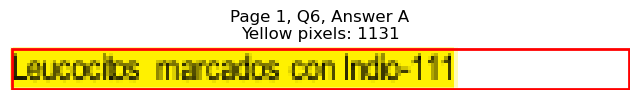

Page 1, Q6 - B: Detected box: x0=71.3, y0=458.6, x1=137.5, y1=470.6
Page 1, Q6, B: Yellow pixels: 105
Page 1, Q6, B: Total non-white pixels: 419
Page 1, Q6, B: Yellow percentage: 25.1%


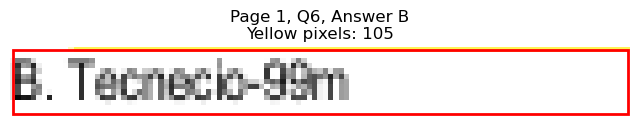

Page 1, Q6 - C: Detected box: x0=71.3, y0=470.6, x1=121.0, y1=482.6
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 207
Page 1, Q6, C: Yellow percentage: 0.0%


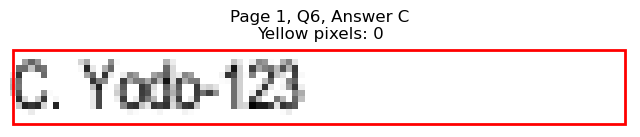

Page 1, Q6 - D: Detected box: x0=322.9, y0=446.6, x1=354.5, y1=458.6
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 134
Page 1, Q6, D: Yellow percentage: 0.0%


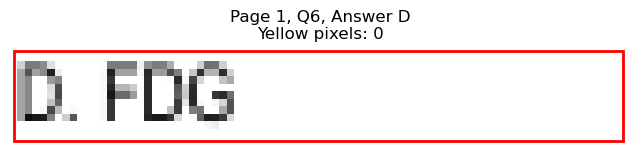

Page 1, Q6 - E: Detected box: x0=322.9, y0=458.6, x1=369.6, y1=470.6
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 210
Page 1, Q6, E: Yellow percentage: 0.0%


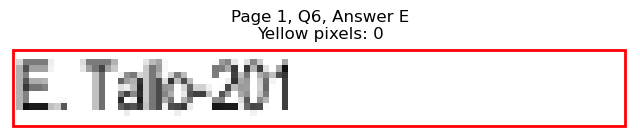


Page 1, Q6 - Selected Answer: A (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=82.6, y0=507.4, x1=136.8, y1=519.4
Page 1, Q7, A: Yellow pixels: 439
Page 1, Q7, A: Total non-white pixels: 689
Page 1, Q7, A: Yellow percentage: 63.7%


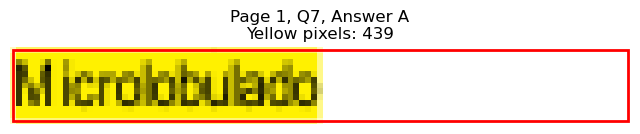

Page 1, Q7 - B: Detected box: x0=71.3, y0=519.4, x1=127.7, y1=531.4
Page 1, Q7, B: Yellow pixels: 51
Page 1, Q7, B: Total non-white pixels: 327
Page 1, Q7, B: Yellow percentage: 15.6%


Page 1, Q7 - C: Detected box: x0=71.3, y0=531.4, x1=127.7, y1=543.5
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 257
Page 1, Q7, C: Yellow percentage: 0.0%


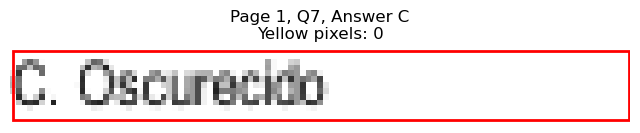

Page 1, Q7 - D: Detected box: x0=322.9, y0=507.4, x1=370.3, y1=519.4
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 232
Page 1, Q7, D: Yellow percentage: 0.0%


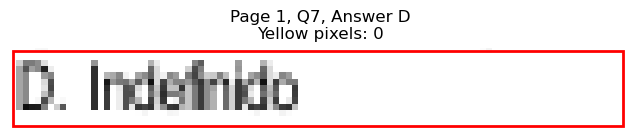

Page 1, Q7 - E: Detected box: x0=322.9, y0=519.4, x1=376.3, y1=531.4
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 262
Page 1, Q7, E: Yellow percentage: 0.0%


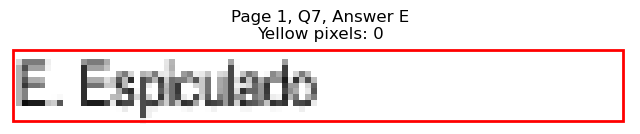


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=82.6, y0=567.5, x1=128.5, y1=579.5
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 239
Page 1, Q8, A: Yellow percentage: 0.0%


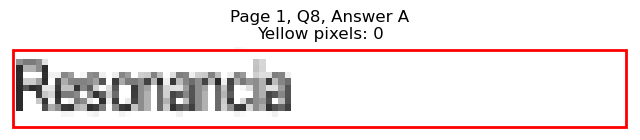

Page 1, Q8 - B: Detected box: x0=71.3, y0=579.4, x1=148.0, y1=591.5
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 373
Page 1, Q8, B: Yellow percentage: 0.0%


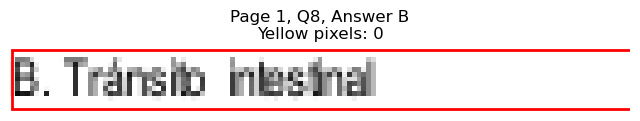

Page 1, Q8 - C: Detected box: x0=71.3, y0=591.5, x1=173.5, y1=603.5
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 467
Page 1, Q8, C: Yellow percentage: 0.0%


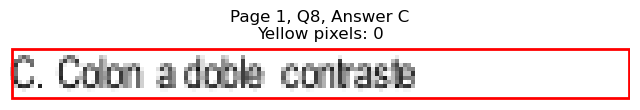

Page 1, Q8 - D: Detected box: x0=322.9, y0=567.5, x1=377.9, y1=579.5
Page 1, Q8, D: Yellow pixels: 464
Page 1, Q8, D: Total non-white pixels: 702
Page 1, Q8, D: Yellow percentage: 66.1%


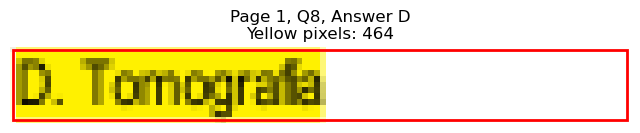

Page 1, Q8 - E: Detected box: x0=322.9, y0=579.4, x1=386.0, y1=591.5
Page 1, Q8, E: Yellow pixels: 52
Page 1, Q8, E: Total non-white pixels: 374
Page 1, Q8, E: Yellow percentage: 13.9%


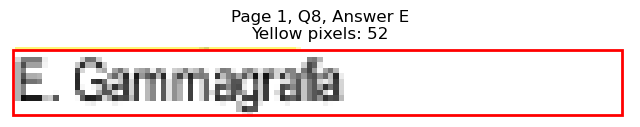


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=82.6, y0=651.5, x1=136.8, y1=663.6
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 313
Page 1, Q9, A: Yellow percentage: 0.0%


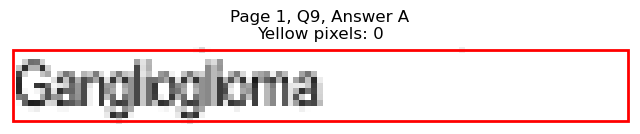

Page 1, Q9 - B: Detected box: x0=71.3, y0=663.5, x1=133.7, y1=675.6
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 311
Page 1, Q9, B: Yellow percentage: 0.0%


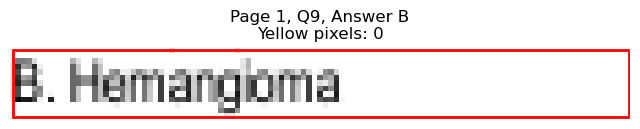

Page 1, Q9 - C: Detected box: x0=71.3, y0=676.3, x1=134.6, y1=688.3
Page 1, Q9, C: Yellow pixels: 502
Page 1, Q9, C: Total non-white pixels: 806
Page 1, Q9, C: Yellow percentage: 62.3%


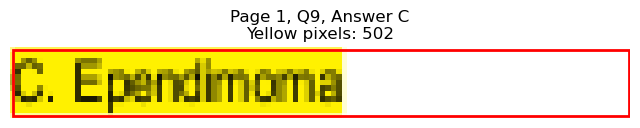

Page 1, Q9 - D: Detected box: x0=322.9, y0=651.5, x1=380.0, y1=663.6
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 274
Page 1, Q9, D: Yellow percentage: 0.0%


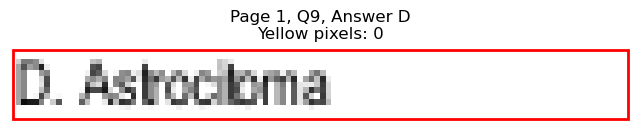

Page 1, Q9 - E: Detected box: x0=322.9, y0=663.5, x1=406.3, y1=675.6
Page 1, Q9, E: Yellow pixels: 0
Page 1, Q9, E: Total non-white pixels: 423
Page 1, Q9, E: Yellow percentage: 0.0%


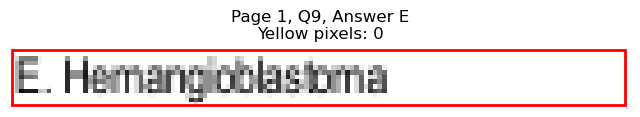


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=82.6, y0=712.3, x1=118.8, y1=724.4
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 195
Page 1, Q10, A: Yellow percentage: 0.0%


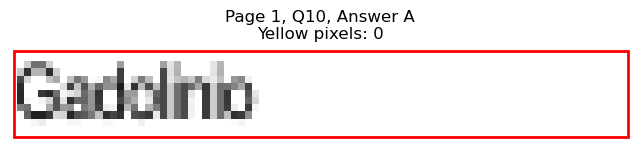

Page 1, Q10 - B: Detected box: x0=71.3, y0=724.3, x1=146.6, y1=736.4
Page 1, Q10, B: Yellow pixels: 601
Page 1, Q10, B: Total non-white pixels: 962
Page 1, Q10, B: Yellow percentage: 62.5%


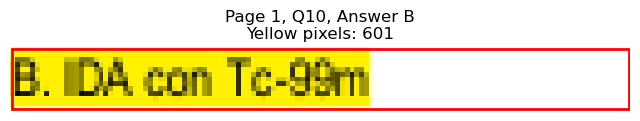

Page 1, Q10 - C: Detected box: x0=71.3, y0=736.4, x1=139.7, y1=748.4
Page 1, Q10, C: Yellow pixels: 0
Page 1, Q10, C: Total non-white pixels: 370
Page 1, Q10, C: Yellow percentage: 0.0%


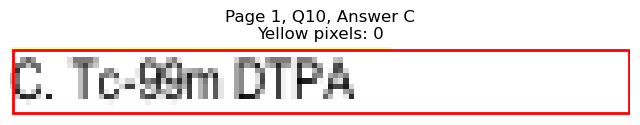

Page 1, Q10 - D: Detected box: x0=322.9, y0=712.3, x1=372.6, y1=724.4
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 214
Page 1, Q10, D: Yellow percentage: 0.0%


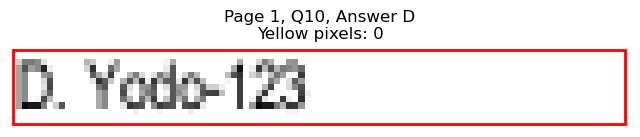

Page 1, Q10 - E: Detected box: x0=322.9, y0=724.3, x1=369.6, y1=736.4
Page 1, Q10, E: Yellow pixels: 0
Page 1, Q10, E: Total non-white pixels: 189
Page 1, Q10, E: Yellow percentage: 0.0%


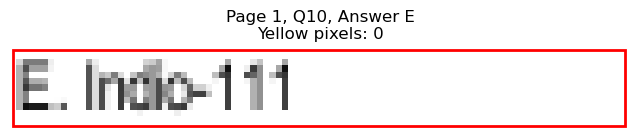


Page 1, Q10 - Selected Answer: B (based on yellow pixel count)





Page 2: Found 11 questions
Page 2, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=180.2, y1=108.8
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 701
Page 2, Q1, A: Yellow percentage: 0.0%


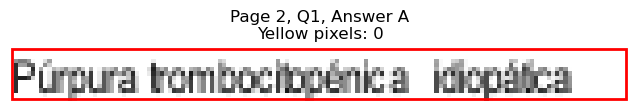

Page 2, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=190.7, y1=121.6
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 604
Page 2, Q1, B: Yellow percentage: 0.0%


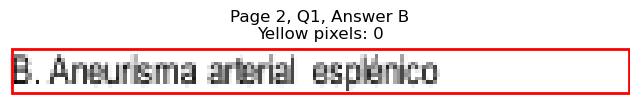

Page 2, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=123.2, y1=133.6
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 240
Page 2, Q1, C: Yellow percentage: 0.0%


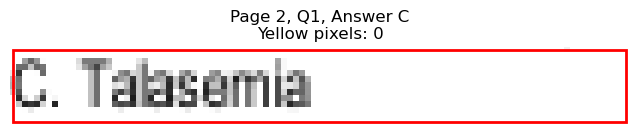

Page 2, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=461.2, y1=108.8
Page 2, Q1, D: Yellow pixels: 1243
Page 2, Q1, D: Total non-white pixels: 2119
Page 2, Q1, D: Yellow percentage: 58.7%


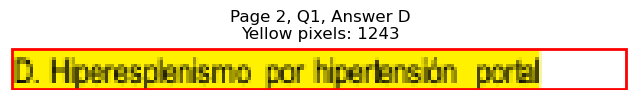

Page 2, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=397.3, y1=121.6
Page 2, Q1, E: Yellow pixels: 125
Page 2, Q1, E: Total non-white pixels: 474
Page 2, Q1, E: Yellow percentage: 26.4%


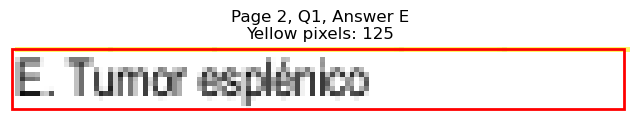


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=133.6, y0=157.6, x1=185.5, y1=169.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 255
Page 2, Q2, A: Yellow percentage: 0.0%


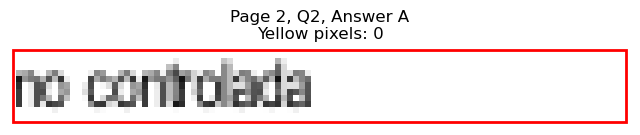

Page 2, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=171.2, y1=181.6
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 519
Page 2, Q2, B: Yellow percentage: 0.0%


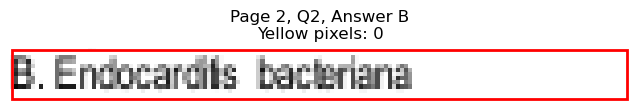

Page 2, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=174.4, y1=193.6
Page 2, Q2, C: Yellow pixels: 810
Page 2, Q2, C: Total non-white pixels: 1313
Page 2, Q2, C: Yellow percentage: 61.7%


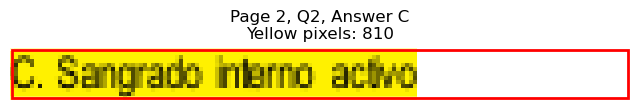

Page 2, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=376.3, y1=169.6
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 485
Page 2, Q2, D: Yellow percentage: 0.0%


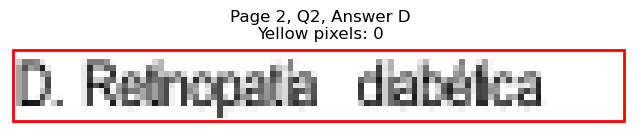

Page 2, Q2 - E: Detected box: x0=322.9, y0=169.6, x1=374.7, y1=181.6
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 236
Page 2, Q2, E: Yellow percentage: 0.0%


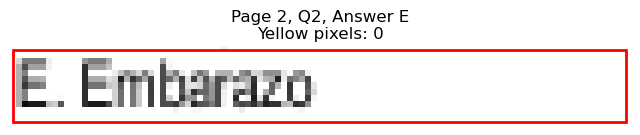


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=82.6, y0=217.6, x1=140.5, y1=229.7
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 313
Page 2, Q3, A: Yellow percentage: 0.0%


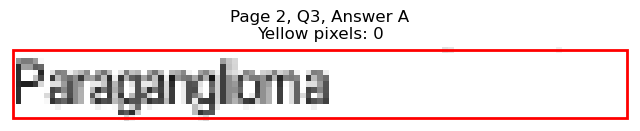

Page 2, Q3 - B: Detected box: x0=71.3, y0=229.6, x1=111.2, y1=241.7
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 197
Page 2, Q3, B: Yellow percentage: 0.0%


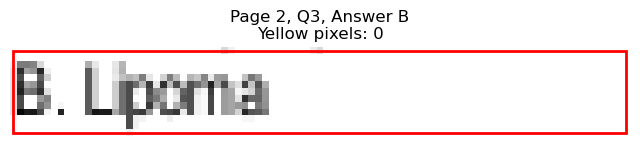

Page 2, Q3 - C: Detected box: x0=71.3, y0=241.6, x1=128.5, y1=253.7
Page 2, Q3, C: Yellow pixels: 431
Page 2, Q3, C: Total non-white pixels: 728
Page 2, Q3, C: Yellow percentage: 59.2%


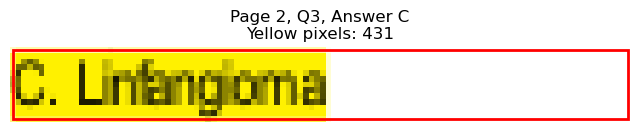

Page 2, Q3 - D: Detected box: x0=322.9, y0=217.6, x1=386.0, y1=229.7
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 327
Page 2, Q3, D: Yellow percentage: 0.0%


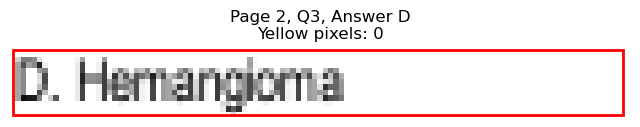

Page 2, Q3 - E: Detected box: x0=322.9, y0=229.6, x1=403.3, y1=241.7
Page 2, Q3, E: Yellow pixels: 0
Page 2, Q3, E: Total non-white pixels: 382
Page 2, Q3, E: Yellow percentage: 0.0%



Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=131.5, y1=314.5
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 250
Page 2, Q4, A: Yellow percentage: 0.0%


Page 2, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=155.5, y1=326.5
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 430
Page 2, Q4, B: Yellow percentage: 0.0%


Page 2, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=120.2, y1=338.5
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 239
Page 2, Q4, C: Yellow percentage: 0.0%


Page 2, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=387.6, y1=314.5
Page 2, Q4, D: Yellow pixels: 544
Page 2, Q4, D: Total non-white pixels: 832
Page 2, Q4, D: Yellow percentage: 65.4%


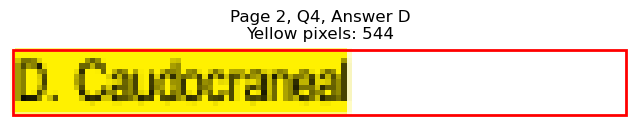

Page 2, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=375.5, y1=326.5
Page 2, Q4, E: Yellow pixels: 62
Page 2, Q4, E: Total non-white pixels: 328
Page 2, Q4, E: Yellow percentage: 18.9%


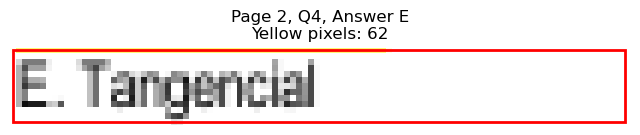


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=136.6, y0=374.5, x1=199.0, y1=386.6
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 297
Page 2, Q5, A: Yellow percentage: 0.0%


Page 2, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=145.7, y1=398.6
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 603
Page 2, Q5, B: Yellow percentage: 0.0%


Page 2, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=200.5, y1=410.6
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 603
Page 2, Q5, C: Yellow percentage: 0.0%


Page 2, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=386.0, y1=386.6
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 600
Page 2, Q5, D: Yellow percentage: 0.0%


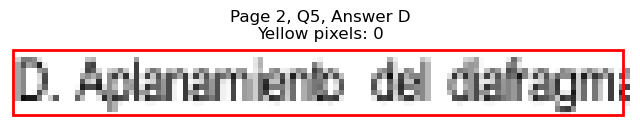

Page 2, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=463.5, y1=398.6
Page 2, Q5, E: Yellow pixels: 1106
Page 2, Q5, E: Total non-white pixels: 1820
Page 2, Q5, E: Yellow percentage: 60.8%



Page 2, Q5 - Selected Answer: E (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.6, y0=434.6, x1=152.5, y1=446.6
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 352
Page 2, Q6, A: Yellow percentage: 0.0%


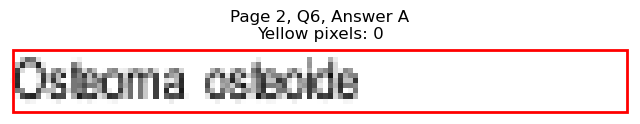

Page 2, Q6 - B: Detected box: x0=71.3, y0=446.6, x1=132.3, y1=458.6
Page 2, Q6, B: Yellow pixels: 472
Page 2, Q6, B: Total non-white pixels: 767
Page 2, Q6, B: Yellow percentage: 61.5%


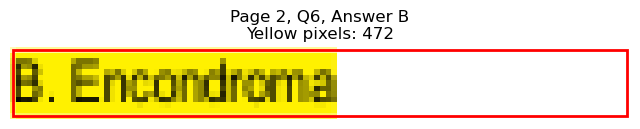

Page 2, Q6 - C: Detected box: x0=71.3, y0=458.6, x1=144.2, y1=470.6
Page 2, Q6, C: Yellow pixels: 59
Page 2, Q6, C: Total non-white pixels: 403
Page 2, Q6, C: Yellow percentage: 14.6%


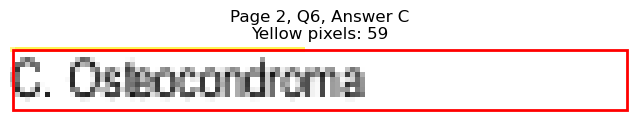

Page 2, Q6 - D: Detected box: x0=322.9, y0=434.6, x1=396.5, y1=446.6
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 366
Page 2, Q6, D: Yellow percentage: 0.0%


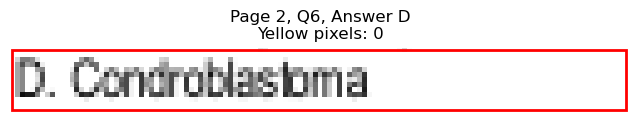

Page 2, Q6 - E: Detected box: x0=322.9, y0=446.6, x1=379.3, y1=458.6
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 424
Page 2, Q6, E: Yellow percentage: 0.0%


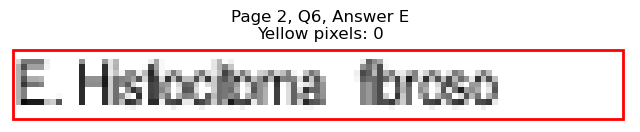


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=82.6, y0=495.4, x1=114.2, y1=507.4
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 173
Page 2, Q7, A: Yellow percentage: 0.0%


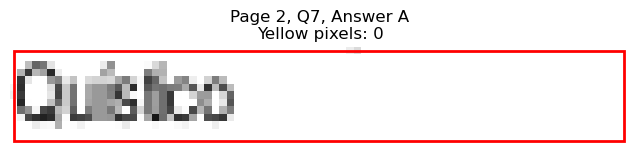

Page 2, Q7 - B: Detected box: x0=71.3, y0=507.4, x1=130.8, y1=519.4
Page 2, Q7, B: Yellow pixels: 498
Page 2, Q7, B: Total non-white pixels: 754
Page 2, Q7, B: Yellow percentage: 66.0%


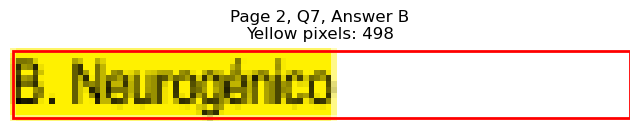

Page 2, Q7 - C: Detected box: x0=71.3, y0=519.4, x1=124.7, y1=531.4
Page 2, Q7, C: Yellow pixels: 56
Page 2, Q7, C: Total non-white pixels: 317
Page 2, Q7, C: Yellow percentage: 17.7%


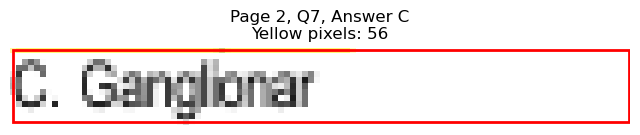

Page 2, Q7 - D: Detected box: x0=322.9, y0=495.4, x1=368.8, y1=507.4
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 213
Page 2, Q7, D: Yellow percentage: 0.0%


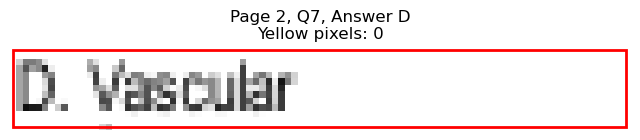

Page 2, Q7 - E: Detected box: x0=322.9, y0=507.4, x1=356.0, y1=519.4
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 151
Page 2, Q7, E: Yellow percentage: 0.0%


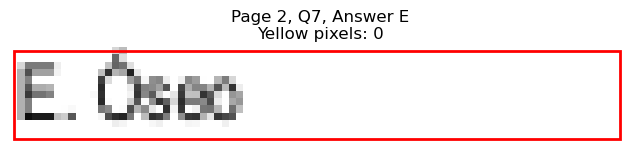


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.6, y0=555.4, x1=118.0, y1=567.5
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 175
Page 2, Q8, A: Yellow percentage: 0.0%


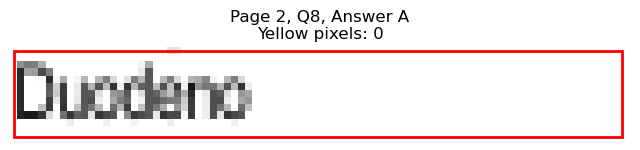

Page 2, Q8 - B: Detected box: x0=71.3, y0=567.5, x1=137.5, y1=579.5
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 333
Page 2, Q8, B: Yellow percentage: 0.0%


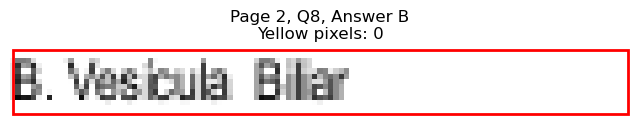

Page 2, Q8 - C: Detected box: x0=71.3, y0=579.4, x1=128.5, y1=591.5
Page 2, Q8, C: Yellow pixels: 491
Page 2, Q8, C: Total non-white pixels: 728
Page 2, Q8, C: Yellow percentage: 67.4%


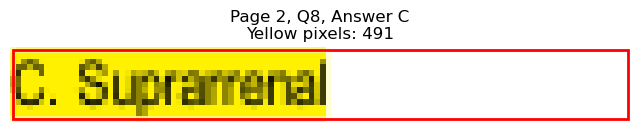

Page 2, Q8 - D: Detected box: x0=322.9, y0=555.4, x1=372.5, y1=567.5
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 234
Page 2, Q8, D: Yellow percentage: 0.0%


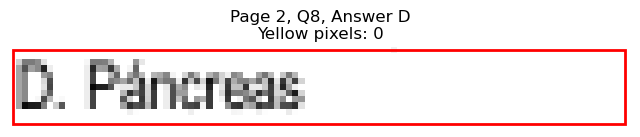

Page 2, Q8 - E: Detected box: x0=322.9, y0=567.5, x1=373.3, y1=579.5
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 251
Page 2, Q8, E: Yellow percentage: 0.0%


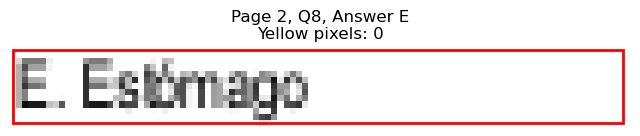


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=82.6, y0=615.5, x1=125.5, y1=627.5
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 205
Page 2, Q9, A: Yellow percentage: 0.0%


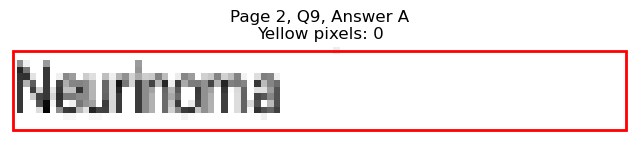

Page 2, Q9 - B: Detected box: x0=71.3, y0=627.5, x1=130.0, y1=639.6
Page 2, Q9, B: Yellow pixels: 496
Page 2, Q9, B: Total non-white pixels: 741
Page 2, Q9, B: Yellow percentage: 66.9%


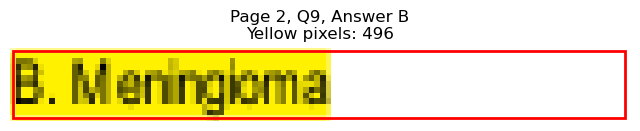

Page 2, Q9 - C: Detected box: x0=71.3, y0=639.5, x1=160.0, y1=651.6
Page 2, Q9, C: Yellow pixels: 57
Page 2, Q9, C: Total non-white pixels: 504
Page 2, Q9, C: Yellow percentage: 11.3%


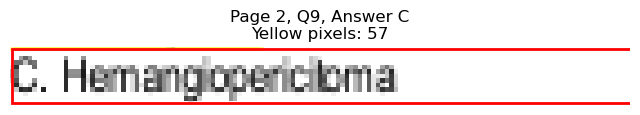

Page 2, Q9 - D: Detected box: x0=322.9, y0=615.5, x1=371.8, y1=627.5
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 230
Page 2, Q9, D: Yellow percentage: 0.0%


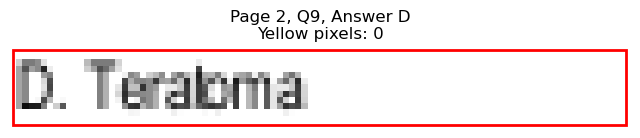

Page 2, Q9 - E: Detected box: x0=322.9, y0=627.5, x1=400.3, y1=639.6
Page 2, Q9, E: Yellow pixels: 0
Page 2, Q9, E: Total non-white pixels: 392
Page 2, Q9, E: Yellow percentage: 0.0%


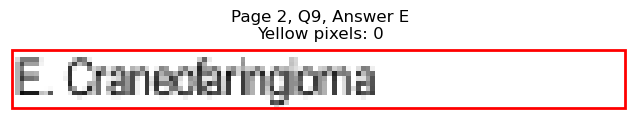


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=82.6, y0=676.3, x1=119.5, y1=688.3
Page 2, Q10, A: Yellow pixels: 0
Page 2, Q10, A: Total non-white pixels: 176
Page 2, Q10, A: Yellow percentage: 0.0%


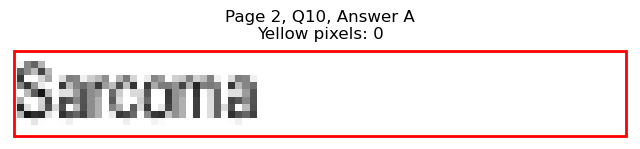

Page 2, Q10 - B: Detected box: x0=71.3, y0=688.3, x1=112.7, y1=700.3
Page 2, Q10, B: Yellow pixels: 0
Page 2, Q10, B: Total non-white pixels: 187
Page 2, Q10, B: Yellow percentage: 0.0%


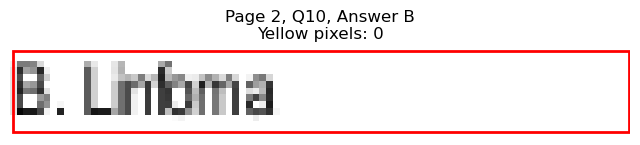

Page 2, Q10 - C: Detected box: x0=71.3, y0=700.3, x1=124.8, y1=712.3
Page 2, Q10, C: Yellow pixels: 411
Page 2, Q10, C: Total non-white pixels: 676
Page 2, Q10, C: Yellow percentage: 60.8%


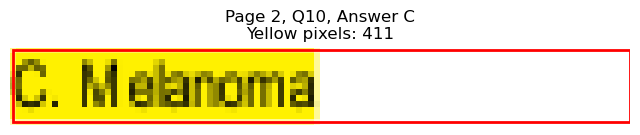

Page 2, Q10 - D: Detected box: x0=322.9, y0=676.3, x1=392.0, y1=688.3
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 359
Page 2, Q10, D: Yellow percentage: 0.0%


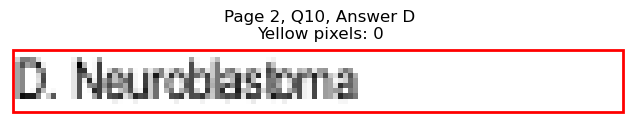

Page 2, Q10 - E: Detected box: x0=322.9, y0=688.3, x1=366.6, y1=700.3
Page 2, Q10, E: Yellow pixels: 0
Page 2, Q10, E: Total non-white pixels: 183
Page 2, Q10, E: Yellow percentage: 0.0%


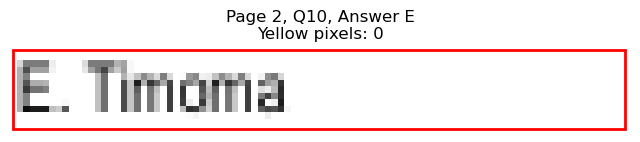


Page 2, Q10 - Selected Answer: C (based on yellow pixel count)




Page 2, Q11 - A: Detected box: x0=82.6, y0=748.4, x1=162.2, y1=760.4
Page 2, Q11, A: Yellow pixels: 0
Page 2, Q11, A: Total non-white pixels: 389
Page 2, Q11, A: Yellow percentage: 0.0%


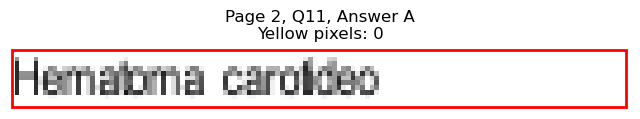

Page 2, Q11 - B: Detected box: x0=71.3, y0=760.4, x1=116.5, y1=772.4
Page 2, Q11, B: Yellow pixels: 0
Page 2, Q11, B: Total non-white pixels: 222
Page 2, Q11, B: Yellow percentage: 0.0%


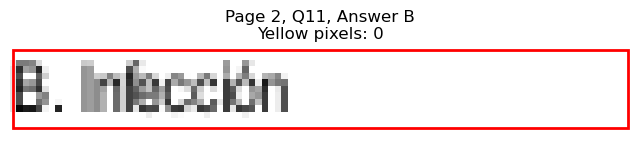

Page 2, Q11 - C: Detected box: x0=71.3, y0=772.4, x1=146.5, y1=784.4
Page 2, Q11, C: Yellow pixels: 0
Page 2, Q11, C: Total non-white pixels: 349
Page 2, Q11, C: Yellow percentage: 0.0%


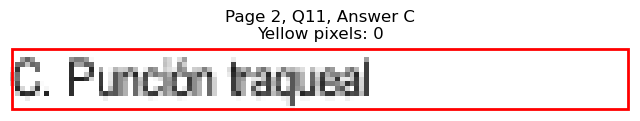

Page 2, Q11 - D: Detected box: x0=322.9, y0=748.4, x1=356.1, y1=760.4
Page 2, Q11, D: Yellow pixels: 286
Page 2, Q11, D: Total non-white pixels: 416
Page 2, Q11, D: Yellow percentage: 68.8%


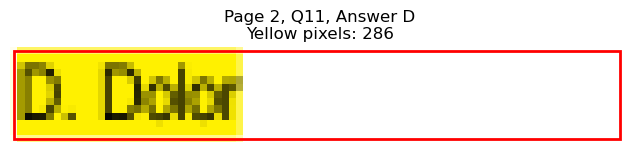

Page 2, Q11 - E: Detected box: x0=322.9, y0=760.4, x1=446.1, y1=772.4
Page 2, Q11, E: Yellow pixels: 30
Page 2, Q11, E: Total non-white pixels: 633
Page 2, Q11, E: Yellow percentage: 4.7%


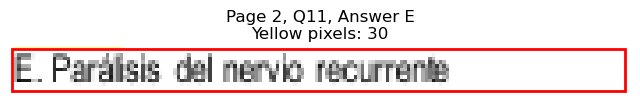


Page 2, Q11 - Selected Answer: D (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=180.9, y1=108.8
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 507
Page 3, Q1, A: Yellow percentage: 0.0%


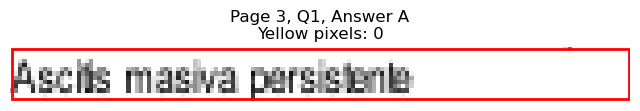

Page 3, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=162.3, y1=121.6
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 664
Page 3, Q1, B: Yellow percentage: 0.0%


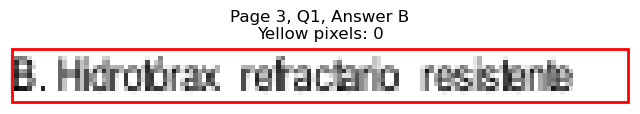

Page 3, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=126.2, y1=133.6
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 523
Page 3, Q1, C: Yellow percentage: 0.0%


Page 3, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=479.2, y1=108.8
Page 3, Q1, D: Yellow pixels: 1193
Page 3, Q1, D: Total non-white pixels: 2021
Page 3, Q1, D: Yellow percentage: 59.0%


Page 3, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=420.5, y1=121.6
Page 3, Q1, E: Yellow pixels: 148
Page 3, Q1, E: Total non-white pixels: 629
Page 3, Q1, E: Yellow percentage: 23.5%



Page 3, Q1 - Selected Answer: D (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=119.5, y1=181.6
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 200
Page 3, Q2, A: Yellow percentage: 0.0%


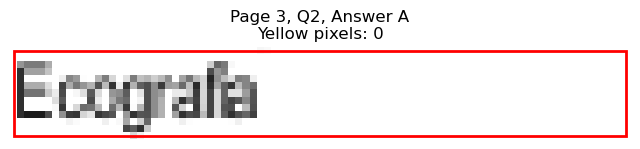

Page 3, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=125.5, y1=193.6
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 266
Page 3, Q2, B: Yellow percentage: 0.0%


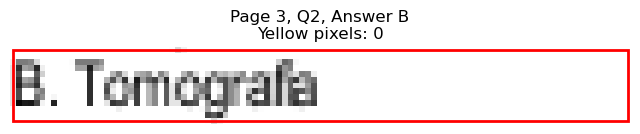

Page 3, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=128.5, y1=205.6
Page 3, Q2, C: Yellow pixels: 436
Page 3, Q2, C: Total non-white pixels: 728
Page 3, Q2, C: Yellow percentage: 59.9%


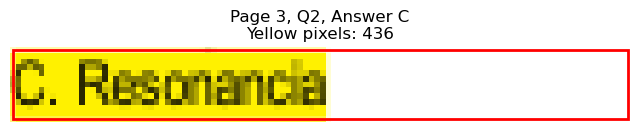

Page 3, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=377.1, y1=181.6
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 293
Page 3, Q2, D: Yellow percentage: 0.0%


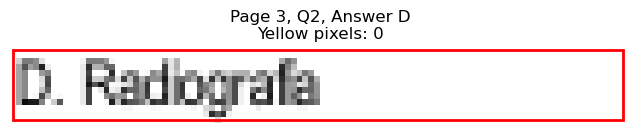

Page 3, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=386.0, y1=193.6
Page 3, Q2, E: Yellow pixels: 0
Page 3, Q2, E: Total non-white pixels: 322
Page 3, Q2, E: Yellow percentage: 0.0%



Page 3, Q2 - Selected Answer: C (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=132.2, y1=253.7
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 221
Page 3, Q3, A: Yellow percentage: 0.0%


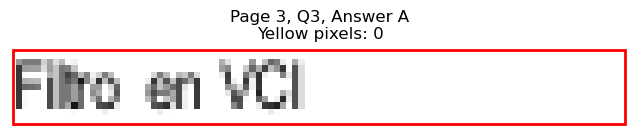

Page 3, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=142.0, y1=265.7
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 364
Page 3, Q3, B: Yellow percentage: 0.0%


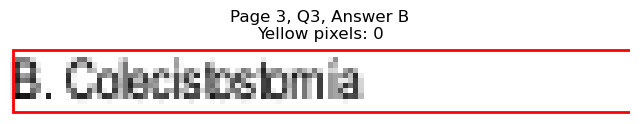

Page 3, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=133.7, y1=277.7
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 295
Page 3, Q3, C: Yellow percentage: 0.0%


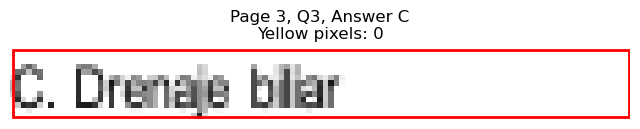

Page 3, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=374.8, y1=253.7
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 247
Page 3, Q3, D: Yellow percentage: 0.0%


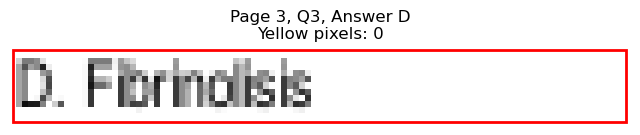

Page 3, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=385.4, y1=265.7
Page 3, Q3, E: Yellow pixels: 458
Page 3, Q3, E: Total non-white pixels: 793
Page 3, Q3, E: Yellow percentage: 57.8%


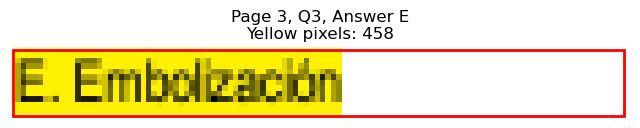


Page 3, Q3 - Selected Answer: E (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=127.0, y1=314.5
Page 3, Q4, A: Yellow pixels: 739
Page 3, Q4, A: Total non-white pixels: 1131
Page 3, Q4, A: Yellow percentage: 65.3%


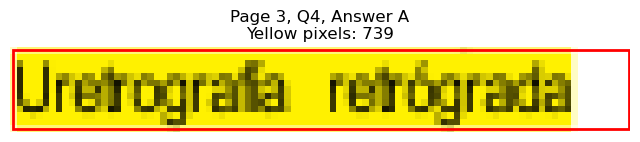

Page 3, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=122.5, y1=326.5
Page 3, Q4, B: Yellow pixels: 85
Page 3, Q4, B: Total non-white pixels: 544
Page 3, Q4, B: Yellow percentage: 15.6%


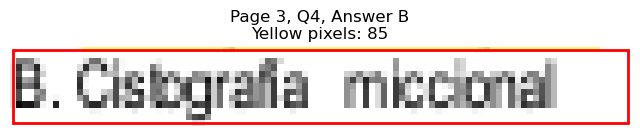

Page 3, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=164.5, y1=338.5
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 440
Page 3, Q4, C: Yellow percentage: 0.0%


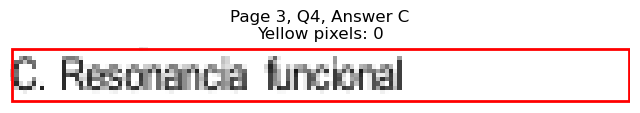

Page 3, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=383.8, y1=314.5
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 297
Page 3, Q4, D: Yellow percentage: 0.0%


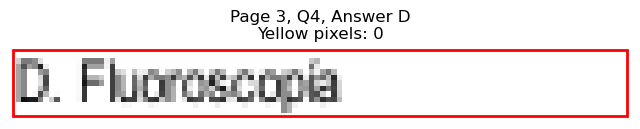

Page 3, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=370.3, y1=326.5
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 234
Page 3, Q4, E: Yellow percentage: 0.0%


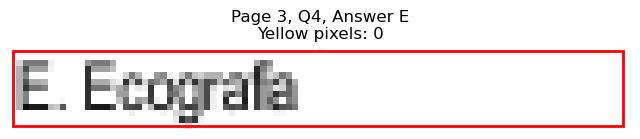


Page 3, Q4 - Selected Answer: A (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=130.7, y1=386.6
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 222
Page 3, Q5, A: Yellow percentage: 0.0%


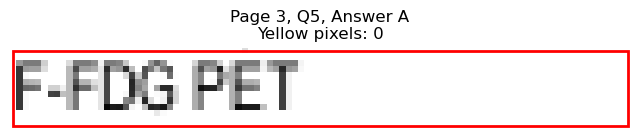

Page 3, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=118.7, y1=398.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 242
Page 3, Q5, B: Yellow percentage: 0.0%


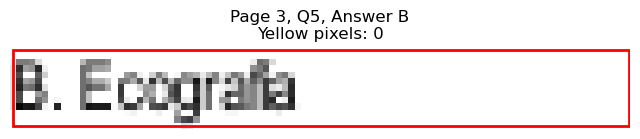

Page 3, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=125.5, y1=410.6
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 276
Page 3, Q5, C: Yellow percentage: 0.0%


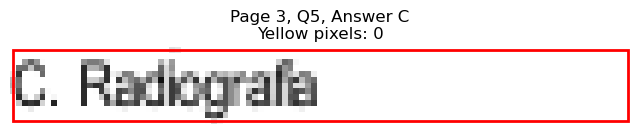

Page 3, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=377.9, y1=386.6
Page 3, Q5, D: Yellow pixels: 464
Page 3, Q5, D: Total non-white pixels: 702
Page 3, Q5, D: Yellow percentage: 66.1%


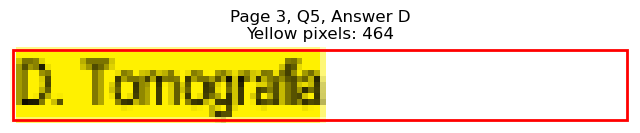

Page 3, Q5 - E: Detected box: x0=322.9, y0=446.6, x1=379.4, y1=458.6
Page 3, Q5, E: Yellow pixels: 413
Page 3, Q5, E: Total non-white pixels: 715
Page 3, Q5, E: Yellow percentage: 57.8%


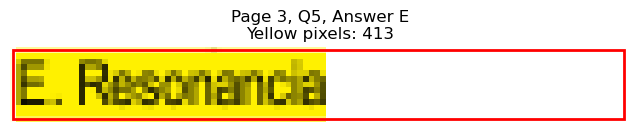


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=82.6, y0=434.6, x1=126.2, y1=446.6
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 223
Page 3, Q6, A: Yellow percentage: 0.0%


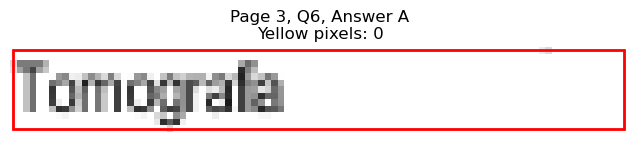

Page 3, Q6 - B: Detected box: x0=71.3, y0=386.5, x1=118.7, y1=398.6
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 242
Page 3, Q6, B: Yellow percentage: 0.0%


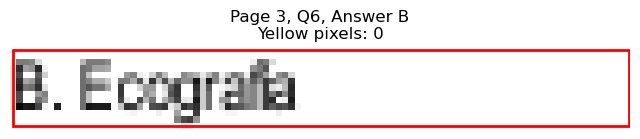

Page 3, Q6 - C: Detected box: x0=71.3, y0=458.6, x1=130.7, y1=470.6
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 253
Page 3, Q6, C: Yellow percentage: 0.0%


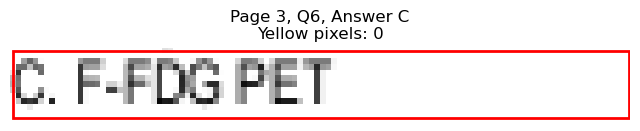

Page 3, Q6 - D: Detected box: x0=322.9, y0=169.6, x1=377.1, y1=181.6
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 293
Page 3, Q6, D: Yellow percentage: 0.0%


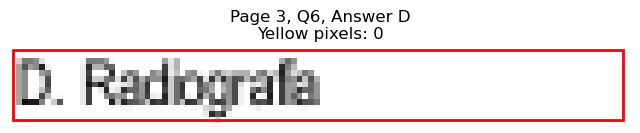

Page 3, Q6 - E: Detected box: x0=322.9, y0=446.6, x1=379.4, y1=458.6
Page 3, Q6, E: Yellow pixels: 413
Page 3, Q6, E: Total non-white pixels: 715
Page 3, Q6, E: Yellow percentage: 57.8%


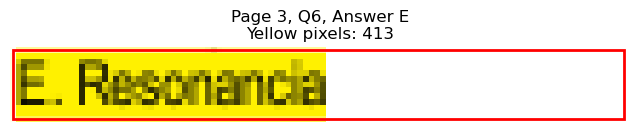


Page 3, Q6 - Selected Answer: E (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.6, y0=519.4, x1=133.7, y1=531.4
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 476
Page 3, Q7, A: Yellow percentage: 0.0%


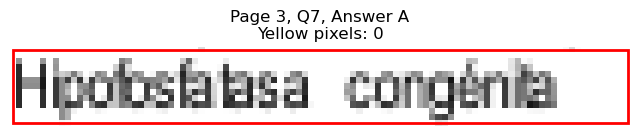

Page 3, Q7 - B: Detected box: x0=71.3, y0=531.4, x1=136.8, y1=543.5
Page 3, Q7, B: Yellow pixels: 567
Page 3, Q7, B: Total non-white pixels: 834
Page 3, Q7, B: Yellow percentage: 68.0%


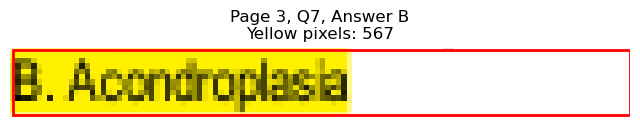

Page 3, Q7 - C: Detected box: x0=71.3, y0=543.4, x1=145.0, y1=555.5
Page 3, Q7, C: Yellow pixels: 62
Page 3, Q7, C: Total non-white pixels: 421
Page 3, Q7, C: Yellow percentage: 14.7%


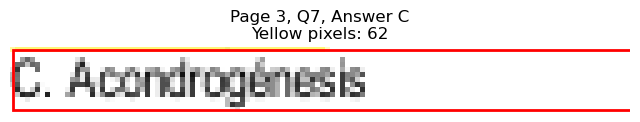

Page 3, Q7 - D: Detected box: x0=322.9, y0=519.4, x1=414.5, y1=531.4
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 492
Page 3, Q7, D: Yellow percentage: 0.0%


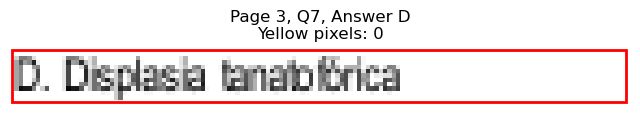

Page 3, Q7 - E: Detected box: x0=322.9, y0=531.4, x1=428.0, y1=543.5
Page 3, Q7, E: Yellow pixels: 0
Page 3, Q7, E: Total non-white pixels: 551
Page 3, Q7, E: Yellow percentage: 0.0%


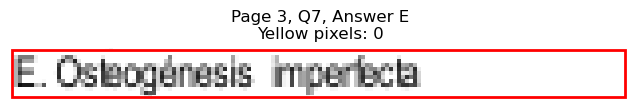


Page 3, Q7 - Selected Answer: B (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=82.6, y0=591.5, x1=128.5, y1=603.5
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 237
Page 3, Q8, A: Yellow percentage: 0.0%


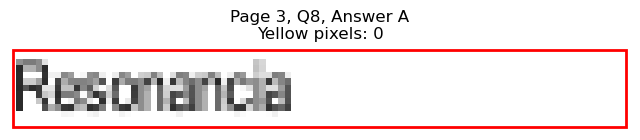

Page 3, Q8 - B: Detected box: x0=71.3, y0=386.5, x1=118.7, y1=398.6
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 242
Page 3, Q8, B: Yellow percentage: 0.0%


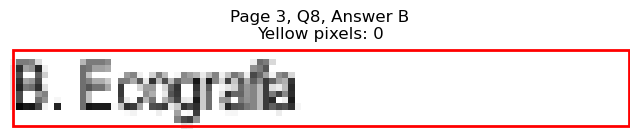

Page 3, Q8 - C: Detected box: x0=71.3, y0=615.5, x1=129.2, y1=627.5
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 271
Page 3, Q8, C: Yellow percentage: 0.0%


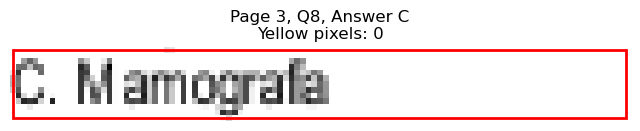

Page 3, Q8 - D: Detected box: x0=322.9, y0=591.5, x1=386.9, y1=603.5
Page 3, Q8, D: Yellow pixels: 541
Page 3, Q8, D: Total non-white pixels: 819
Page 3, Q8, D: Yellow percentage: 66.1%


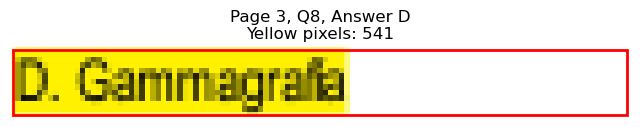

Page 3, Q8 - E: Detected box: x0=322.9, y0=603.5, x1=377.0, y1=615.5
Page 3, Q8, E: Yellow pixels: 61
Page 3, Q8, E: Total non-white pixels: 325
Page 3, Q8, E: Yellow percentage: 18.8%


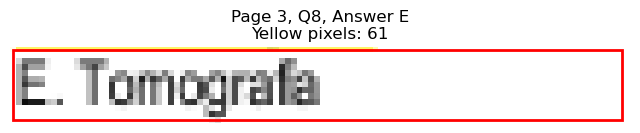


Page 3, Q8 - Selected Answer: D (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=82.6, y0=651.5, x1=193.7, y1=663.6
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 537
Page 3, Q9, A: Yellow percentage: 0.0%


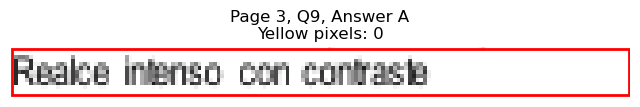

Page 3, Q9 - B: Detected box: x0=71.3, y0=663.5, x1=217.2, y1=675.6
Page 3, Q9, B: Yellow pixels: 1170
Page 3, Q9, B: Total non-white pixels: 1872
Page 3, Q9, B: Yellow percentage: 62.5%


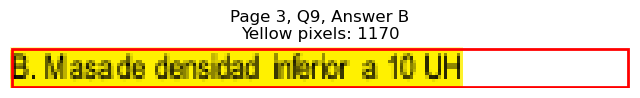

Page 3, Q9 - C: Detected box: x0=71.3, y0=676.3, x1=140.5, y1=688.3
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 445
Page 3, Q9, C: Yellow percentage: 0.0%


Page 3, Q9 - D: Detected box: x0=322.9, y0=651.5, x1=473.8, y1=663.6
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 705
Page 3, Q9, D: Yellow percentage: 0.0%


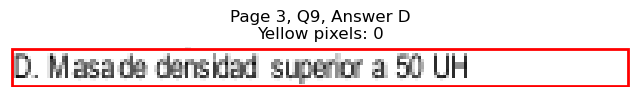

Page 3, Q9 - E: Detected box: x0=322.9, y0=663.5, x1=424.3, y1=675.6
Page 3, Q9, E: Yellow pixels: 0
Page 3, Q9, E: Total non-white pixels: 746
Page 3, Q9, E: Yellow percentage: 0.0%


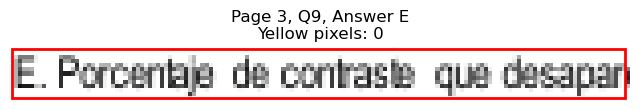


Page 3, Q9 - Selected Answer: B (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=82.6, y0=736.4, x1=92.5, y1=748.4
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 47
Page 3, Q10, A: Yellow percentage: 0.0%


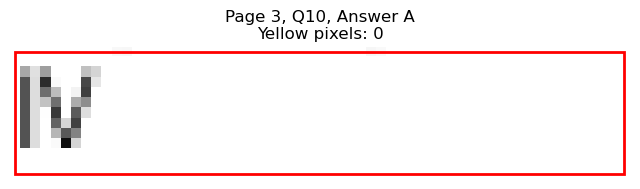

Page 3, Q10 - B: Detected box: x0=71.3, y0=748.4, x1=89.5, y1=760.4
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 70
Page 3, Q10, B: Yellow percentage: 0.0%


Page 3, Q10 - C: Detected box: x0=71.3, y0=760.4, x1=91.8, y1=772.4
Page 3, Q10, C: Yellow pixels: 168
Page 3, Q10, C: Total non-white pixels: 247
Page 3, Q10, C: Yellow percentage: 68.0%


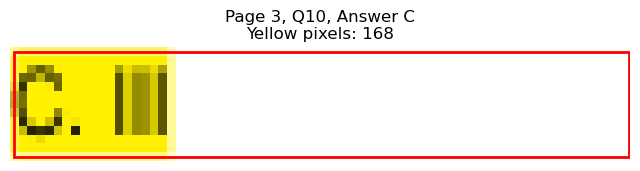

Page 3, Q10 - D: Detected box: x0=322.9, y0=736.4, x1=341.0, y1=748.4
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 64
Page 3, Q10, D: Yellow percentage: 0.0%


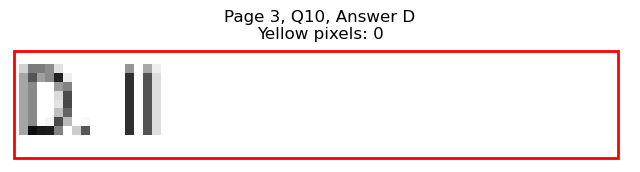

Page 3, Q10 - E: Detected box: x0=322.9, y0=748.4, x1=335.8, y1=760.4
Page 3, Q10, E: Yellow pixels: 0
Page 3, Q10, E: Total non-white pixels: 53
Page 3, Q10, E: Yellow percentage: 0.0%


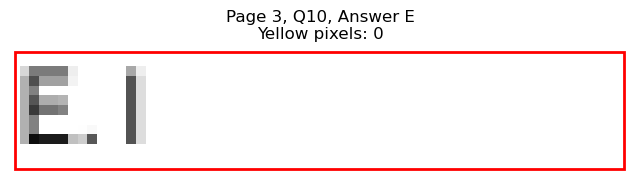


Page 3, Q10 - Selected Answer: C (based on yellow pixel count)





Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=152.5, y1=121.6
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 358
Page 4, Q1, A: Yellow percentage: 0.0%


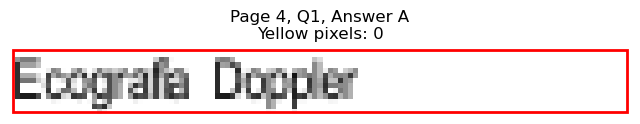

Page 4, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=125.5, y1=133.6
Page 4, Q1, B: Yellow pixels: 462
Page 4, Q1, B: Total non-white pixels: 692
Page 4, Q1, B: Yellow percentage: 66.8%


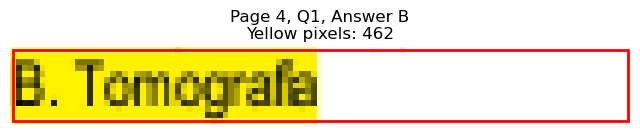

Page 4, Q1 - C: Detected box: x0=129.2, y0=133.5, x1=195.3, y1=145.6
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 325
Page 4, Q1, C: Yellow percentage: 0.0%


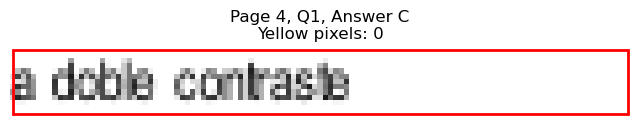

Page 4, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=400.3, y1=121.6
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 383
Page 4, Q1, D: Yellow percentage: 0.0%


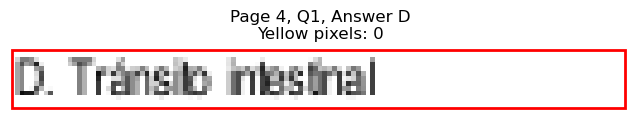

Page 4, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=379.3, y1=133.6
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 277
Page 4, Q1, E: Yellow percentage: 0.0%


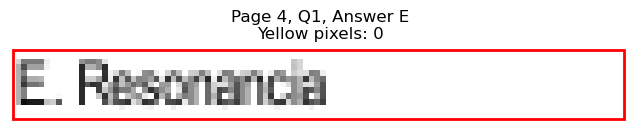


Page 4, Q1 - Selected Answer: B (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=120.8, y0=181.6, x1=157.7, y1=193.6
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 185
Page 4, Q2, A: Yellow percentage: 0.0%


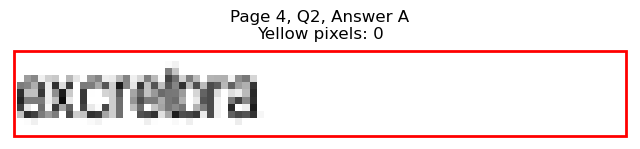

Page 4, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=121.7, y1=205.6
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 506
Page 4, Q2, B: Yellow percentage: 0.0%


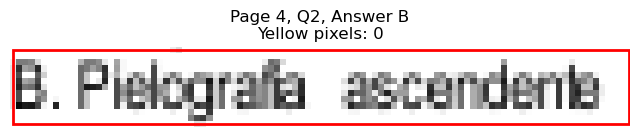

Page 4, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=128.5, y1=217.7
Page 4, Q2, C: Yellow pixels: 806
Page 4, Q2, C: Total non-white pixels: 1313
Page 4, Q2, C: Yellow percentage: 61.4%


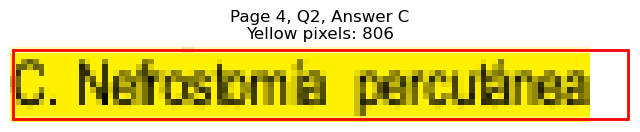

Page 4, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=396.5, y1=193.6
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 390
Page 4, Q2, D: Yellow percentage: 0.0%


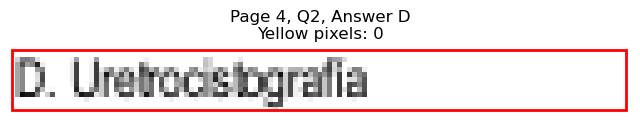

Page 4, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=386.0, y1=205.6
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 322
Page 4, Q2, E: Yellow percentage: 0.0%


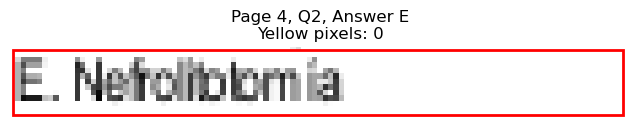


Page 4, Q2 - Selected Answer: C (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.6, y0=109.5, x1=119.5, y1=121.6
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 358
Page 4, Q3, A: Yellow percentage: 0.0%


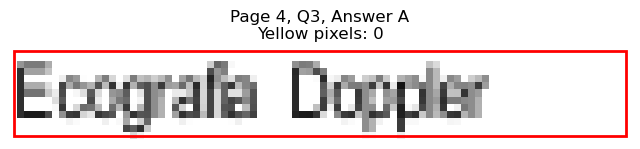

Page 4, Q3 - B: Detected box: x0=71.3, y0=121.5, x1=125.5, y1=133.6
Page 4, Q3, B: Yellow pixels: 462
Page 4, Q3, B: Total non-white pixels: 692
Page 4, Q3, B: Yellow percentage: 66.8%


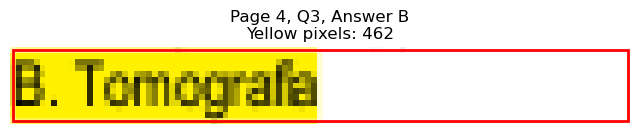

Page 4, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=128.5, y1=277.7
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 269
Page 4, Q3, C: Yellow percentage: 0.0%


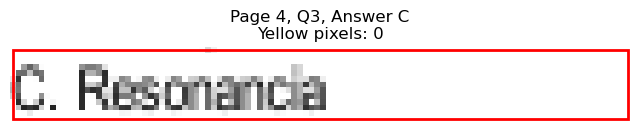

Page 4, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=400.3, y1=253.7
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 418
Page 4, Q3, D: Yellow percentage: 0.0%


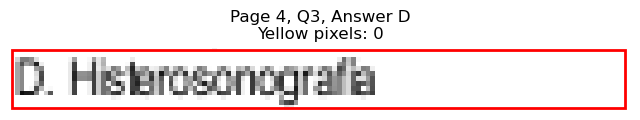

Page 4, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=413.9, y1=265.7
Page 4, Q3, E: Yellow pixels: 673
Page 4, Q3, E: Total non-white pixels: 1170
Page 4, Q3, E: Yellow percentage: 57.5%


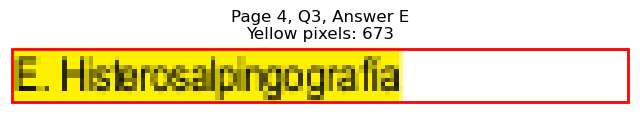


Page 4, Q3 - Selected Answer: E (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=141.9, y0=302.5, x1=220.7, y1=314.5
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 576
Page 4, Q4, A: Yellow percentage: 0.0%


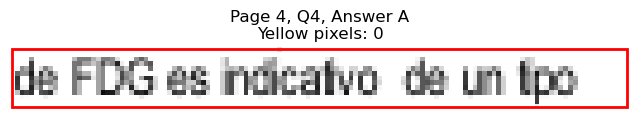

Page 4, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=256.2, y1=338.5
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 864
Page 4, Q4, B: Yellow percentage: 0.0%


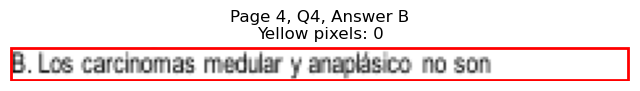

Page 4, Q4 - C: Detected box: x0=71.3, y0=350.5, x1=238.7, y1=362.5
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 784
Page 4, Q4, C: Yellow percentage: 0.0%


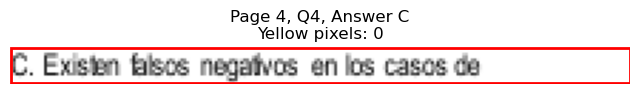

Page 4, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=515.8, y1=314.5
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 895
Page 4, Q4, D: Yellow percentage: 0.0%


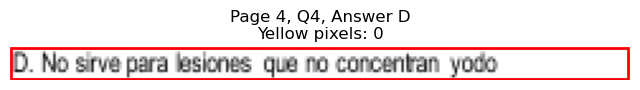

Page 4, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=431.8, y1=338.5
Page 4, Q4, E: Yellow pixels: 1355
Page 4, Q4, E: Total non-white pixels: 1989
Page 4, Q4, E: Yellow percentage: 68.1%


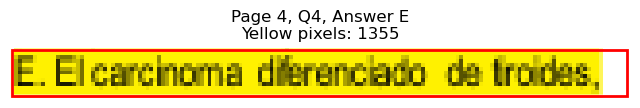


Page 4, Q4 - Selected Answer: E (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=82.6, y0=410.5, x1=100.7, y1=422.6
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 75
Page 4, Q5, A: Yellow percentage: 0.0%


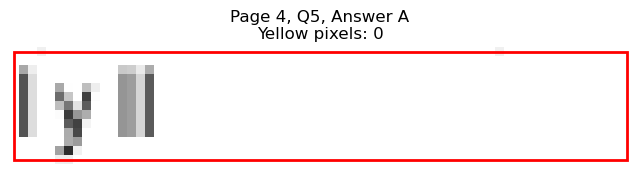

Page 4, Q5 - B: Detected box: x0=71.3, y0=422.5, x1=106.7, y1=434.6
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 139
Page 4, Q5, B: Yellow percentage: 0.0%


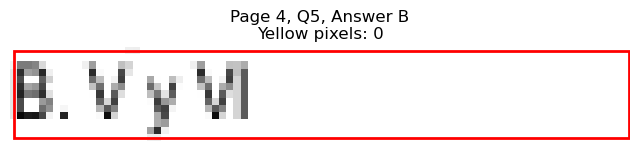

Page 4, Q5 - C: Detected box: x0=71.3, y0=434.6, x1=108.3, y1=446.6
Page 4, Q5, C: Yellow pixels: 309
Page 4, Q5, C: Total non-white pixels: 456
Page 4, Q5, C: Yellow percentage: 67.8%


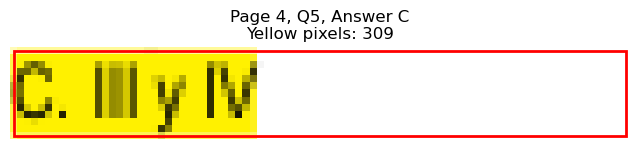

Page 4, Q5 - D: Detected box: x0=322.9, y0=410.5, x1=357.5, y1=422.6
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 131
Page 4, Q5, D: Yellow percentage: 0.0%


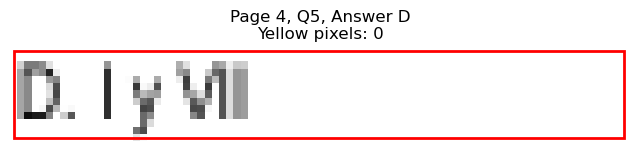

Page 4, Q5 - E: Detected box: x0=322.9, y0=422.5, x1=355.3, y1=434.6
Page 4, Q5, E: Yellow pixels: 0
Page 4, Q5, E: Total non-white pixels: 122
Page 4, Q5, E: Yellow percentage: 0.0%


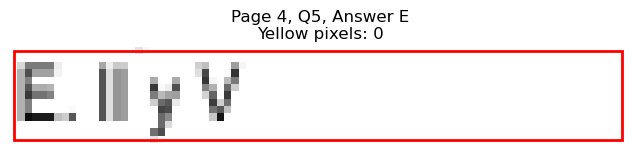


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.6, y0=470.6, x1=217.7, y1=482.6
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 787
Page 4, Q6, A: Yellow percentage: 0.0%


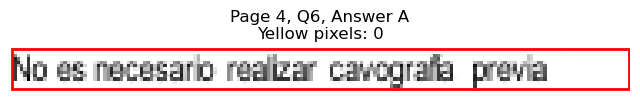

Page 4, Q6 - B: Detected box: x0=71.3, y0=483.4, x1=271.1, y1=495.4
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 945
Page 4, Q6, B: Yellow percentage: 0.0%


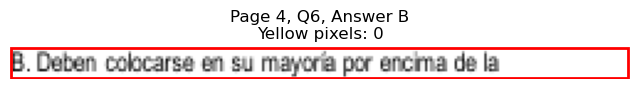

Page 4, Q6 - C: Detected box: x0=71.3, y0=507.4, x1=261.9, y1=519.4
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 885
Page 4, Q6, C: Yellow percentage: 0.0%


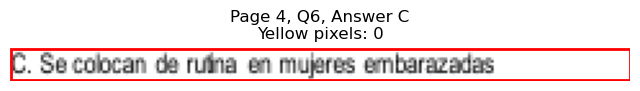

Page 4, Q6 - D: Detected box: x0=322.9, y0=470.6, x1=526.2, y1=482.6
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 923
Page 4, Q6, D: Yellow percentage: 0.0%


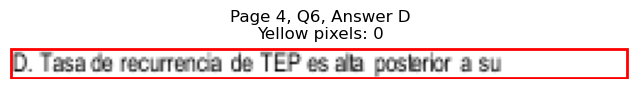

Page 4, Q6 - E: Detected box: x0=322.9, y0=495.4, x1=425.0, y1=507.4
Page 4, Q6, E: Yellow pixels: 1380
Page 4, Q6, E: Total non-white pixels: 2002
Page 4, Q6, E: Yellow percentage: 68.9%


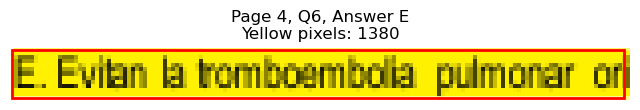


Page 4, Q6 - Selected Answer: E (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.6, y0=543.4, x1=162.2, y1=555.5
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 435
Page 4, Q7, A: Yellow percentage: 0.0%


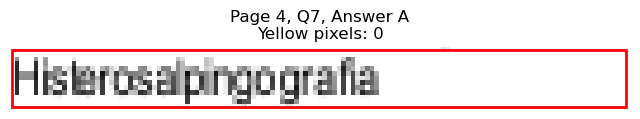

Page 4, Q7 - B: Detected box: x0=71.3, y0=555.4, x1=118.8, y1=567.5
Page 4, Q7, B: Yellow pixels: 389
Page 4, Q7, B: Total non-white pixels: 603
Page 4, Q7, B: Yellow percentage: 64.5%


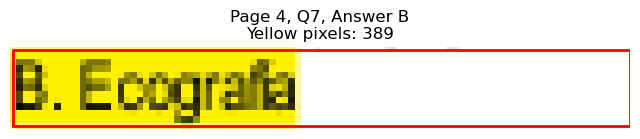

Page 4, Q7 - C: Detected box: x0=71.3, y0=133.5, x1=125.5, y1=145.6
Page 4, Q7, C: Yellow pixels: 52
Page 4, Q7, C: Total non-white pixels: 554
Page 4, Q7, C: Yellow percentage: 9.4%


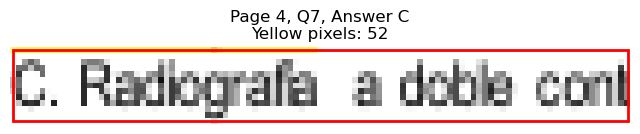

Page 4, Q7 - D: Detected box: x0=322.9, y0=109.5, x1=400.3, y1=121.6
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 383
Page 4, Q7, D: Yellow percentage: 0.0%


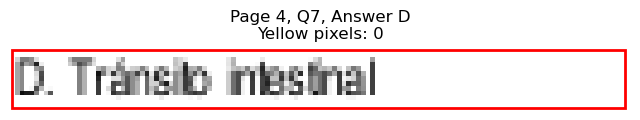

Page 4, Q7 - E: Detected box: x0=322.9, y0=555.4, x1=383.0, y1=567.5
Page 4, Q7, E: Yellow pixels: 0
Page 4, Q7, E: Total non-white pixels: 295
Page 4, Q7, E: Yellow percentage: 0.0%


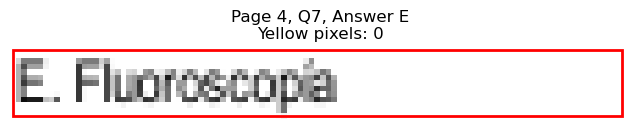


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=82.6, y0=603.5, x1=142.0, y1=615.5
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 305
Page 4, Q8, A: Yellow percentage: 0.0%


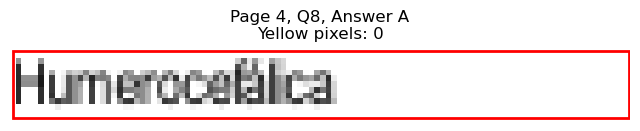

Page 4, Q8 - B: Detected box: x0=71.3, y0=615.5, x1=132.2, y1=627.5
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 310
Page 4, Q8, B: Yellow percentage: 0.0%


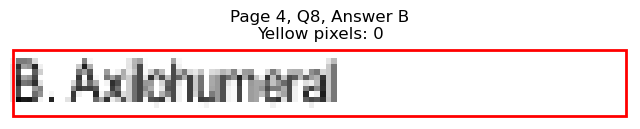

Page 4, Q8 - C: Detected box: x0=71.3, y0=627.5, x1=128.5, y1=639.6
Page 4, Q8, C: Yellow pixels: 490
Page 4, Q8, C: Total non-white pixels: 728
Page 4, Q8, C: Yellow percentage: 67.3%


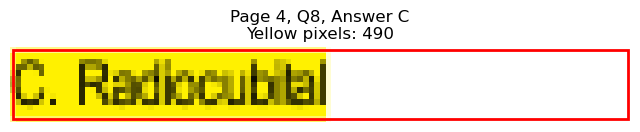

Page 4, Q8 - D: Detected box: x0=322.9, y0=603.5, x1=380.8, y1=615.5
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 296
Page 4, Q8, D: Yellow percentage: 0.0%


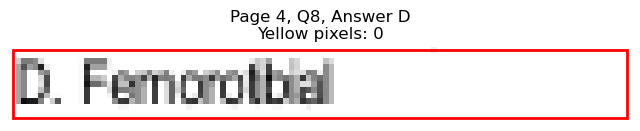

Page 4, Q8 - E: Detected box: x0=322.9, y0=615.5, x1=383.1, y1=627.5
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 296
Page 4, Q8, E: Yellow percentage: 0.0%


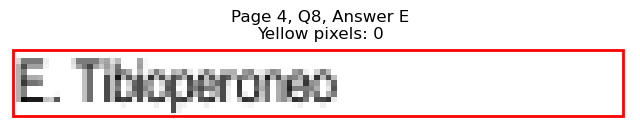


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=82.6, y0=676.3, x1=126.2, y1=688.3
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 221
Page 4, Q9, A: Yellow percentage: 0.0%


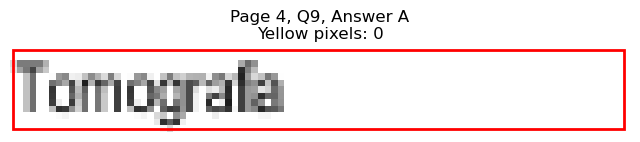

Page 4, Q9 - B: Detected box: x0=71.3, y0=555.4, x1=118.8, y1=567.5
Page 4, Q9, B: Yellow pixels: 389
Page 4, Q9, B: Total non-white pixels: 603
Page 4, Q9, B: Yellow percentage: 64.5%


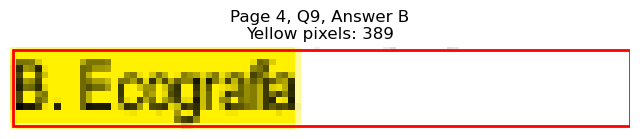

Page 4, Q9 - C: Detected box: x0=71.3, y0=700.3, x1=130.7, y1=712.3
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 253
Page 4, Q9, C: Yellow percentage: 0.0%


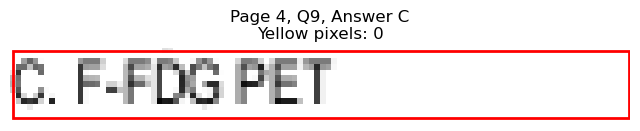

Page 4, Q9 - D: Detected box: x0=322.9, y0=676.3, x1=377.0, y1=688.3
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 293
Page 4, Q9, D: Yellow percentage: 0.0%


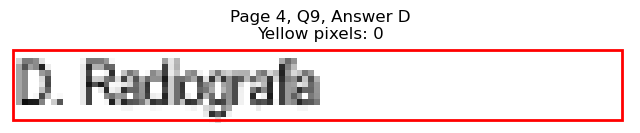

Page 4, Q9 - E: Detected box: x0=322.9, y0=688.3, x1=379.4, y1=700.3
Page 4, Q9, E: Yellow pixels: 411
Page 4, Q9, E: Total non-white pixels: 715
Page 4, Q9, E: Yellow percentage: 57.5%


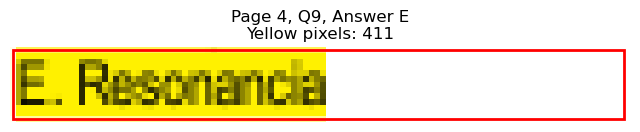


Page 4, Q9 - Selected Answer: E (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=147.2, y1=121.6
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 322
Page 5, Q1, A: Yellow percentage: 0.0%


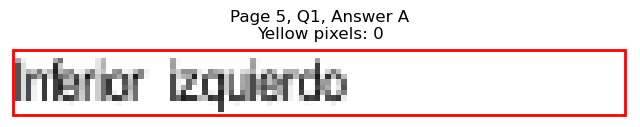

Page 5, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=149.6, y1=133.6
Page 5, Q1, B: Yellow pixels: 679
Page 5, Q1, B: Total non-white pixels: 1001
Page 5, Q1, B: Yellow percentage: 67.8%


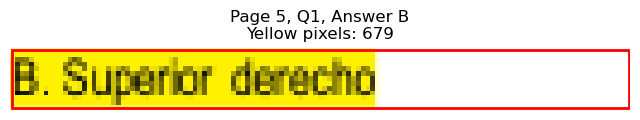

Page 5, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=129.2, y1=145.6
Page 5, Q1, C: Yellow pixels: 76
Page 5, Q1, C: Total non-white pixels: 367
Page 5, Q1, C: Yellow percentage: 20.7%


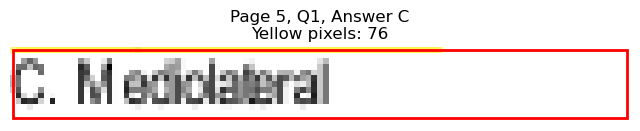

Page 5, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=362.1, y1=121.6
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 187
Page 5, Q1, D: Yellow percentage: 0.0%


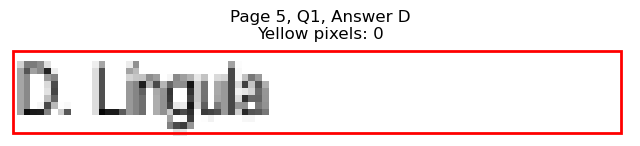

Page 5, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=397.4, y1=133.6
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 360
Page 5, Q1, E: Yellow percentage: 0.0%


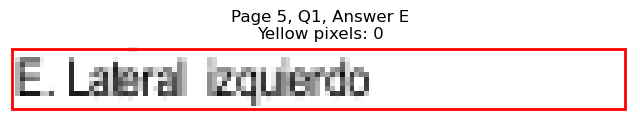


Page 5, Q1 - Selected Answer: B (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=151.7, y1=181.6
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 331
Page 5, Q2, A: Yellow percentage: 0.0%


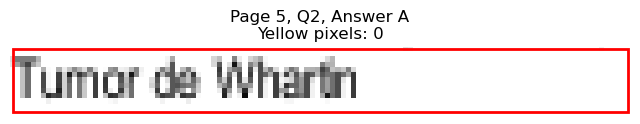

Page 5, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=159.3, y1=193.6
Page 5, Q2, B: Yellow pixels: 687
Page 5, Q2, B: Total non-white pixels: 1118
Page 5, Q2, B: Yellow percentage: 61.4%


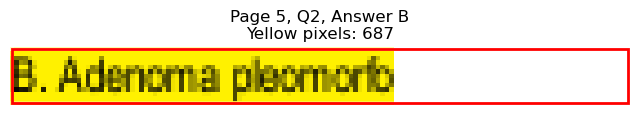

Page 5, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=162.2, y1=205.6
Page 5, Q2, C: Yellow pixels: 86
Page 5, Q2, C: Total non-white pixels: 519
Page 5, Q2, C: Yellow percentage: 16.6%


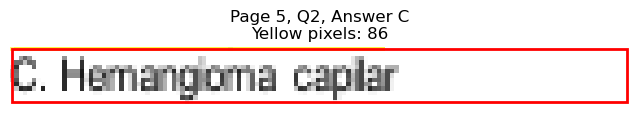

Page 5, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=380.1, y1=181.6
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 452
Page 5, Q2, D: Yellow percentage: 0.0%


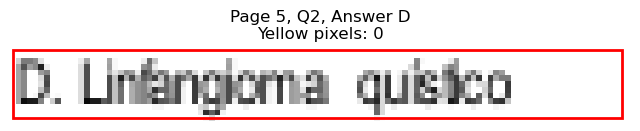

Page 5, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=386.8, y1=193.6
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 307
Page 5, Q2, E: Yellow percentage: 0.0%


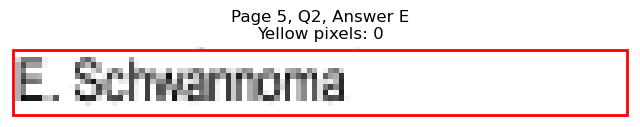


Page 5, Q2 - Selected Answer: B (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=94.0, y1=253.7
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 58
Page 5, Q3, A: Yellow percentage: 0.0%


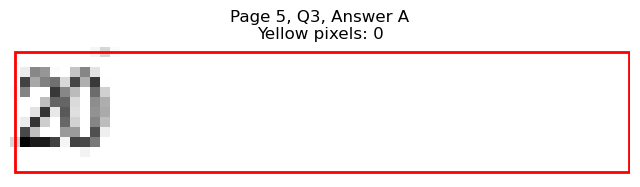

Page 5, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=93.3, y1=265.7
Page 5, Q3, B: Yellow pixels: 161
Page 5, Q3, B: Total non-white pixels: 260
Page 5, Q3, B: Yellow percentage: 61.9%


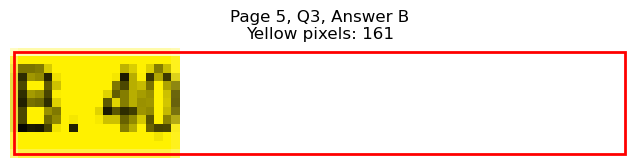

Page 5, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=94.0, y1=277.7
Page 5, Q3, C: Yellow pixels: 20
Page 5, Q3, C: Total non-white pixels: 103
Page 5, Q3, C: Yellow percentage: 19.4%


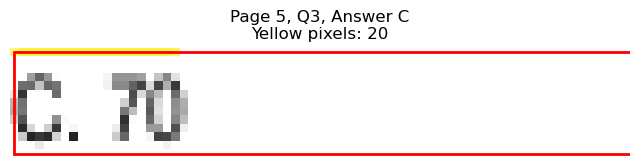

Page 5, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=345.5, y1=253.7
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 103
Page 5, Q3, D: Yellow percentage: 0.0%


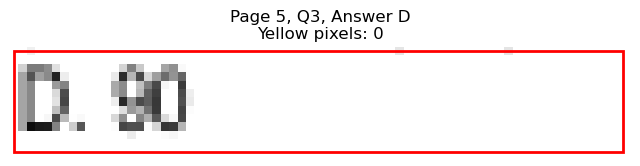

Page 5, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=344.8, y1=265.7
Page 5, Q3, E: Yellow pixels: 0
Page 5, Q3, E: Total non-white pixels: 86
Page 5, Q3, E: Yellow percentage: 0.0%


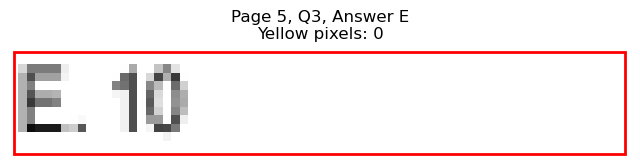


Page 5, Q3 - Selected Answer: B (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=82.6, y0=326.5, x1=157.7, y1=338.5
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 385
Page 5, Q4, A: Yellow percentage: 0.0%


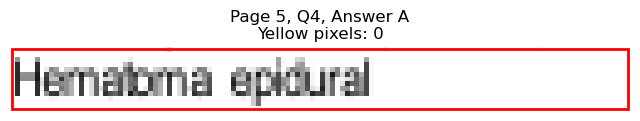

Page 5, Q4 - B: Detected box: x0=71.3, y0=338.5, x1=185.5, y1=350.5
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 580
Page 5, Q4, B: Yellow percentage: 0.0%


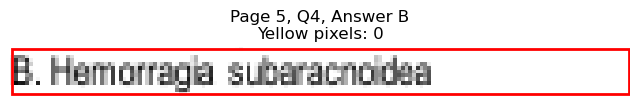

Page 5, Q4 - C: Detected box: x0=71.3, y0=350.5, x1=161.6, y1=362.5
Page 5, Q4, C: Yellow pixels: 807
Page 5, Q4, C: Total non-white pixels: 1157
Page 5, Q4, C: Yellow percentage: 69.7%


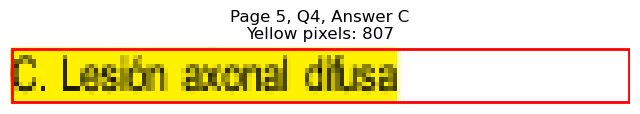

Page 5, Q4 - D: Detected box: x0=322.9, y0=326.5, x1=412.3, y1=338.5
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 448
Page 5, Q4, D: Yellow percentage: 0.0%


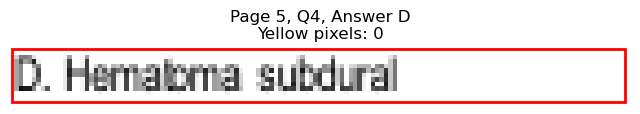

Page 5, Q4 - E: Detected box: x0=322.9, y0=338.5, x1=416.8, y1=350.5
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 437
Page 5, Q4, E: Yellow percentage: 0.0%


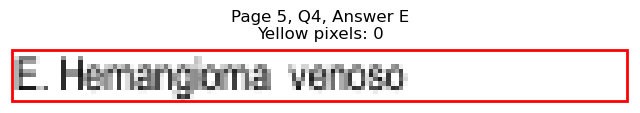


Page 5, Q4 - Selected Answer: C (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.6, y0=386.5, x1=108.2, y1=398.6
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 144
Page 5, Q5, A: Yellow percentage: 0.0%


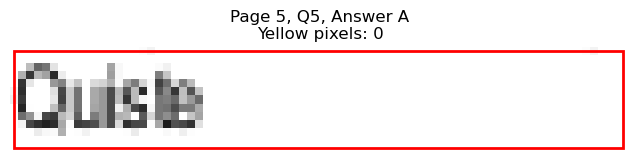

Page 5, Q5 - B: Detected box: x0=71.3, y0=398.5, x1=115.0, y1=410.6
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 193
Page 5, Q5, B: Yellow percentage: 0.0%


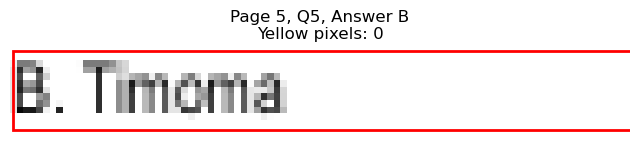

Page 5, Q5 - C: Detected box: x0=71.3, y0=410.5, x1=125.5, y1=422.6
Page 5, Q5, C: Yellow pixels: 420
Page 5, Q5, C: Total non-white pixels: 689
Page 5, Q5, C: Yellow percentage: 61.0%


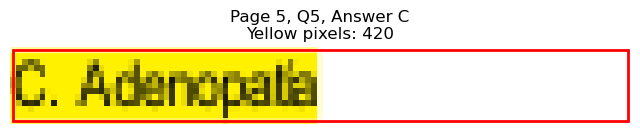

Page 5, Q5 - D: Detected box: x0=322.9, y0=386.5, x1=371.8, y1=398.6
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 230
Page 5, Q5, D: Yellow percentage: 0.0%


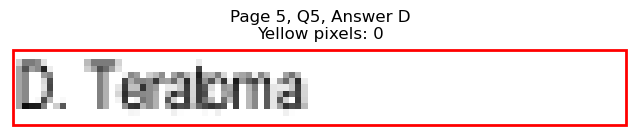

Page 5, Q5 - E: Detected box: x0=322.9, y0=398.5, x1=364.3, y1=410.6
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 180
Page 5, Q5, E: Yellow percentage: 0.0%


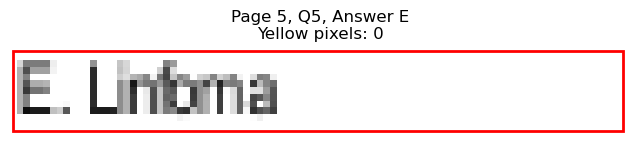


Page 5, Q5 - Selected Answer: C (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.6, y0=458.6, x1=126.3, y1=470.6
Page 5, Q6, A: Yellow pixels: 306
Page 5, Q6, A: Total non-white pixels: 546
Page 5, Q6, A: Yellow percentage: 56.0%


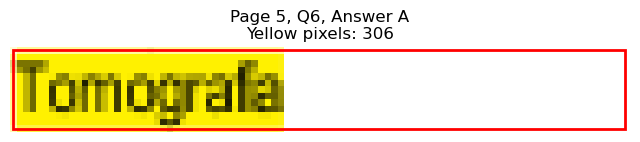

Page 5, Q6 - B: Detected box: x0=71.3, y0=470.6, x1=118.7, y1=482.6
Page 5, Q6, B: Yellow pixels: 41
Page 5, Q6, B: Total non-white pixels: 284
Page 5, Q6, B: Yellow percentage: 14.4%


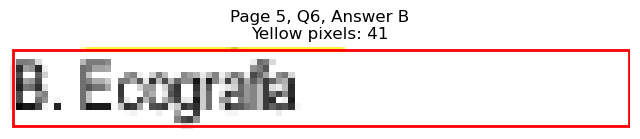

Page 5, Q6 - C: Detected box: x0=71.3, y0=483.4, x1=125.5, y1=495.4
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 274
Page 5, Q6, C: Yellow percentage: 0.0%


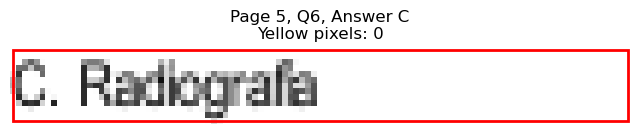

Page 5, Q6 - D: Detected box: x0=322.9, y0=458.6, x1=380.0, y1=470.6
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 289
Page 5, Q6, D: Yellow percentage: 0.0%


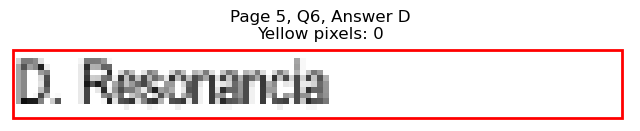

Page 5, Q6 - E: Detected box: x0=322.9, y0=470.6, x1=381.5, y1=482.6
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 260
Page 5, Q6, E: Yellow percentage: 0.0%


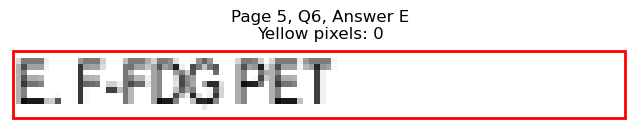


Page 5, Q6 - Selected Answer: A (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=82.6, y0=519.4, x1=105.2, y1=531.4
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 113
Page 5, Q7, A: Yellow percentage: 0.0%


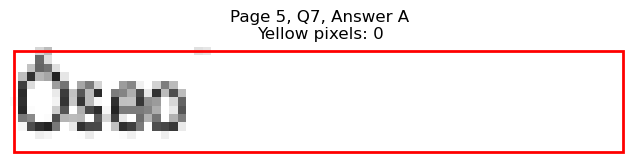

Page 5, Q7 - B: Detected box: x0=71.3, y0=531.4, x1=109.7, y1=543.5
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 203
Page 5, Q7, B: Yellow percentage: 0.0%


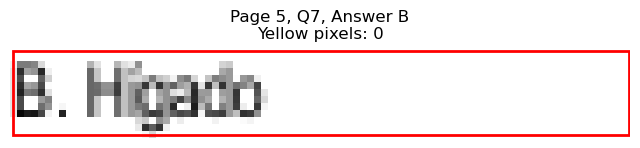

Page 5, Q7 - C: Detected box: x0=71.3, y0=543.4, x1=113.5, y1=555.5
Page 5, Q7, C: Yellow pixels: 378
Page 5, Q7, C: Total non-white pixels: 533
Page 5, Q7, C: Yellow percentage: 70.9%


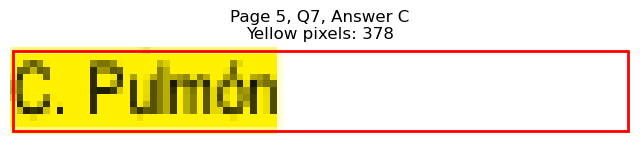

Page 5, Q7 - D: Detected box: x0=322.9, y0=519.4, x1=372.5, y1=531.4
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 233
Page 5, Q7, D: Yellow percentage: 0.0%


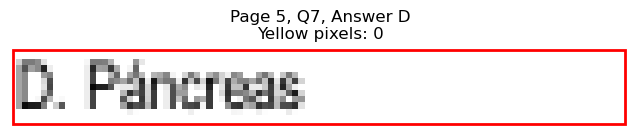

Page 5, Q7 - E: Detected box: x0=322.9, y0=531.4, x1=355.3, y1=543.5
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 143
Page 5, Q7, E: Yellow percentage: 0.0%


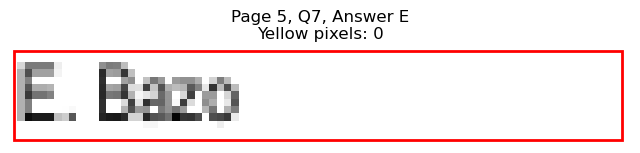


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.6, y0=591.5, x1=91.7, y1=603.5
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 48
Page 5, Q8, A: Yellow percentage: 0.0%


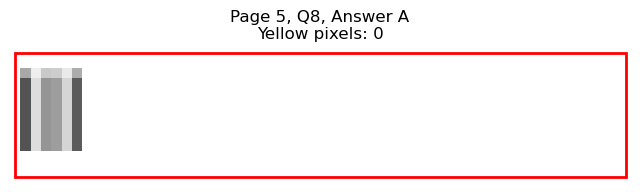

Page 5, Q8 - B: Detected box: x0=71.3, y0=603.5, x1=86.5, y1=615.5
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 58
Page 5, Q8, B: Yellow percentage: 0.0%


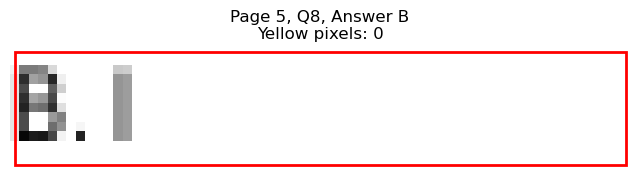

Page 5, Q8 - C: Detected box: x0=71.3, y0=615.5, x1=92.5, y1=627.5
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 73
Page 5, Q8, C: Yellow percentage: 0.0%


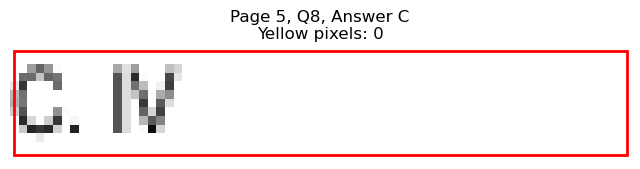

Page 5, Q8 - D: Detected box: x0=322.9, y0=591.5, x1=341.1, y1=603.5
Page 5, Q8, D: Yellow pixels: 157
Page 5, Q8, D: Total non-white pixels: 221
Page 5, Q8, D: Yellow percentage: 71.0%


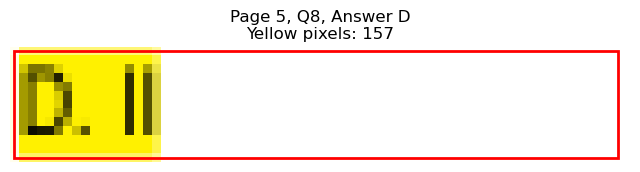

Page 5, Q8 - E: Detected box: x0=322.9, y0=603.5, x1=341.0, y1=615.5
Page 5, Q8, E: Yellow pixels: 16
Page 5, Q8, E: Total non-white pixels: 81
Page 5, Q8, E: Yellow percentage: 19.8%


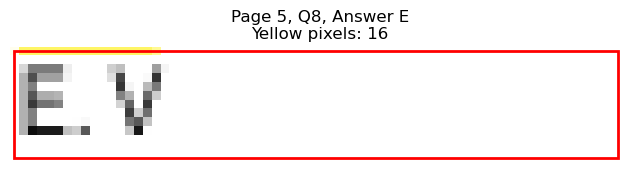


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=82.6, y0=651.5, x1=128.5, y1=663.6
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 233
Page 5, Q9, A: Yellow percentage: 0.0%


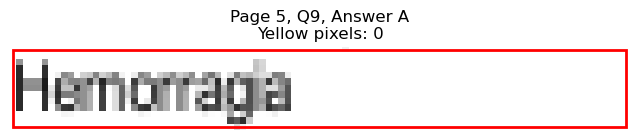

Page 5, Q9 - B: Detected box: x0=71.3, y0=663.5, x1=116.5, y1=675.6
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 224
Page 5, Q9, B: Yellow percentage: 0.0%


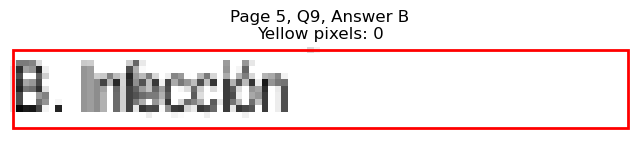

Page 5, Q9 - C: Detected box: x0=71.3, y0=676.3, x1=119.5, y1=688.3
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 229
Page 5, Q9, C: Yellow percentage: 0.0%


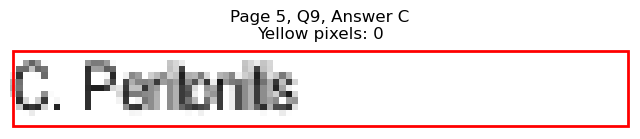

Page 5, Q9 - D: Detected box: x0=322.9, y0=651.5, x1=381.6, y1=663.6
Page 5, Q9, D: Yellow pixels: 503
Page 5, Q9, D: Total non-white pixels: 754
Page 5, Q9, D: Yellow percentage: 66.7%


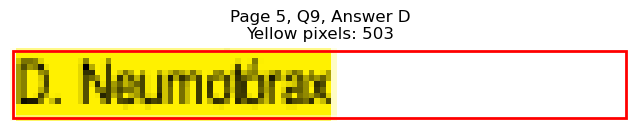

Page 5, Q9 - E: Detected box: x0=322.9, y0=663.5, x1=374.8, y1=675.6
Page 5, Q9, E: Yellow pixels: 56
Page 5, Q9, E: Total non-white pixels: 313
Page 5, Q9, E: Yellow percentage: 17.9%


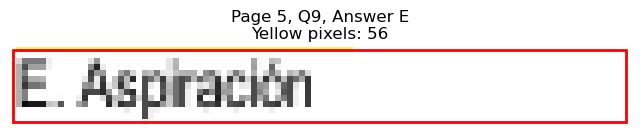


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=82.6, y0=712.3, x1=152.6, y1=724.4
Page 5, Q10, A: Yellow pixels: 517
Page 5, Q10, A: Total non-white pixels: 899
Page 5, Q10, A: Yellow percentage: 57.5%


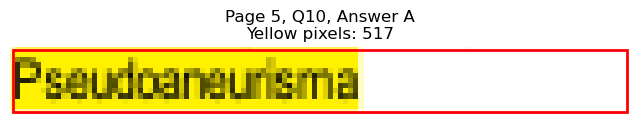

Page 5, Q10 - B: Detected box: x0=71.3, y0=724.3, x1=166.0, y1=736.4
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 540
Page 5, Q10, B: Yellow percentage: 0.0%


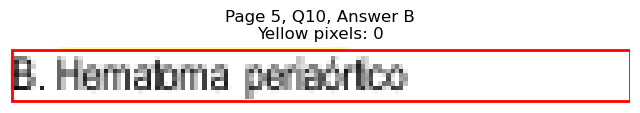

Page 5, Q10 - C: Detected box: x0=71.3, y0=736.4, x1=145.7, y1=748.4
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 353
Page 5, Q10, C: Yellow percentage: 0.0%


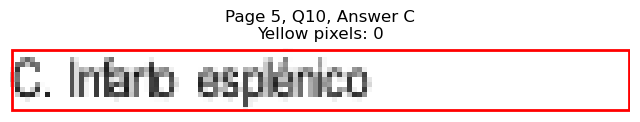

Page 5, Q10 - D: Detected box: x0=322.9, y0=712.3, x1=421.3, y1=724.4
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 465
Page 5, Q10, D: Yellow percentage: 0.0%


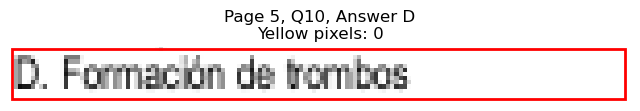

Page 5, Q10 - E: Detected box: x0=322.9, y0=724.3, x1=363.7, y1=736.4
Page 5, Q10, E: Yellow pixels: 0
Page 5, Q10, E: Total non-white pixels: 198
Page 5, Q10, E: Yellow percentage: 0.0%


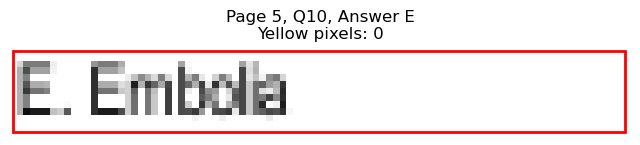


Page 5, Q10 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=147.3, y1=108.8
Page 6, Q1, A: Yellow pixels: 916
Page 6, Q1, A: Total non-white pixels: 1508
Page 6, Q1, A: Yellow percentage: 60.7%


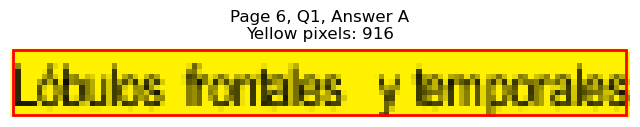

Page 6, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=151.0, y1=121.6
Page 6, Q1, B: Yellow pixels: 115
Page 6, Q1, B: Total non-white pixels: 530
Page 6, Q1, B: Yellow percentage: 21.7%


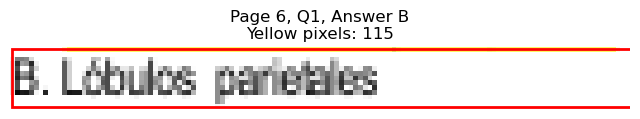

Page 6, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=163.0, y1=133.6
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 418
Page 6, Q1, C: Yellow percentage: 0.0%


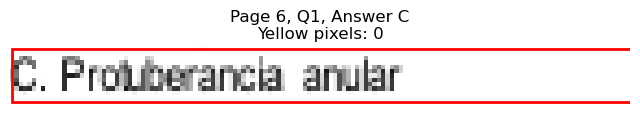

Page 6, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=392.0, y1=108.8
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 352
Page 6, Q1, D: Yellow percentage: 0.0%


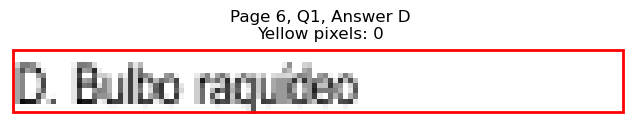

Page 6, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=407.8, y1=121.6
Page 6, Q1, E: Yellow pixels: 0
Page 6, Q1, E: Total non-white pixels: 406
Page 6, Q1, E: Yellow percentage: 0.0%


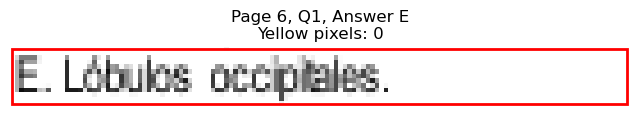


Page 6, Q1 - Selected Answer: A (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=142.7, y1=169.6
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 283
Page 6, Q2, A: Yellow percentage: 0.0%


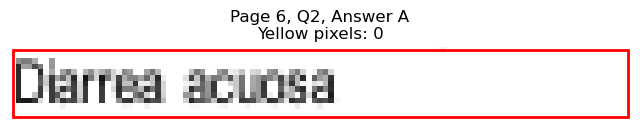

Page 6, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=145.0, y1=181.6
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 357
Page 6, Q2, B: Yellow percentage: 0.0%


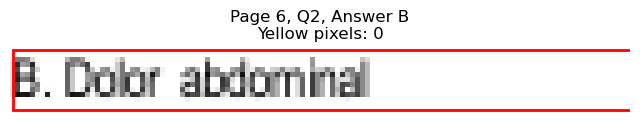

Page 6, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=145.0, y1=193.6
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 327
Page 6, Q2, C: Yellow percentage: 0.0%


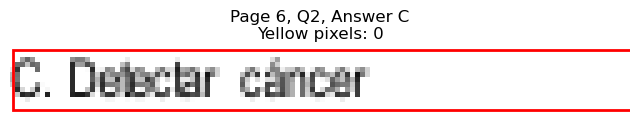

Page 6, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=408.6, y1=169.6
Page 6, Q2, D: Yellow pixels: 649
Page 6, Q2, D: Total non-white pixels: 1105
Page 6, Q2, D: Yellow percentage: 58.7%


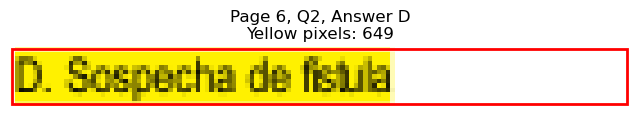

Page 6, Q2 - E: Detected box: x0=322.9, y0=169.6, x1=395.0, y1=181.6
Page 6, Q2, E: Yellow pixels: 83
Page 6, Q2, E: Total non-white pixels: 452
Page 6, Q2, E: Yellow percentage: 18.4%


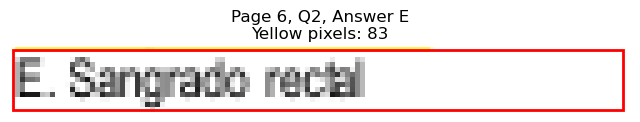


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=140.5, y1=253.7
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 295
Page 6, Q3, A: Yellow percentage: 0.0%


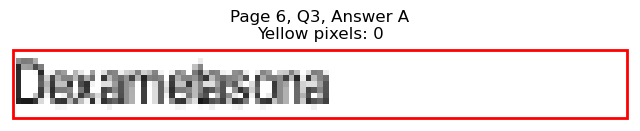

Page 6, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=123.3, y1=265.7
Page 6, Q3, B: Yellow pixels: 397
Page 6, Q3, B: Total non-white pixels: 650
Page 6, Q3, B: Yellow percentage: 61.1%


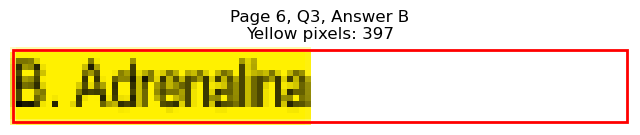

Page 6, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=119.5, y1=277.7
Page 6, Q3, C: Yellow pixels: 50
Page 6, Q3, C: Total non-white pixels: 266
Page 6, Q3, C: Yellow percentage: 18.8%


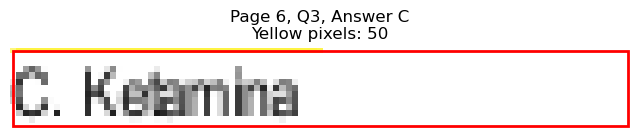

Page 6, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=389.0, y1=253.7
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 334
Page 6, Q3, D: Yellow percentage: 0.0%


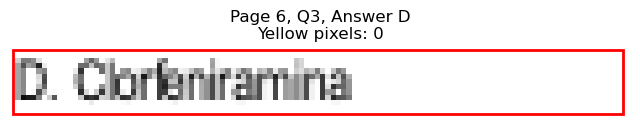

Page 6, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=373.3, y1=265.7
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 238
Page 6, Q3, E: Yellow percentage: 0.0%


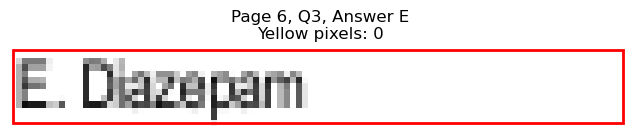


Page 6, Q3 - Selected Answer: B (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=142.0, y1=314.5
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 317
Page 6, Q4, A: Yellow percentage: 0.0%


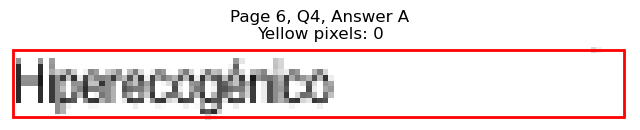

Page 6, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=135.2, y1=326.5
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 339
Page 6, Q4, B: Yellow percentage: 0.0%


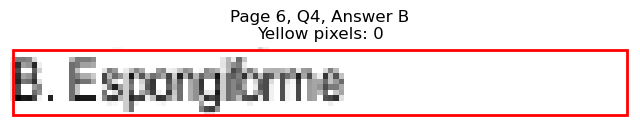

Page 6, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=159.3, y1=338.5
Page 6, Q4, C: Yellow pixels: 809
Page 6, Q4, C: Total non-white pixels: 1118
Page 6, Q4, C: Yellow percentage: 72.4%


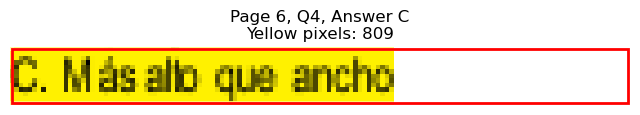

Page 6, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=421.3, y1=314.5
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 501
Page 6, Q4, D: Yellow percentage: 0.0%


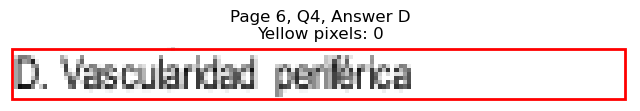

Page 6, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=394.3, y1=326.5
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 363
Page 6, Q4, E: Yellow percentage: 0.0%


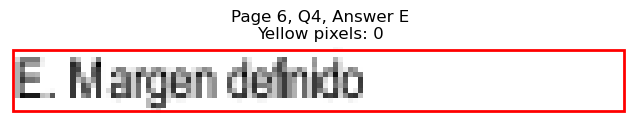


Page 6, Q4 - Selected Answer: C (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=157.8, y1=386.6
Page 6, Q5, A: Yellow pixels: 613
Page 6, Q5, A: Total non-white pixels: 963
Page 6, Q5, A: Yellow percentage: 63.7%


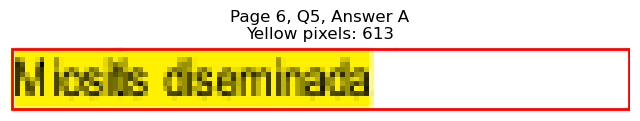

Page 6, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=124.7, y1=398.6
Page 6, Q5, B: Yellow pixels: 72
Page 6, Q5, B: Total non-white pixels: 327
Page 6, Q5, B: Yellow percentage: 22.0%


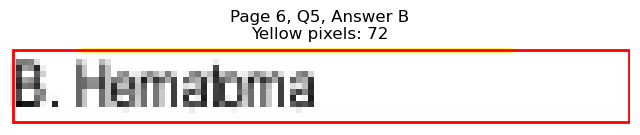

Page 6, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=119.5, y1=410.6
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 206
Page 6, Q5, C: Yellow percentage: 0.0%


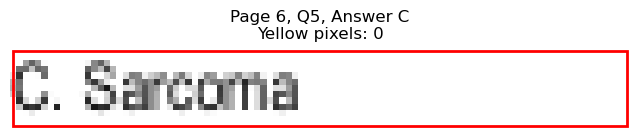

Page 6, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=380.8, y1=386.6
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 302
Page 6, Q5, D: Yellow percentage: 0.0%


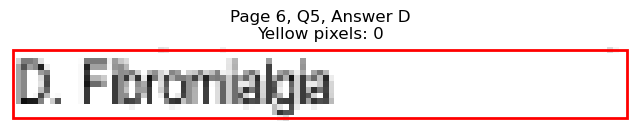

Page 6, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=373.3, y1=398.6
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 424
Page 6, Q5, E: Yellow percentage: 0.0%


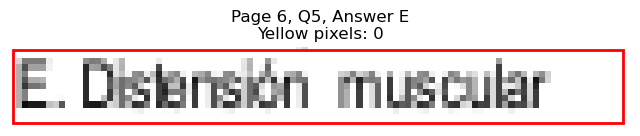


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.6, y0=446.6, x1=98.5, y1=458.6
Page 6, Q6, A: Yellow pixels: 97
Page 6, Q6, A: Total non-white pixels: 196
Page 6, Q6, A: Yellow percentage: 49.5%


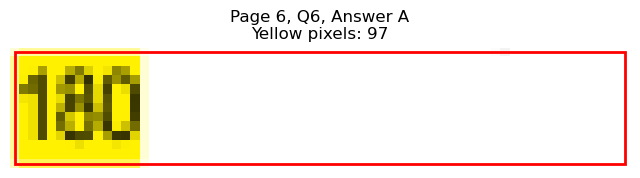

Page 6, Q6 - B: Detected box: x0=71.3, y0=458.6, x1=97.7, y1=470.6
Page 6, Q6, B: Yellow pixels: 13
Page 6, Q6, B: Total non-white pixels: 125
Page 6, Q6, B: Yellow percentage: 10.4%


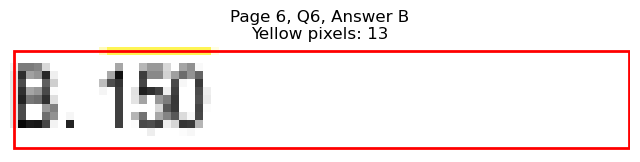

Page 6, Q6 - C: Detected box: x0=71.3, y0=470.6, x1=98.5, y1=482.6
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 98
Page 6, Q6, C: Yellow percentage: 0.0%


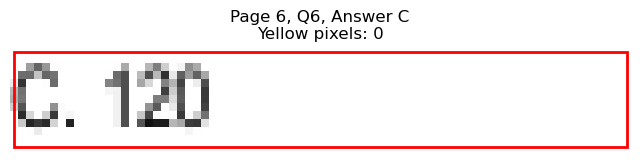

Page 6, Q6 - D: Detected box: x0=322.9, y0=446.6, x1=345.5, y1=458.6
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 100
Page 6, Q6, D: Yellow percentage: 0.0%


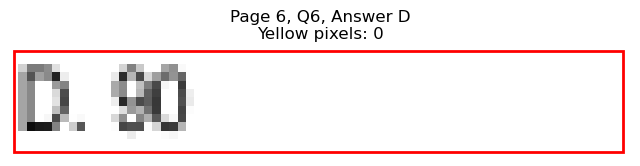

Page 6, Q6 - E: Detected box: x0=322.9, y0=458.6, x1=344.8, y1=470.6
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 101
Page 6, Q6, E: Yellow percentage: 0.0%


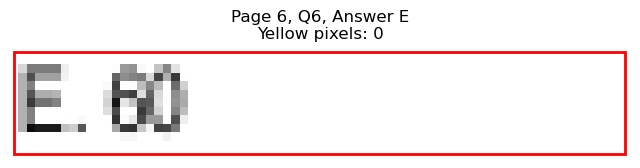


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=71.3, y0=507.4, x1=79.7, y1=519.4
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 52
Page 6, Q7, A: Yellow percentage: 0.0%


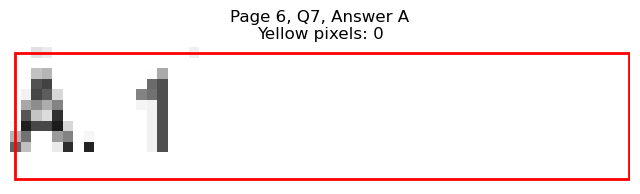

Page 6, Q7 - B: Detected box: x0=71.3, y0=519.4, x1=88.7, y1=531.4
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 71
Page 6, Q7, B: Yellow percentage: 0.0%


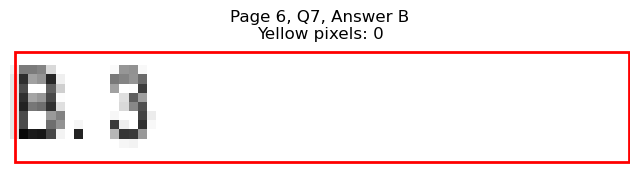

Page 6, Q7 - C: Detected box: x0=71.3, y0=531.4, x1=89.5, y1=543.5
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 57
Page 6, Q7, C: Yellow percentage: 0.0%


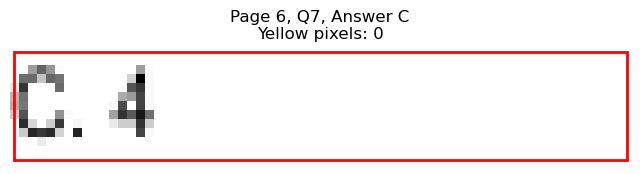

Page 6, Q7 - D: Detected box: x0=322.9, y0=507.4, x1=341.1, y1=519.4
Page 6, Q7, D: Yellow pixels: 150
Page 6, Q7, D: Total non-white pixels: 221
Page 6, Q7, D: Yellow percentage: 67.9%


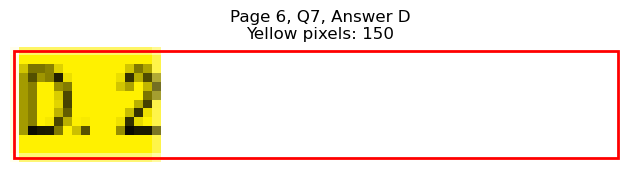

Page 6, Q7 - E: Detected box: x0=322.9, y0=519.4, x1=340.3, y1=531.4
Page 6, Q7, E: Yellow pixels: 15
Page 6, Q7, E: Total non-white pixels: 81
Page 6, Q7, E: Yellow percentage: 18.5%


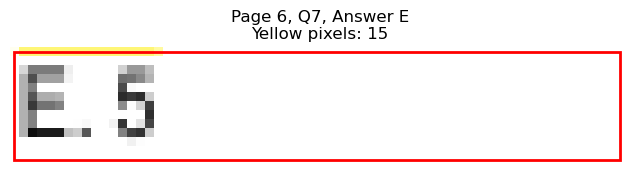


Page 6, Q7 - Selected Answer: D (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=82.6, y0=579.4, x1=113.5, y1=591.5
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 144
Page 6, Q8, A: Yellow percentage: 0.0%


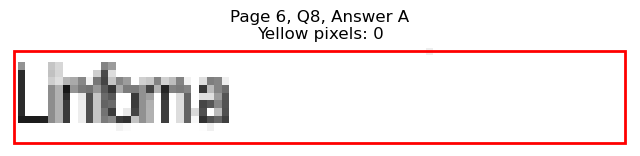

Page 6, Q8 - B: Detected box: x0=71.3, y0=386.5, x1=124.7, y1=398.6
Page 6, Q8, B: Yellow pixels: 72
Page 6, Q8, B: Total non-white pixels: 327
Page 6, Q8, B: Yellow percentage: 22.0%


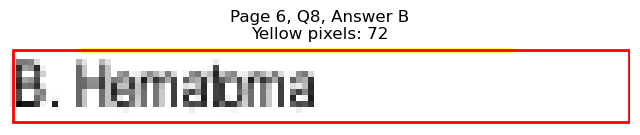

Page 6, Q8 - C: Detected box: x0=71.3, y0=603.5, x1=124.7, y1=615.5
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 258
Page 6, Q8, C: Yellow percentage: 0.0%


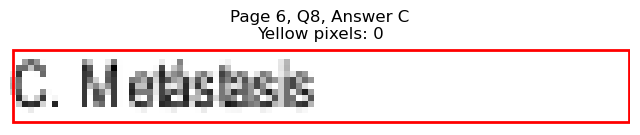

Page 6, Q8 - D: Detected box: x0=322.9, y0=579.4, x1=380.8, y1=591.5
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 269
Page 6, Q8, D: Yellow percentage: 0.0%


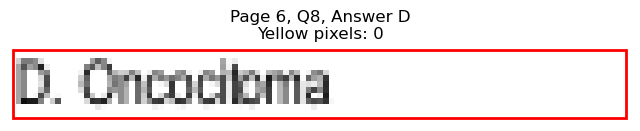

Page 6, Q8 - E: Detected box: x0=322.9, y0=591.5, x1=394.4, y1=603.5
Page 6, Q8, E: Yellow pixels: 601
Page 6, Q8, E: Total non-white pixels: 910
Page 6, Q8, E: Yellow percentage: 66.0%


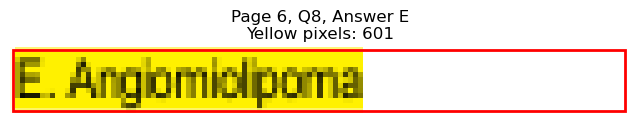


Page 6, Q8 - Selected Answer: E (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=82.6, y0=639.5, x1=94.0, y1=651.6
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 39
Page 6, Q9, A: Yellow percentage: 0.0%


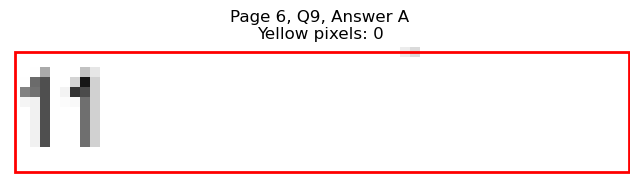

Page 6, Q9 - B: Detected box: x0=71.3, y0=651.5, x1=93.2, y1=663.6
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 84
Page 6, Q9, B: Yellow percentage: 0.0%


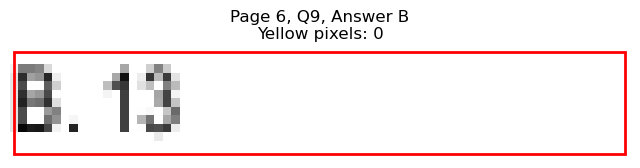

Page 6, Q9 - C: Detected box: x0=71.3, y0=663.5, x1=89.5, y1=675.6
Page 6, Q9, C: Yellow pixels: 143
Page 6, Q9, C: Total non-white pixels: 221
Page 6, Q9, C: Yellow percentage: 64.7%


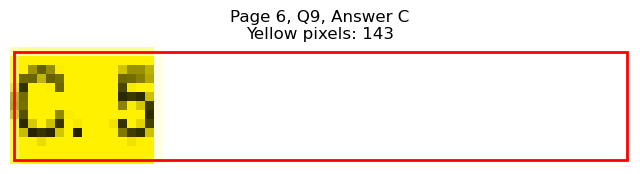

Page 6, Q9 - D: Detected box: x0=322.9, y0=639.5, x1=341.0, y1=651.6
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 65
Page 6, Q9, D: Yellow percentage: 0.0%


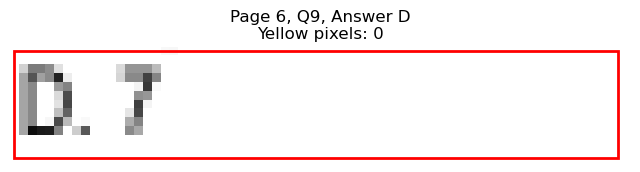

Page 6, Q9 - E: Detected box: x0=322.9, y0=651.5, x1=340.3, y1=663.6
Page 6, Q9, E: Yellow pixels: 0
Page 6, Q9, E: Total non-white pixels: 67
Page 6, Q9, E: Yellow percentage: 0.0%


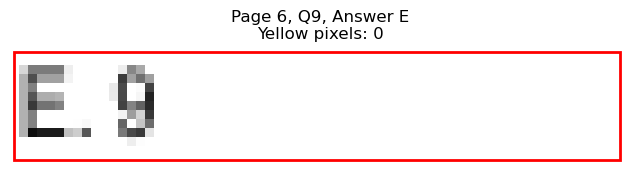


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=82.6, y0=700.3, x1=150.3, y1=712.3
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 360
Page 6, Q10, A: Yellow percentage: 0.0%


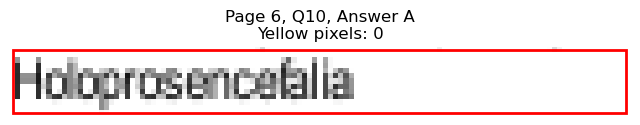

Page 6, Q10 - B: Detected box: x0=71.3, y0=712.3, x1=171.2, y1=724.4
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 491
Page 6, Q10, B: Yellow percentage: 0.0%


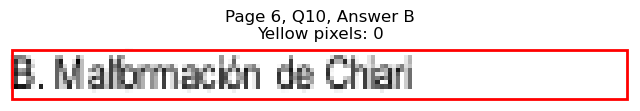

Page 6, Q10 - C: Detected box: x0=71.3, y0=724.3, x1=202.1, y1=736.4
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 642
Page 6, Q10, C: Yellow percentage: 0.0%


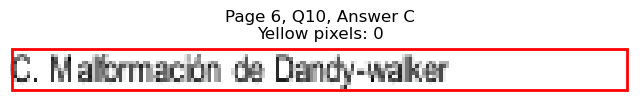

Page 6, Q10 - D: Detected box: x0=322.9, y0=700.3, x1=378.6, y1=712.3
Page 6, Q10, D: Yellow pixels: 405
Page 6, Q10, D: Total non-white pixels: 715
Page 6, Q10, D: Yellow percentage: 56.6%


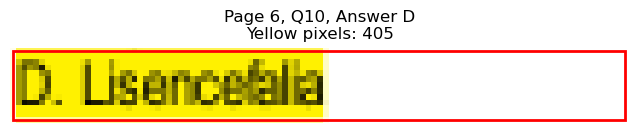

Page 6, Q10 - E: Detected box: x0=322.9, y0=712.3, x1=453.0, y1=724.4
Page 6, Q10, E: Yellow pixels: 0
Page 6, Q10, E: Total non-white pixels: 677
Page 6, Q10, E: Yellow percentage: 0.0%


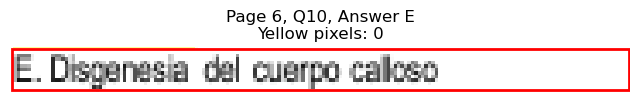


Page 6, Q10 - Selected Answer: D (based on yellow pixel count)





Page 7: Found 11 questions
Page 7, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=235.7, y1=108.8
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 769
Page 7, Q1, A: Yellow percentage: 0.0%


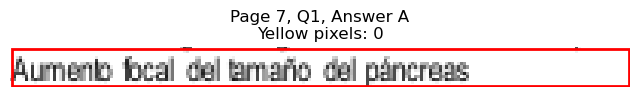

Page 7, Q1 - B: Detected box: x0=122.3, y0=109.5, x1=217.7, y1=121.6
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 486
Page 7, Q1, B: Yellow percentage: 0.0%


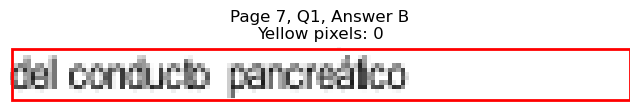

Page 7, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=261.2, y1=133.6
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 909
Page 7, Q1, C: Yellow percentage: 0.0%


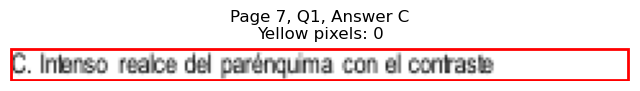

Page 7, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=390.5, y1=108.8
Page 7, Q1, D: Yellow pixels: 939
Page 7, Q1, D: Total non-white pixels: 1547
Page 7, Q1, D: Yellow percentage: 60.7%


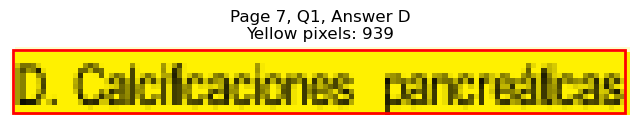

Page 7, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=467.0, y1=121.6
Page 7, Q1, E: Yellow pixels: 167
Page 7, Q1, E: Total non-white pixels: 884
Page 7, Q1, E: Yellow percentage: 18.9%


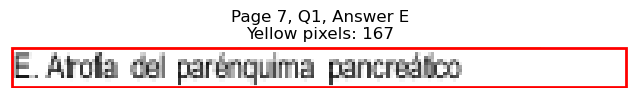


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.6, y0=543.4, x1=126.3, y1=555.5
Page 7, Q2, A: Yellow pixels: 346
Page 7, Q2, A: Total non-white pixels: 546
Page 7, Q2, A: Yellow percentage: 63.4%


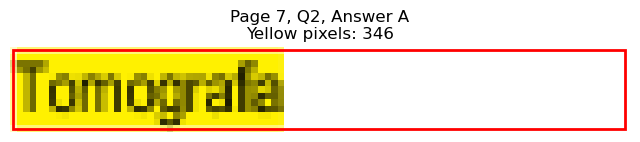

Page 7, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=172.9, y1=181.6
Page 7, Q2, B: Yellow pixels: 788
Page 7, Q2, B: Total non-white pixels: 1300
Page 7, Q2, B: Yellow percentage: 60.6%


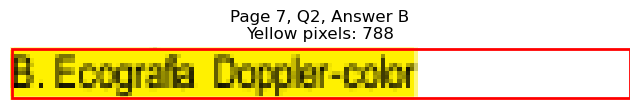

Page 7, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=135.3, y1=193.6
Page 7, Q2, C: Yellow pixels: 99
Page 7, Q2, C: Total non-white pixels: 631
Page 7, Q2, C: Yellow percentage: 15.7%


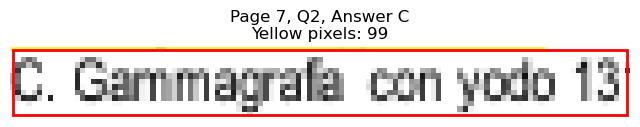

Page 7, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=380.0, y1=169.6
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 295
Page 7, Q2, D: Yellow percentage: 0.0%


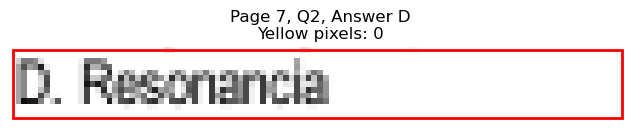

Page 7, Q2 - E: Detected box: x0=322.9, y0=169.6, x1=395.8, y1=181.6
Page 7, Q2, E: Yellow pixels: 0
Page 7, Q2, E: Total non-white pixels: 363
Page 7, Q2, E: Yellow percentage: 0.0%


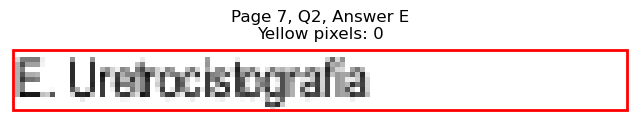


Page 7, Q2 - Selected Answer: B (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.6, y0=229.6, x1=125.5, y1=241.7
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 208
Page 7, Q3, A: Yellow percentage: 0.0%


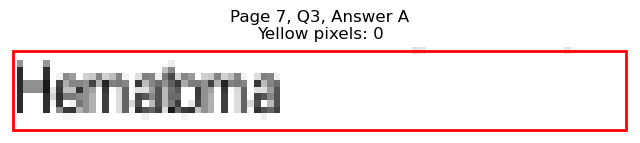

Page 7, Q3 - B: Detected box: x0=71.3, y0=241.6, x1=118.7, y1=253.7
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 229
Page 7, Q3, B: Yellow percentage: 0.0%


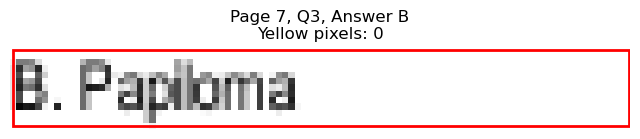

Page 7, Q3 - C: Detected box: x0=71.3, y0=253.6, x1=126.2, y1=265.7
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 258
Page 7, Q3, C: Yellow percentage: 0.0%


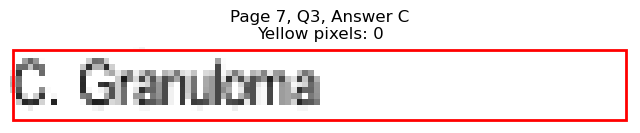

Page 7, Q3 - D: Detected box: x0=322.9, y0=229.6, x1=380.1, y1=241.7
Page 7, Q3, D: Yellow pixels: 444
Page 7, Q3, D: Total non-white pixels: 730
Page 7, Q3, D: Yellow percentage: 60.8%


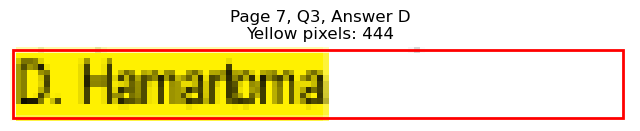

Page 7, Q3 - E: Detected box: x0=322.9, y0=241.6, x1=375.5, y1=253.7
Page 7, Q3, E: Yellow pixels: 55
Page 7, Q3, E: Total non-white pixels: 325
Page 7, Q3, E: Yellow percentage: 16.9%


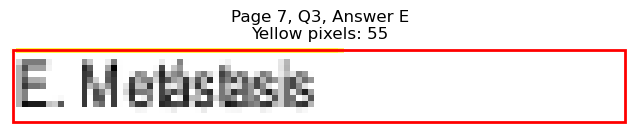


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=82.6, y0=289.7, x1=112.0, y1=301.8
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 144
Page 7, Q4, A: Yellow percentage: 0.0%


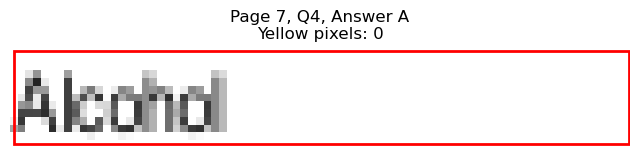

Page 7, Q4 - B: Detected box: x0=71.3, y0=302.5, x1=114.2, y1=314.5
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 209
Page 7, Q4, B: Yellow percentage: 0.0%


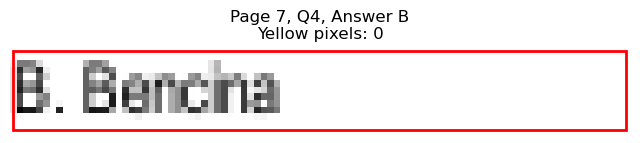

Page 7, Q4 - C: Detected box: x0=71.3, y0=314.5, x1=104.5, y1=326.5
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 127
Page 7, Q4, C: Yellow percentage: 0.0%


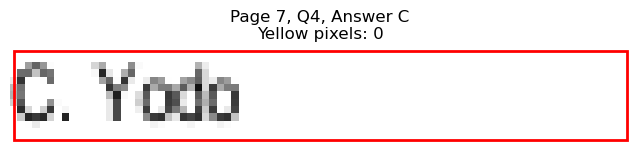

Page 7, Q4 - D: Detected box: x0=322.9, y0=289.7, x1=362.8, y1=301.8
Page 7, Q4, D: Yellow pixels: 314
Page 7, Q4, D: Total non-white pixels: 510
Page 7, Q4, D: Yellow percentage: 61.6%


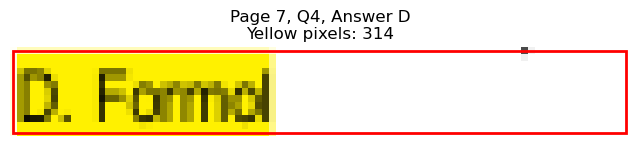

Page 7, Q4 - E: Detected box: x0=322.9, y0=302.5, x1=355.3, y1=314.5
Page 7, Q4, E: Yellow pixels: 37
Page 7, Q4, E: Total non-white pixels: 191
Page 7, Q4, E: Yellow percentage: 19.4%


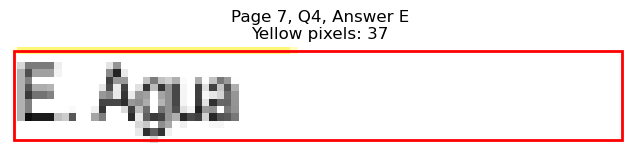


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.6, y0=350.5, x1=181.0, y1=362.5
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 477
Page 7, Q5, A: Yellow percentage: 0.0%


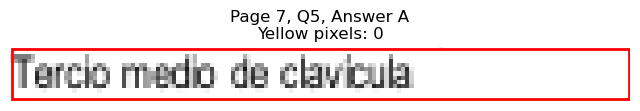

Page 7, Q5 - B: Detected box: x0=71.3, y0=362.5, x1=131.5, y1=374.6
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 313
Page 7, Q5, B: Yellow percentage: 0.0%


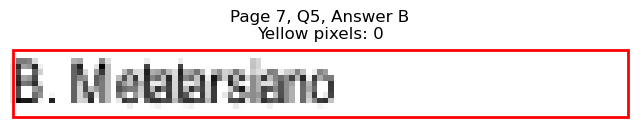

Page 7, Q5 - C: Detected box: x0=71.3, y0=374.5, x1=184.1, y1=386.6
Page 7, Q5, C: Yellow pixels: 1014
Page 7, Q5, C: Total non-white pixels: 1443
Page 7, Q5, C: Yellow percentage: 70.3%


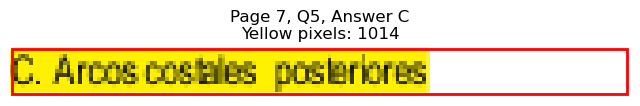

Page 7, Q5 - D: Detected box: x0=322.9, y0=350.5, x1=402.5, y1=362.5
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 410
Page 7, Q5, D: Yellow percentage: 0.0%


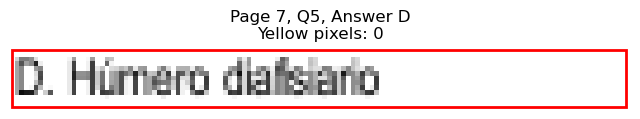

Page 7, Q5 - E: Detected box: x0=322.9, y0=362.5, x1=393.5, y1=374.6
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 337
Page 7, Q5, E: Yellow percentage: 0.0%


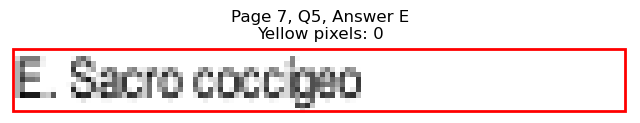


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.6, y0=410.5, x1=143.5, y1=422.6
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 578
Page 7, Q6, A: Yellow percentage: 0.0%


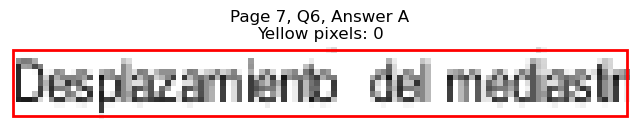

Page 7, Q6 - B: Detected box: x0=71.3, y0=422.5, x1=168.2, y1=434.6
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 655
Page 7, Q6, B: Yellow percentage: 0.0%


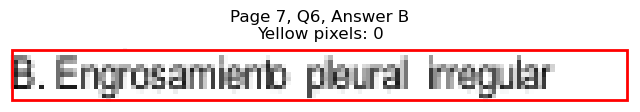

Page 7, Q6 - C: Detected box: x0=71.3, y0=434.6, x1=214.0, y1=446.6
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 680
Page 7, Q6, C: Yellow percentage: 0.0%


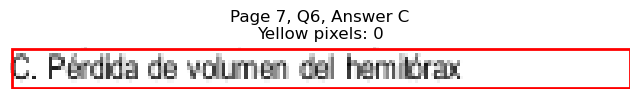

Page 7, Q6 - D: Detected box: x0=322.9, y0=410.5, x1=430.4, y1=422.6
Page 7, Q6, D: Yellow pixels: 838
Page 7, Q6, D: Total non-white pixels: 1391
Page 7, Q6, D: Yellow percentage: 60.2%


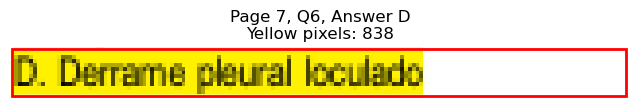

Page 7, Q6 - E: Detected box: x0=322.9, y0=422.5, x1=435.5, y1=434.6
Page 7, Q6, E: Yellow pixels: 105
Page 7, Q6, E: Total non-white pixels: 655
Page 7, Q6, E: Yellow percentage: 16.0%


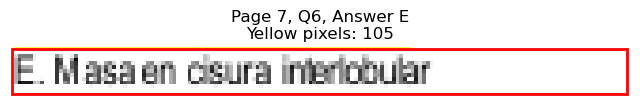


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.6, y0=470.6, x1=94.0, y1=482.6
Page 7, Q7, A: Yellow pixels: 72
Page 7, Q7, A: Total non-white pixels: 130
Page 7, Q7, A: Yellow percentage: 55.4%


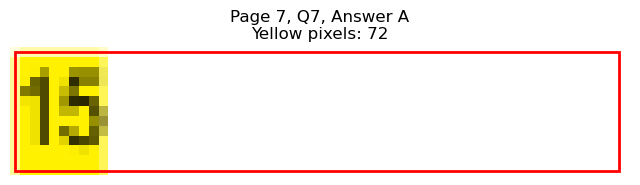

Page 7, Q7 - B: Detected box: x0=71.3, y0=483.4, x1=93.2, y1=495.4
Page 7, Q7, B: Yellow pixels: 8
Page 7, Q7, B: Total non-white pixels: 110
Page 7, Q7, B: Yellow percentage: 7.3%


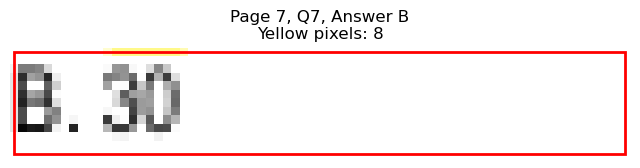

Page 7, Q7 - C: Detected box: x0=71.3, y0=495.4, x1=94.0, y1=507.4
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 87
Page 7, Q7, C: Yellow percentage: 0.0%


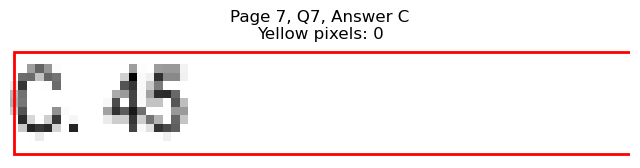

Page 7, Q7 - D: Detected box: x0=322.9, y0=470.6, x1=345.5, y1=482.6
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 102
Page 7, Q7, D: Yellow percentage: 0.0%


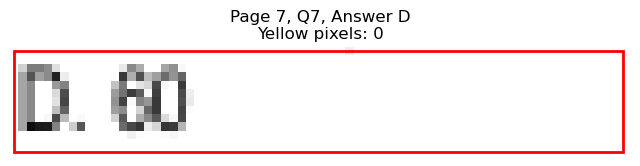

Page 7, Q7 - E: Detected box: x0=322.9, y0=483.4, x1=344.8, y1=495.4
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 88
Page 7, Q7, E: Yellow percentage: 0.0%


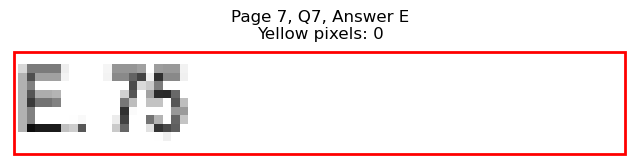


Page 7, Q7 - Selected Answer: A (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=82.6, y0=543.4, x1=126.3, y1=555.5
Page 7, Q8, A: Yellow pixels: 346
Page 7, Q8, A: Total non-white pixels: 546
Page 7, Q8, A: Yellow percentage: 63.4%


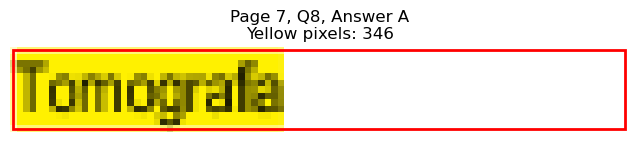

Page 7, Q8 - B: Detected box: x0=71.3, y0=555.4, x1=115.8, y1=567.5
Page 7, Q8, B: Yellow pixels: 41
Page 7, Q8, B: Total non-white pixels: 224
Page 7, Q8, B: Yellow percentage: 18.3%


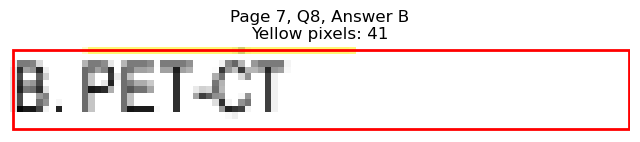

Page 7, Q8 - C: Detected box: x0=71.3, y0=567.5, x1=119.5, y1=579.5
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 228
Page 7, Q8, C: Yellow percentage: 0.0%


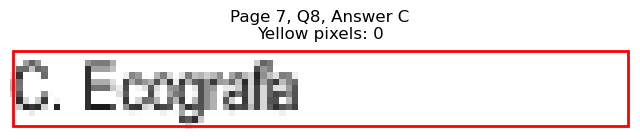

Page 7, Q8 - D: Detected box: x0=322.9, y0=543.4, x1=377.0, y1=555.5
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 293
Page 7, Q8, D: Yellow percentage: 0.0%


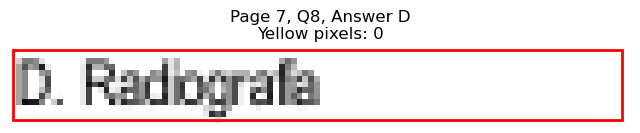

Page 7, Q8 - E: Detected box: x0=322.9, y0=555.4, x1=379.3, y1=567.5
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 279
Page 7, Q8, E: Yellow percentage: 0.0%


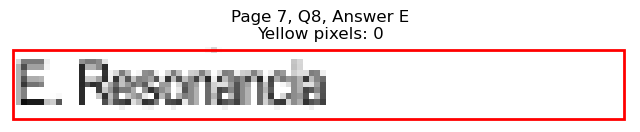


Page 7, Q8 - Selected Answer: A (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=82.6, y0=603.5, x1=135.2, y1=615.5
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 288
Page 7, Q9, A: Yellow percentage: 0.0%


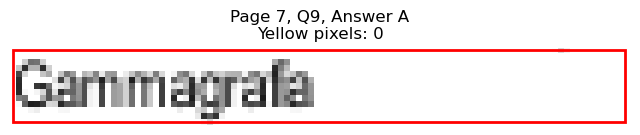

Page 7, Q9 - B: Detected box: x0=71.3, y0=615.5, x1=131.5, y1=627.5
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 300
Page 7, Q9, B: Yellow percentage: 0.0%


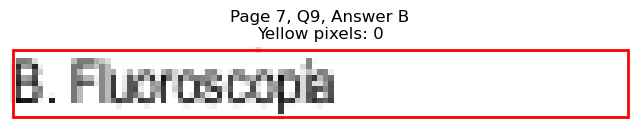

Page 7, Q9 - C: Detected box: x0=71.3, y0=627.5, x1=128.5, y1=639.6
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 268
Page 7, Q9, C: Yellow percentage: 0.0%


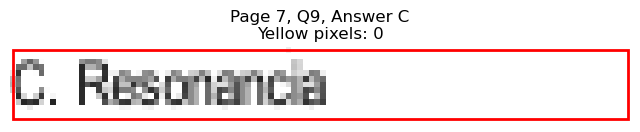

Page 7, Q9 - D: Detected box: x0=322.9, y0=603.5, x1=371.1, y1=615.5
Page 7, Q9, D: Yellow pixels: 402
Page 7, Q9, D: Total non-white pixels: 611
Page 7, Q9, D: Yellow percentage: 65.8%


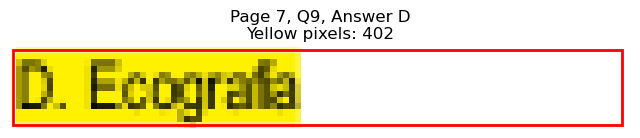

Page 7, Q9 - E: Detected box: x0=322.9, y0=615.5, x1=376.3, y1=627.5
Page 7, Q9, E: Yellow pixels: 46
Page 7, Q9, E: Total non-white pixels: 331
Page 7, Q9, E: Yellow percentage: 13.9%


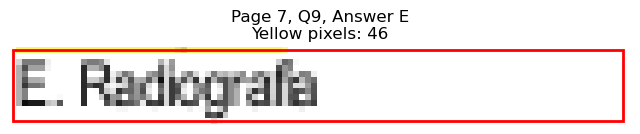


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=82.6, y0=676.3, x1=106.0, y1=688.3
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 113
Page 7, Q10, A: Yellow percentage: 0.0%


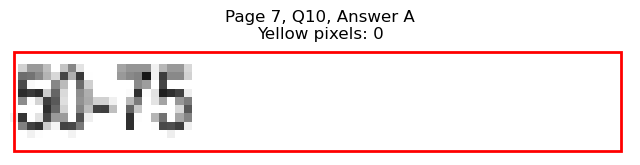

Page 7, Q10 - B: Detected box: x0=71.3, y0=688.3, x1=114.3, y1=700.3
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 215
Page 7, Q10, B: Yellow percentage: 0.0%


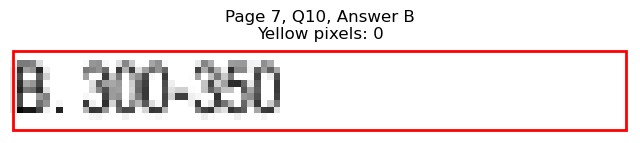

Page 7, Q10 - C: Detected box: x0=71.3, y0=700.3, x1=106.0, y1=712.3
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 158
Page 7, Q10, C: Yellow percentage: 0.0%


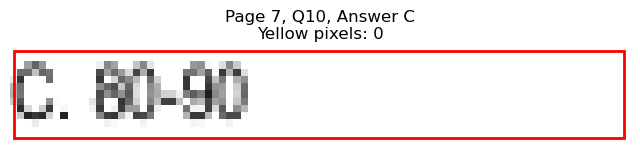

Page 7, Q10 - D: Detected box: x0=322.9, y0=676.3, x1=366.6, y1=688.3
Page 7, Q10, D: Yellow pixels: 331
Page 7, Q10, D: Total non-white pixels: 559
Page 7, Q10, D: Yellow percentage: 59.2%


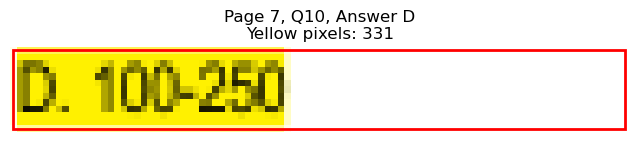

Page 7, Q10 - E: Detected box: x0=322.9, y0=688.3, x1=356.8, y1=700.3
Page 7, Q10, E: Yellow pixels: 0
Page 7, Q10, E: Total non-white pixels: 203
Page 7, Q10, E: Yellow percentage: 0.0%


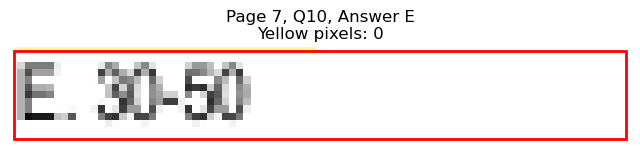


Page 7, Q10 - Selected Answer: D (based on yellow pixel count)




Page 7, Q11 - A: Detected box: x0=82.6, y0=736.4, x1=154.7, y1=748.4
Page 7, Q11, A: Yellow pixels: 0
Page 7, Q11, A: Total non-white pixels: 324
Page 7, Q11, A: Yellow percentage: 0.0%


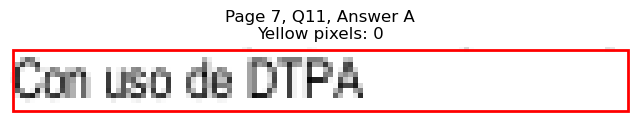

Page 7, Q11 - B: Detected box: x0=71.3, y0=748.4, x1=171.2, y1=760.4
Page 7, Q11, B: Yellow pixels: 1373
Page 7, Q11, B: Total non-white pixels: 1963
Page 7, Q11, B: Yellow percentage: 69.9%


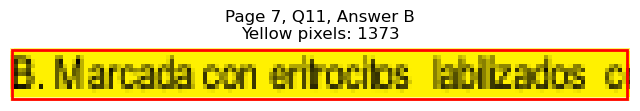

Page 7, Q11 - C: Detected box: x0=140.4, y0=760.4, x1=232.0, y1=772.4
Page 7, Q11, C: Yellow pixels: 110
Page 7, Q11, C: Total non-white pixels: 524
Page 7, Q11, C: Yellow percentage: 21.0%


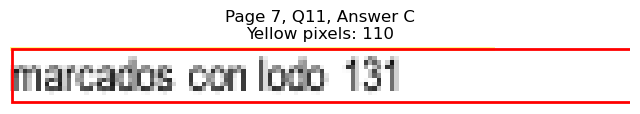

Page 7, Q11 - D: Detected box: x0=391.9, y0=736.4, x1=504.5, y1=748.4
Page 7, Q11, D: Yellow pixels: 0
Page 7, Q11, D: Total non-white pixels: 540
Page 7, Q11, D: Yellow percentage: 0.0%


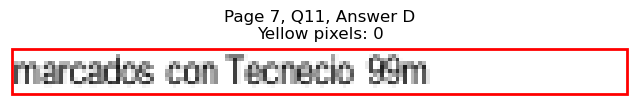

Page 7, Q11 - E: Detected box: x0=322.9, y0=748.4, x1=420.7, y1=760.4
Page 7, Q11, E: Yellow pixels: 0
Page 7, Q11, E: Total non-white pixels: 429
Page 7, Q11, E: Yellow percentage: 0.0%


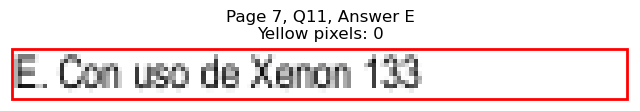


Page 7, Q11 - Selected Answer: B (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=121.0, y1=108.8
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 171
Page 8, Q1, A: Yellow percentage: 0.0%


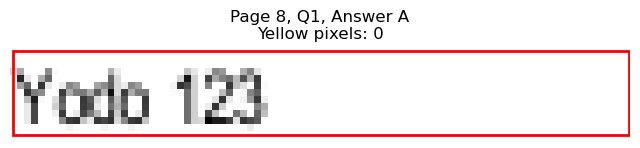

Page 8, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=113.5, y1=121.6
Page 8, Q1, B: Yellow pixels: 375
Page 8, Q1, B: Total non-white pixels: 533
Page 8, Q1, B: Yellow percentage: 70.4%


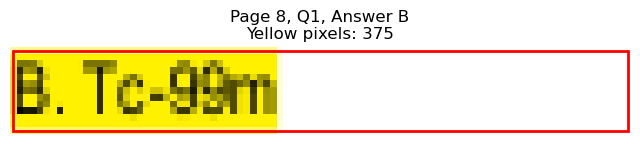

Page 8, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=116.5, y1=133.6
Page 8, Q1, C: Yellow pixels: 40
Page 8, Q1, C: Total non-white pixels: 235
Page 8, Q1, C: Yellow percentage: 17.0%


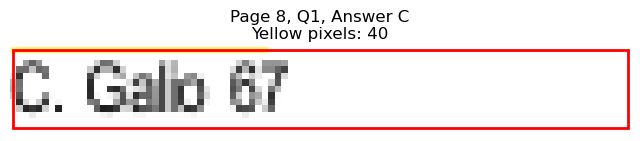

Page 8, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=371.0, y1=108.8
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 212
Page 8, Q1, D: Yellow percentage: 0.0%


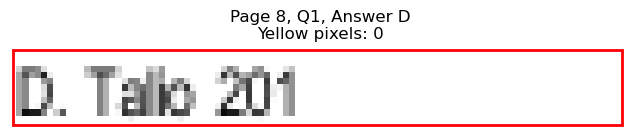

Page 8, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=370.3, y1=121.6
Page 8, Q1, E: Yellow pixels: 0
Page 8, Q1, E: Total non-white pixels: 194
Page 8, Q1, E: Yellow percentage: 0.0%


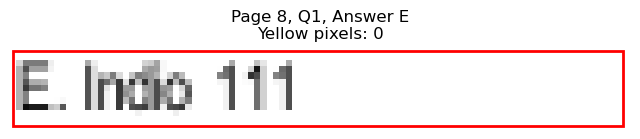


Page 8, Q1 - Selected Answer: B (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.6, y0=157.6, x1=112.8, y1=169.6
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 144
Page 8, Q2, A: Yellow percentage: 0.0%


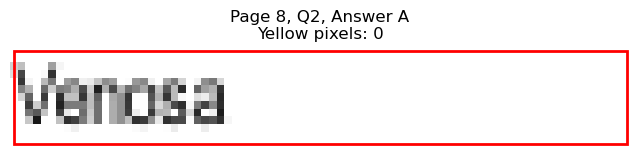

Page 8, Q2 - B: Detected box: x0=71.3, y0=169.6, x1=127.7, y1=181.6
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 300
Page 8, Q2, B: Yellow percentage: 0.0%


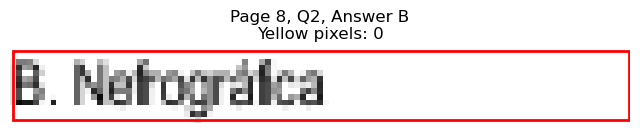

Page 8, Q2 - C: Detected box: x0=71.3, y0=181.6, x1=140.6, y1=193.6
Page 8, Q2, C: Yellow pixels: 542
Page 8, Q2, C: Total non-white pixels: 884
Page 8, Q2, C: Yellow percentage: 61.3%


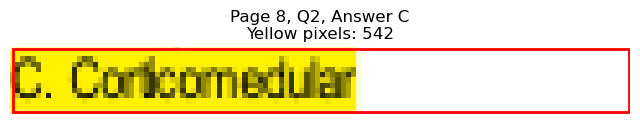

Page 8, Q2 - D: Detected box: x0=322.9, y0=157.6, x1=372.5, y1=169.6
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 233
Page 8, Q2, D: Yellow percentage: 0.0%


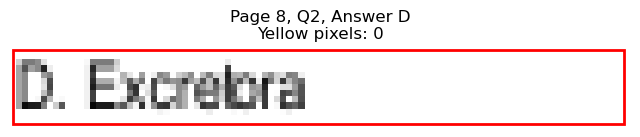

Page 8, Q2 - E: Detected box: x0=322.9, y0=169.6, x1=356.8, y1=181.6
Page 8, Q2, E: Yellow pixels: 0
Page 8, Q2, E: Total non-white pixels: 155
Page 8, Q2, E: Yellow percentage: 0.0%


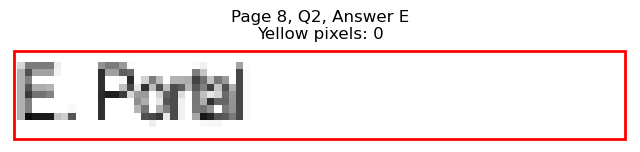


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.6, y0=229.6, x1=128.5, y1=241.7
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 238
Page 8, Q3, A: Yellow percentage: 0.0%


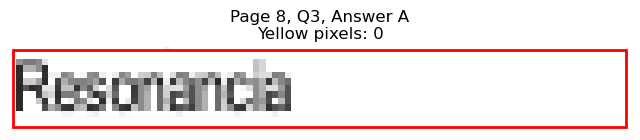

Page 8, Q3 - B: Detected box: x0=128.4, y0=241.6, x1=184.8, y1=253.7
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 303
Page 8, Q3, B: Yellow percentage: 0.0%


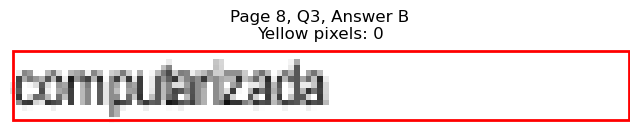

Page 8, Q3 - C: Detected box: x0=71.3, y0=253.6, x1=125.5, y1=265.7
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 418
Page 8, Q3, C: Yellow percentage: 0.0%


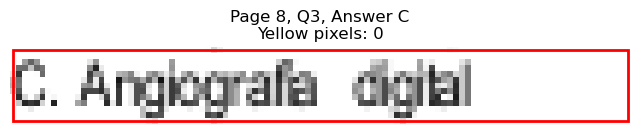

Page 8, Q3 - D: Detected box: x0=380.7, y0=229.6, x1=479.2, y1=241.7
Page 8, Q3, D: Yellow pixels: 756
Page 8, Q3, D: Total non-white pixels: 1261
Page 8, Q3, D: Yellow percentage: 60.0%


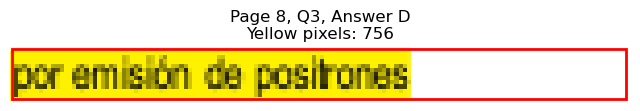

Page 8, Q3 - E: Detected box: x0=322.9, y0=241.6, x1=435.5, y1=253.7
Page 8, Q3, E: Yellow pixels: 154
Page 8, Q3, E: Total non-white pixels: 717
Page 8, Q3, E: Yellow percentage: 21.5%


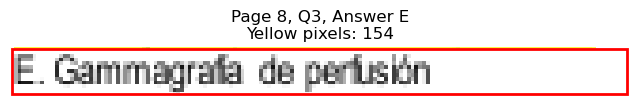


Page 8, Q3 - Selected Answer: D (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=124.0, y1=326.5
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 220
Page 8, Q4, A: Yellow percentage: 0.0%


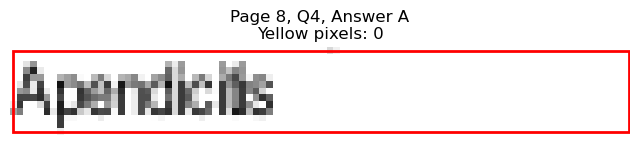

Page 8, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=139.0, y1=338.5
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 345
Page 8, Q4, B: Yellow percentage: 0.0%


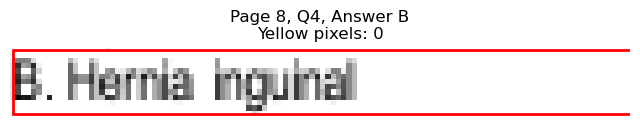

Page 8, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=139.8, y1=350.5
Page 8, Q4, C: Yellow pixels: 620
Page 8, Q4, C: Total non-white pixels: 871
Page 8, Q4, C: Yellow percentage: 71.2%


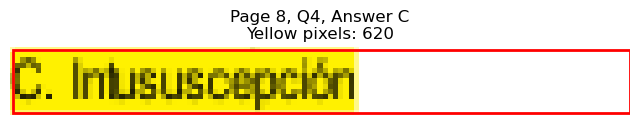

Page 8, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=362.8, y1=326.5
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 187
Page 8, Q4, D: Yellow percentage: 0.0%


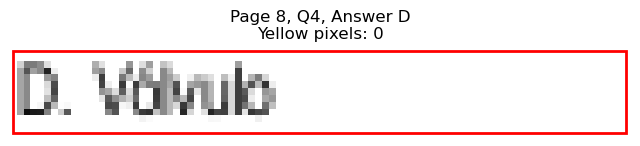

Page 8, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=382.3, y1=338.5
Page 8, Q4, E: Yellow pixels: 0
Page 8, Q4, E: Total non-white pixels: 296
Page 8, Q4, E: Yellow percentage: 0.0%


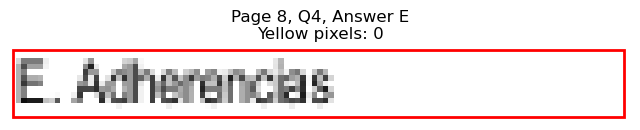


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=82.6, y0=386.5, x1=91.0, y1=398.6
Page 8, Q5, A: Yellow pixels: 52
Page 8, Q5, A: Total non-white pixels: 94
Page 8, Q5, A: Yellow percentage: 55.3%


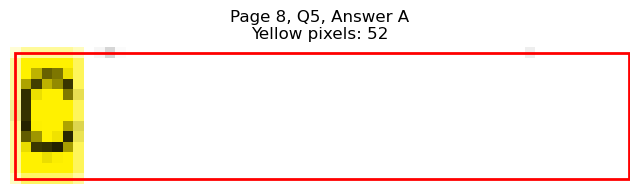

Page 8, Q5 - B: Detected box: x0=71.3, y0=398.5, x1=90.2, y1=410.6
Page 8, Q5, B: Yellow pixels: 5
Page 8, Q5, B: Total non-white pixels: 78
Page 8, Q5, B: Yellow percentage: 6.4%


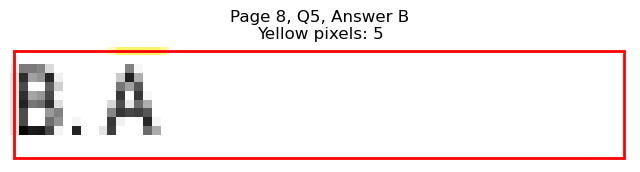

Page 8, Q5 - C: Detected box: x0=71.3, y0=410.5, x1=91.0, y1=422.6
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 63
Page 8, Q5, C: Yellow percentage: 0.0%


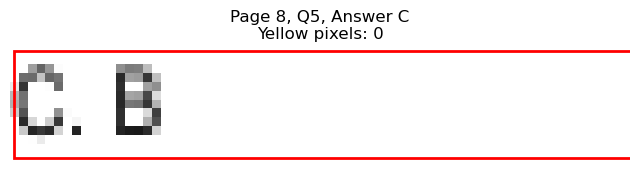

Page 8, Q5 - D: Detected box: x0=322.9, y0=386.5, x1=342.5, y1=398.6
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 75
Page 8, Q5, D: Yellow percentage: 0.0%


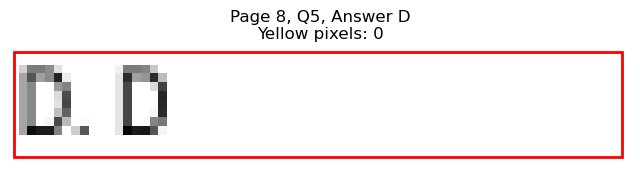

Page 8, Q5 - E: Detected box: x0=322.9, y0=398.5, x1=341.8, y1=410.6
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 65
Page 8, Q5, E: Yellow percentage: 0.0%


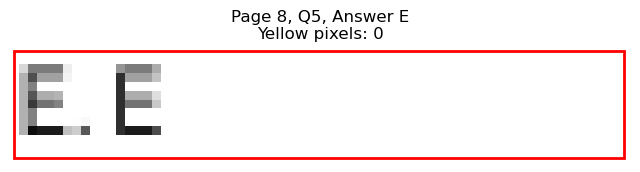


Page 8, Q5 - Selected Answer: A (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.6, y0=446.6, x1=135.2, y1=458.6
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 288
Page 8, Q6, A: Yellow percentage: 0.0%


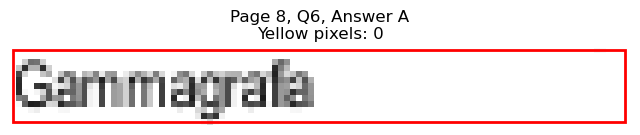

Page 8, Q6 - B: Detected box: x0=71.3, y0=458.6, x1=124.8, y1=470.6
Page 8, Q6, B: Yellow pixels: 377
Page 8, Q6, B: Total non-white pixels: 676
Page 8, Q6, B: Yellow percentage: 55.8%


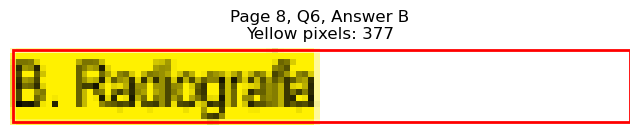

Page 8, Q6 - C: Detected box: x0=71.3, y0=470.6, x1=128.5, y1=482.6
Page 8, Q6, C: Yellow pixels: 51
Page 8, Q6, C: Total non-white pixels: 319
Page 8, Q6, C: Yellow percentage: 16.0%


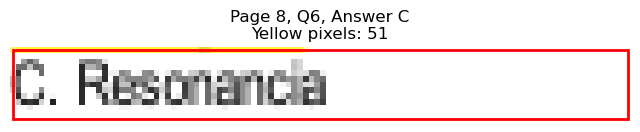

Page 8, Q6 - D: Detected box: x0=322.9, y0=229.6, x1=377.9, y1=241.7
Page 8, Q6, D: Yellow pixels: 842
Page 8, Q6, D: Total non-white pixels: 1378
Page 8, Q6, D: Yellow percentage: 61.1%


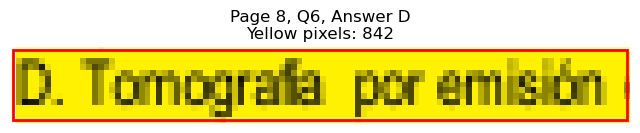

Page 8, Q6 - E: Detected box: x0=322.9, y0=458.6, x1=370.3, y1=470.6
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 234
Page 8, Q6, E: Yellow percentage: 0.0%


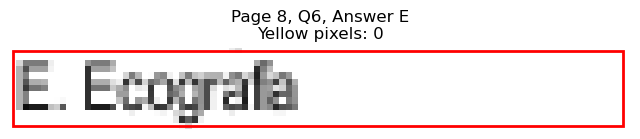


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=82.6, y0=519.4, x1=179.5, y1=531.4
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 483
Page 8, Q7, A: Yellow percentage: 0.0%


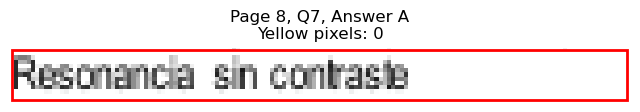

Page 8, Q7 - B: Detected box: x0=71.3, y0=531.4, x1=125.5, y1=543.5
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 500
Page 8, Q7, B: Yellow percentage: 0.0%


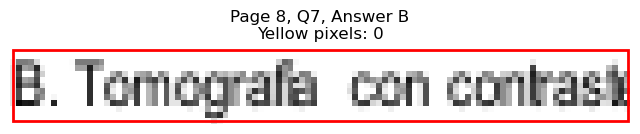

Page 8, Q7 - C: Detected box: x0=71.3, y0=543.4, x1=125.5, y1=555.5
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 517
Page 8, Q7, C: Yellow percentage: 0.0%


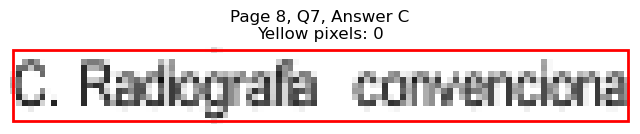

Page 8, Q7 - D: Detected box: x0=322.9, y0=519.4, x1=433.3, y1=531.4
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 539
Page 8, Q7, D: Yellow percentage: 0.0%


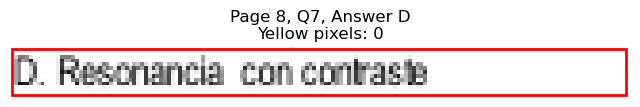

Page 8, Q7 - E: Detected box: x0=322.9, y0=531.4, x1=377.1, y1=543.5
Page 8, Q7, E: Yellow pixels: 938
Page 8, Q7, E: Total non-white pixels: 1365
Page 8, Q7, E: Yellow percentage: 68.7%


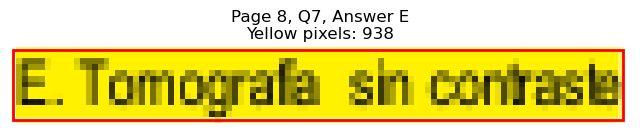


Page 8, Q7 - Selected Answer: E (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=82.6, y0=603.5, x1=145.0, y1=615.5
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 330
Page 8, Q8, A: Yellow percentage: 0.0%


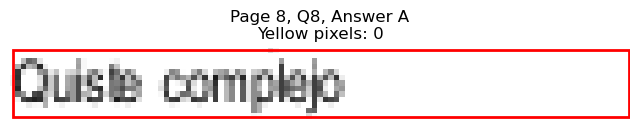

Page 8, Q8 - B: Detected box: x0=71.3, y0=615.5, x1=135.2, y1=627.5
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 326
Page 8, Q8, B: Yellow percentage: 0.0%


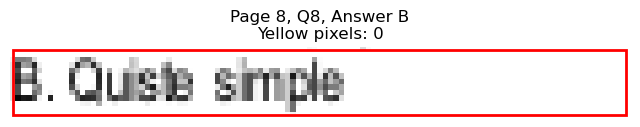

Page 8, Q8 - C: Detected box: x0=71.3, y0=627.5, x1=148.7, y1=639.6
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 364
Page 8, Q8, C: Yellow percentage: 0.0%


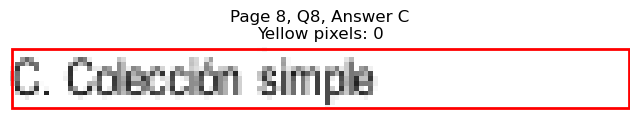

Page 8, Q8 - D: Detected box: x0=322.9, y0=603.5, x1=405.6, y1=615.5
Page 8, Q8, D: Yellow pixels: 720
Page 8, Q8, D: Total non-white pixels: 1066
Page 8, Q8, D: Yellow percentage: 67.5%


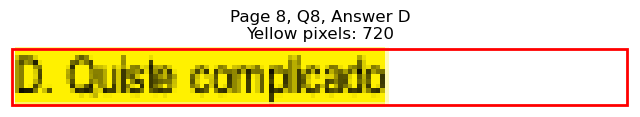

Page 8, Q8 - E: Detected box: x0=322.9, y0=615.5, x1=395.8, y1=627.5
Page 8, Q8, E: Yellow pixels: 80
Page 8, Q8, E: Total non-white pixels: 430
Page 8, Q8, E: Yellow percentage: 18.6%


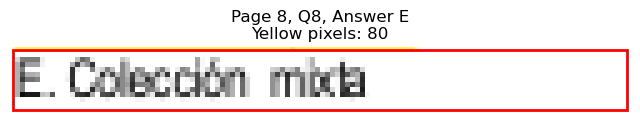


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=82.6, y0=700.3, x1=136.1, y1=712.3
Page 8, Q9, A: Yellow pixels: 400
Page 8, Q9, A: Total non-white pixels: 676
Page 8, Q9, A: Yellow percentage: 59.2%


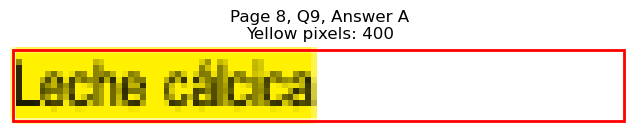

Page 8, Q9 - B: Detected box: x0=71.3, y0=712.3, x1=140.5, y1=724.4
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 379
Page 8, Q9, B: Yellow percentage: 0.0%


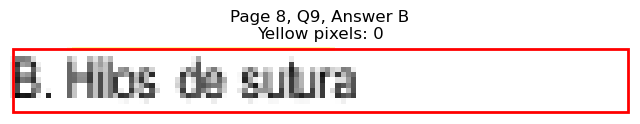

Page 8, Q9 - C: Detected box: x0=71.3, y0=724.3, x1=122.5, y1=736.4
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 238
Page 8, Q9, C: Yellow percentage: 0.0%


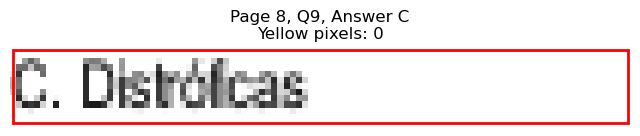

Page 8, Q9 - D: Detected box: x0=322.9, y0=700.3, x1=413.8, y1=712.3
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 461
Page 8, Q9, D: Yellow percentage: 0.0%


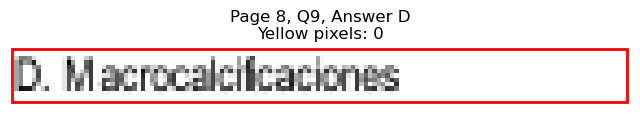

Page 8, Q9 - E: Detected box: x0=322.9, y0=712.3, x1=384.2, y1=724.4
Page 8, Q9, E: Yellow pixels: 0
Page 8, Q9, E: Total non-white pixels: 327
Page 8, Q9, E: Yellow percentage: 0.0%


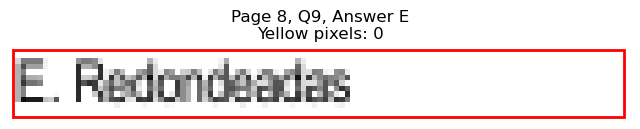


Page 8, Q9 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 11 questions
Page 9, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=109.0, y1=108.8
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 123
Page 9, Q1, A: Yellow percentage: 0.0%


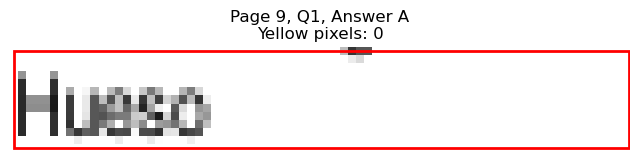

Page 9, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=112.8, y1=121.6
Page 9, Q1, B: Yellow pixels: 356
Page 9, Q1, B: Total non-white pixels: 520
Page 9, Q1, B: Yellow percentage: 68.5%


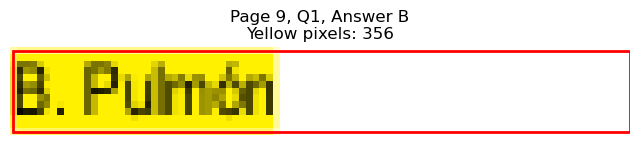

Page 9, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=110.5, y1=133.6
Page 9, Q1, C: Yellow pixels: 39
Page 9, Q1, C: Total non-white pixels: 213
Page 9, Q1, C: Yellow percentage: 18.3%


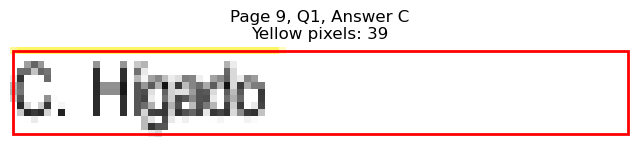

Page 9, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=380.0, y1=108.8
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 288
Page 9, Q1, D: Yellow percentage: 0.0%


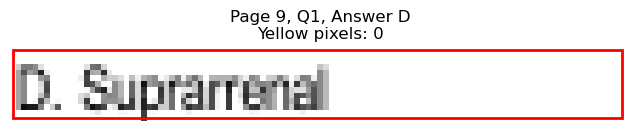

Page 9, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=371.8, y1=121.6
Page 9, Q1, E: Yellow pixels: 0
Page 9, Q1, E: Total non-white pixels: 227
Page 9, Q1, E: Yellow percentage: 0.0%


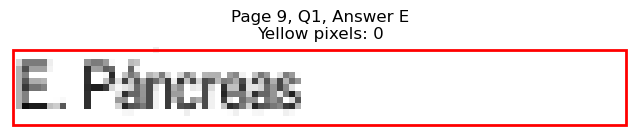


Page 9, Q1 - Selected Answer: B (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=121.0, y1=181.6
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 192
Page 9, Q2, A: Yellow percentage: 0.0%


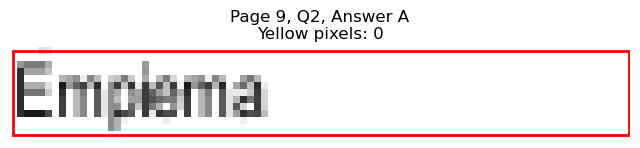

Page 9, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=124.7, y1=193.6
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 257
Page 9, Q2, B: Yellow percentage: 0.0%


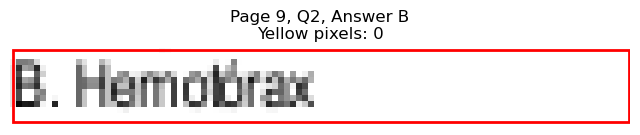

Page 9, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=122.5, y1=205.6
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 224
Page 9, Q2, C: Yellow percentage: 0.0%


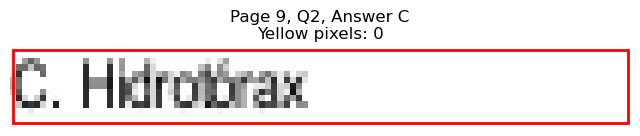

Page 9, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=375.5, y1=181.6
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 282
Page 9, Q2, D: Yellow percentage: 0.0%


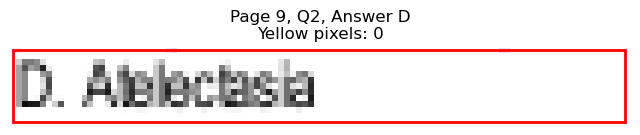

Page 9, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=368.8, y1=193.6
Page 9, Q2, E: Yellow pixels: 355
Page 9, Q2, E: Total non-white pixels: 585
Page 9, Q2, E: Yellow percentage: 60.7%


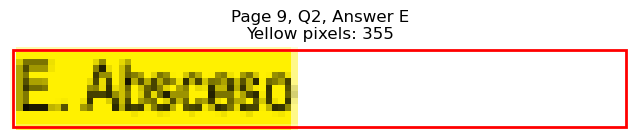


Page 9, Q2 - Selected Answer: E (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=82.6, y0=229.6, x1=158.6, y1=241.7
Page 9, Q3, A: Yellow pixels: 564
Page 9, Q3, A: Total non-white pixels: 977
Page 9, Q3, A: Yellow percentage: 57.7%


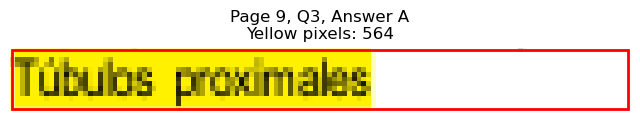

Page 9, Q3 - B: Detected box: x0=71.3, y0=241.6, x1=122.5, y1=253.7
Page 9, Q3, B: Yellow pixels: 73
Page 9, Q3, B: Total non-white pixels: 317
Page 9, Q3, B: Yellow percentage: 23.0%


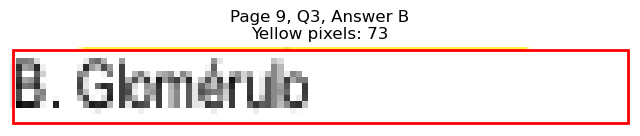

Page 9, Q3 - C: Detected box: x0=71.3, y0=253.6, x1=145.0, y1=265.7
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 358
Page 9, Q3, C: Yellow percentage: 0.0%


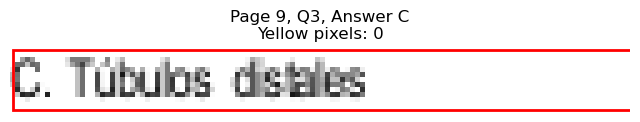

Page 9, Q3 - D: Detected box: x0=322.9, y0=229.6, x1=386.8, y1=241.7
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 300
Page 9, Q3, D: Yellow percentage: 0.0%


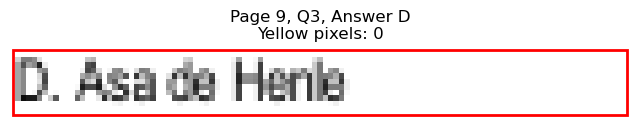

Page 9, Q3 - E: Detected box: x0=322.9, y0=241.6, x1=386.0, y1=253.7
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 290
Page 9, Q3, E: Yellow percentage: 0.0%


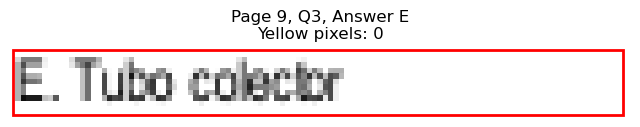


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.6, y0=289.7, x1=98.5, y1=301.8
Page 9, Q4, A: Yellow pixels: 101
Page 9, Q4, A: Total non-white pixels: 195
Page 9, Q4, A: Yellow percentage: 51.8%


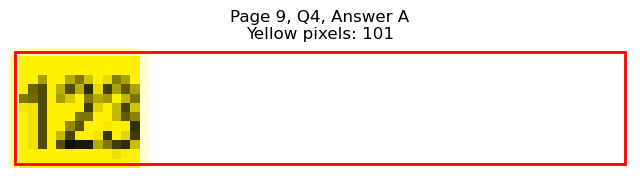

Page 9, Q4 - B: Detected box: x0=71.3, y0=302.5, x1=97.7, y1=314.5
Page 9, Q4, B: Yellow pixels: 13
Page 9, Q4, B: Total non-white pixels: 127
Page 9, Q4, B: Yellow percentage: 10.2%


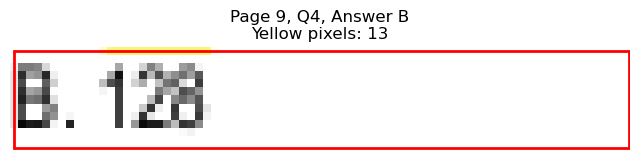

Page 9, Q4 - C: Detected box: x0=71.3, y0=314.5, x1=98.5, y1=326.5
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 103
Page 9, Q4, C: Yellow percentage: 0.0%


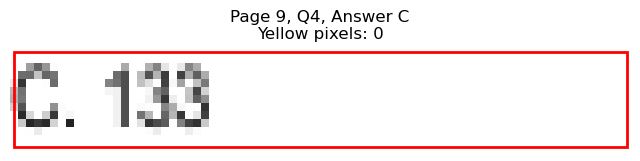

Page 9, Q4 - D: Detected box: x0=322.9, y0=289.7, x1=350.0, y1=301.8
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 120
Page 9, Q4, D: Yellow percentage: 0.0%


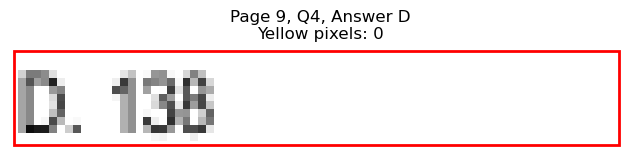

Page 9, Q4 - E: Detected box: x0=322.9, y0=302.5, x1=349.3, y1=314.5
Page 9, Q4, E: Yellow pixels: 0
Page 9, Q4, E: Total non-white pixels: 106
Page 9, Q4, E: Yellow percentage: 0.0%


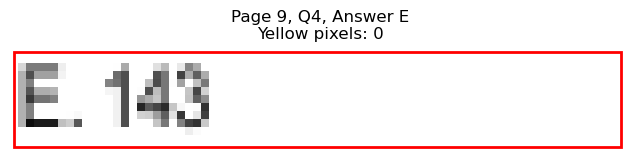


Page 9, Q4 - Selected Answer: A (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.6, y0=362.5, x1=139.0, y1=374.6
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 316
Page 9, Q5, A: Yellow percentage: 0.0%


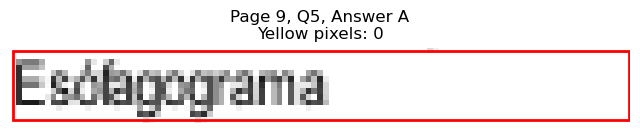

Page 9, Q5 - B: Detected box: x0=71.3, y0=374.5, x1=148.0, y1=386.6
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 377
Page 9, Q5, B: Yellow percentage: 0.0%


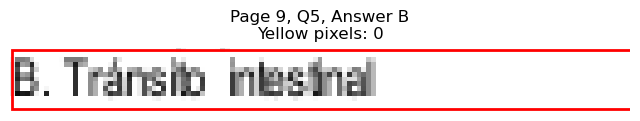

Page 9, Q5 - C: Detected box: x0=71.3, y0=386.5, x1=166.0, y1=398.6
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 441
Page 9, Q5, C: Yellow percentage: 0.0%


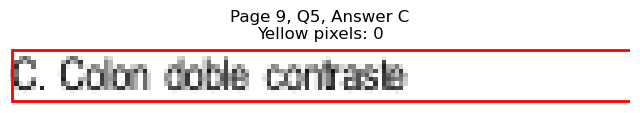

Page 9, Q5 - D: Detected box: x0=322.9, y0=362.5, x1=423.7, y1=374.6
Page 9, Q5, D: Yellow pixels: 830
Page 9, Q5, D: Total non-white pixels: 1300
Page 9, Q5, D: Yellow percentage: 63.8%


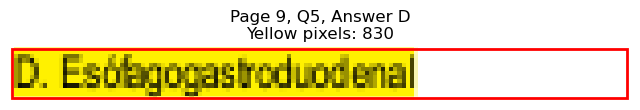

Page 9, Q5 - E: Detected box: x0=322.9, y0=374.5, x1=377.8, y1=386.6
Page 9, Q5, E: Yellow pixels: 98
Page 9, Q5, E: Total non-white pixels: 372
Page 9, Q5, E: Yellow percentage: 26.3%


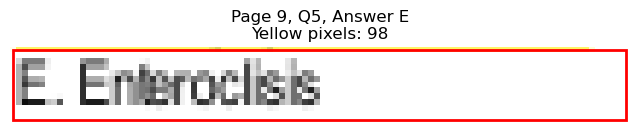


Page 9, Q5 - Selected Answer: D (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=82.6, y0=422.5, x1=122.5, y1=434.6
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 217
Page 9, Q6, A: Yellow percentage: 0.0%


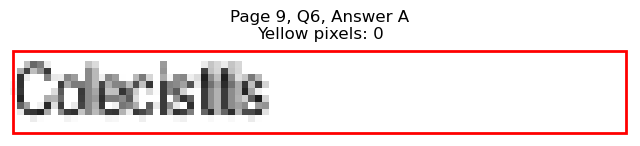

Page 9, Q6 - B: Detected box: x0=71.3, y0=434.6, x1=126.2, y1=446.6
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 280
Page 9, Q6, B: Yellow percentage: 0.0%


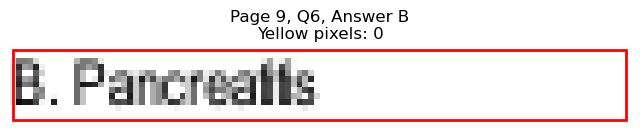

Page 9, Q6 - C: Detected box: x0=71.3, y0=446.6, x1=119.5, y1=458.6
Page 9, Q6, C: Yellow pixels: 350
Page 9, Q6, C: Total non-white pixels: 611
Page 9, Q6, C: Yellow percentage: 57.3%


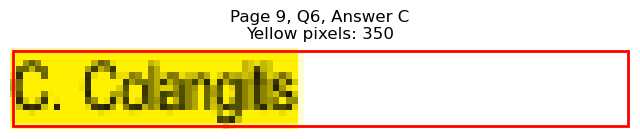

Page 9, Q6 - D: Detected box: x0=322.9, y0=422.5, x1=366.5, y1=434.6
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 230
Page 9, Q6, D: Yellow percentage: 0.0%


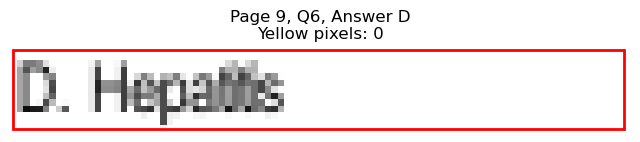

Page 9, Q6 - E: Detected box: x0=322.9, y0=434.6, x1=359.7, y1=446.6
Page 9, Q6, E: Yellow pixels: 0
Page 9, Q6, E: Total non-white pixels: 173
Page 9, Q6, E: Yellow percentage: 0.0%


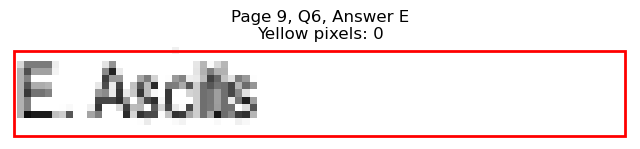


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.6, y0=483.4, x1=109.7, y1=495.4
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 130
Page 9, Q7, A: Yellow percentage: 0.0%


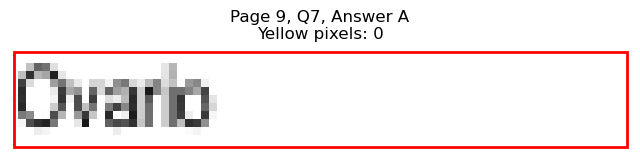

Page 9, Q7 - B: Detected box: x0=71.3, y0=495.4, x1=108.2, y1=507.4
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 167
Page 9, Q7, B: Yellow percentage: 0.0%


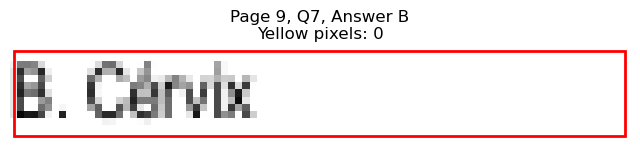

Page 9, Q7 - C: Detected box: x0=71.3, y0=507.4, x1=121.0, y1=519.4
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 220
Page 9, Q7, C: Yellow percentage: 0.0%


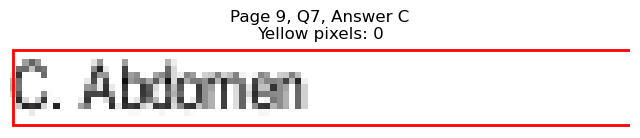

Page 9, Q7 - D: Detected box: x0=322.9, y0=483.4, x1=365.8, y1=495.4
Page 9, Q7, D: Yellow pixels: 373
Page 9, Q7, D: Total non-white pixels: 546
Page 9, Q7, D: Yellow percentage: 68.3%


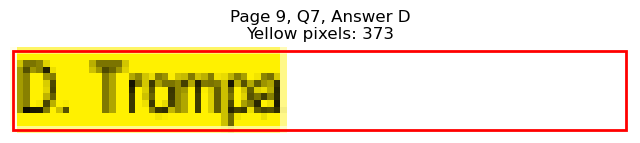

Page 9, Q7 - E: Detected box: x0=322.9, y0=495.4, x1=377.8, y1=507.4
Page 9, Q7, E: Yellow pixels: 40
Page 9, Q7, E: Total non-white pixels: 304
Page 9, Q7, E: Yellow percentage: 13.2%


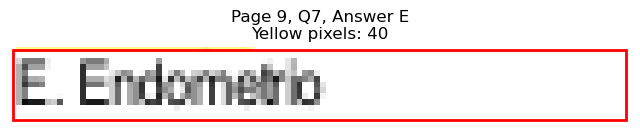


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=82.6, y0=555.4, x1=184.7, y1=567.5
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 502
Page 9, Q8, A: Yellow percentage: 0.0%


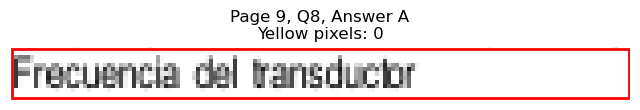

Page 9, Q8 - B: Detected box: x0=71.3, y0=567.5, x1=122.5, y1=579.5
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 239
Page 9, Q8, B: Yellow percentage: 0.0%


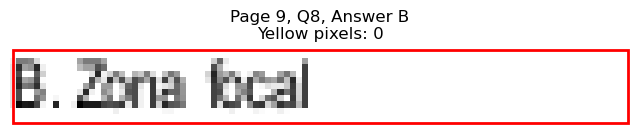

Page 9, Q8 - C: Detected box: x0=71.3, y0=579.4, x1=156.2, y1=591.5
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 404
Page 9, Q8, C: Yellow percentage: 0.0%


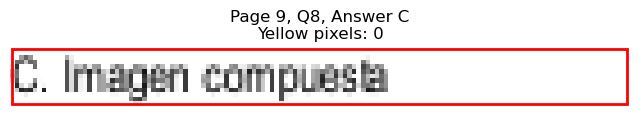

Page 9, Q8 - D: Detected box: x0=322.9, y0=555.4, x1=449.0, y1=567.5
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 611
Page 9, Q8, D: Yellow percentage: 0.0%


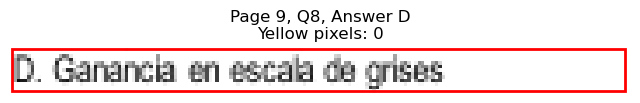

Page 9, Q8 - E: Detected box: x0=322.9, y0=567.5, x1=413.9, y1=579.5
Page 9, Q8, E: Yellow pixels: 799
Page 9, Q8, E: Total non-white pixels: 1172
Page 9, Q8, E: Yellow percentage: 68.2%


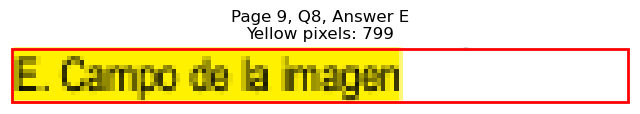


Page 9, Q8 - Selected Answer: E (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=82.6, y0=627.5, x1=204.4, y1=639.6
Page 9, Q9, A: Yellow pixels: 1042
Page 9, Q9, A: Total non-white pixels: 1562
Page 9, Q9, A: Yellow percentage: 66.7%


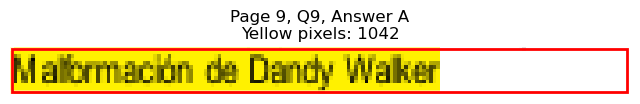

Page 9, Q9 - B: Detected box: x0=71.3, y0=639.5, x1=163.7, y1=651.6
Page 9, Q9, B: Yellow pixels: 119
Page 9, Q9, B: Total non-white pixels: 601
Page 9, Q9, B: Yellow percentage: 19.8%


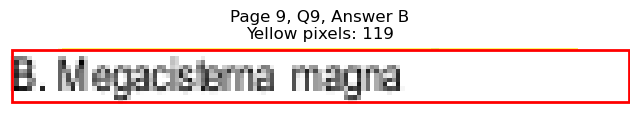

Page 9, Q9 - C: Detected box: x0=71.3, y0=651.5, x1=228.2, y1=663.6
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 760
Page 9, Q9, C: Yellow percentage: 0.0%


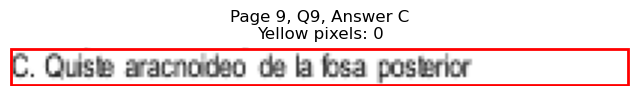

Page 9, Q9 - D: Detected box: x0=322.9, y0=627.5, x1=439.3, y1=639.6
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 574
Page 9, Q9, D: Yellow percentage: 0.0%


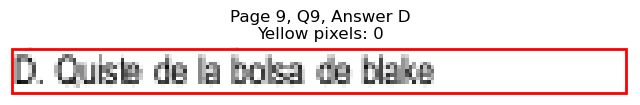

Page 9, Q9 - E: Detected box: x0=376.1, y0=639.5, x1=432.6, y1=651.6
Page 9, Q9, E: Yellow pixels: 0
Page 9, Q9, E: Total non-white pixels: 307
Page 9, Q9, E: Yellow percentage: 0.0%


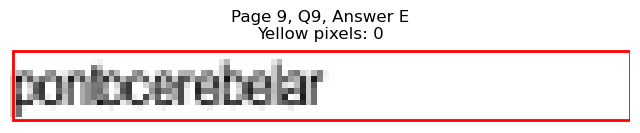


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=82.6, y0=688.3, x1=116.5, y1=700.3
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 132
Page 9, Q10, A: Yellow percentage: 0.0%


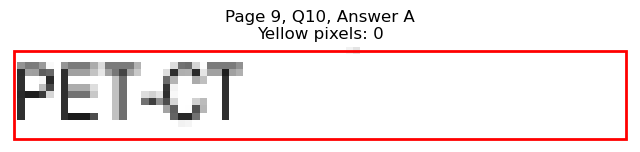

Page 9, Q10 - B: Detected box: x0=71.3, y0=700.3, x1=134.5, y1=712.3
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 323
Page 9, Q10, B: Yellow percentage: 0.0%


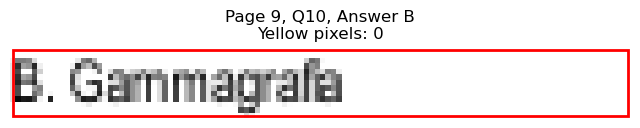

Page 9, Q10 - C: Detected box: x0=71.3, y0=712.3, x1=128.5, y1=724.4
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 269
Page 9, Q10, C: Yellow percentage: 0.0%


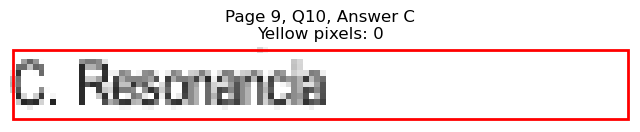

Page 9, Q10 - D: Detected box: x0=322.9, y0=688.3, x1=377.9, y1=700.3
Page 9, Q10, D: Yellow pixels: 414
Page 9, Q10, D: Total non-white pixels: 702
Page 9, Q10, D: Yellow percentage: 59.0%


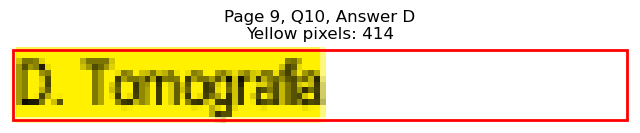

Page 9, Q10 - E: Detected box: x0=322.9, y0=700.3, x1=370.3, y1=712.3
Page 9, Q10, E: Yellow pixels: 2
Page 9, Q10, E: Total non-white pixels: 286
Page 9, Q10, E: Yellow percentage: 0.7%


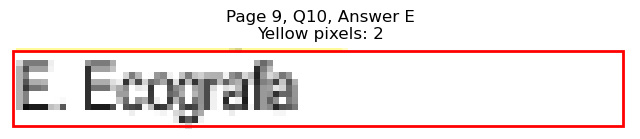


Page 9, Q10 - Selected Answer: D (based on yellow pixel count)




Page 9, Q11 - A: Detected box: x0=82.6, y0=748.4, x1=145.8, y1=760.4
Page 9, Q11, A: Yellow pixels: 0
Page 9, Q11, A: Total non-white pixels: 298
Page 9, Q11, A: Yellow percentage: 0.0%


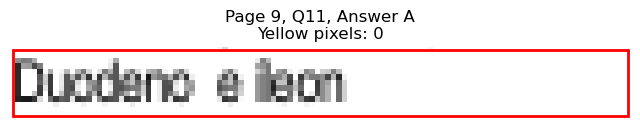

Page 9, Q11 - B: Detected box: x0=71.3, y0=760.4, x1=188.6, y1=772.4
Page 9, Q11, B: Yellow pixels: 1039
Page 9, Q11, B: Total non-white pixels: 1508
Page 9, Q11, B: Yellow percentage: 68.9%


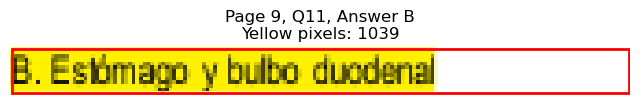

Page 9, Q11 - C: Detected box: x0=71.3, y0=772.4, x1=139.7, y1=784.4
Page 9, Q11, C: Yellow pixels: 114
Page 9, Q11, C: Total non-white pixels: 407
Page 9, Q11, C: Yellow percentage: 28.0%


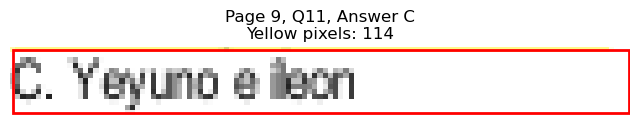

Page 9, Q11 - D: Detected box: x0=322.9, y0=748.4, x1=428.8, y1=760.4
Page 9, Q11, D: Yellow pixels: 0
Page 9, Q11, D: Total non-white pixels: 504
Page 9, Q11, D: Yellow percentage: 0.0%


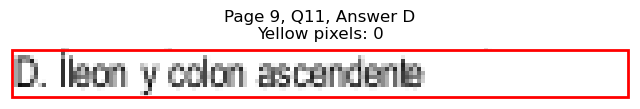

Page 9, Q11 - E: Detected box: x0=322.9, y0=760.4, x1=407.1, y1=772.4
Page 9, Q11, E: Yellow pixels: 0
Page 9, Q11, E: Total non-white pixels: 381
Page 9, Q11, E: Yellow percentage: 0.0%


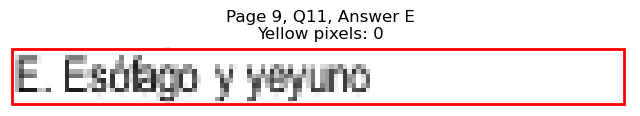


Page 9, Q11 - Selected Answer: B (based on yellow pixel count)





Page 10: Found 9 questions
Page 10, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=119.5, y1=121.6
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 200
Page 10, Q1, A: Yellow percentage: 0.0%


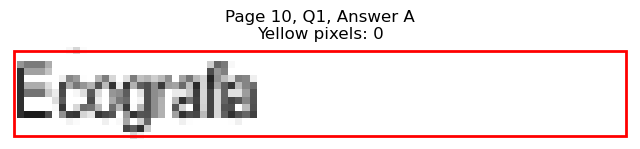

Page 10, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=125.5, y1=133.6
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 266
Page 10, Q1, B: Yellow percentage: 0.0%


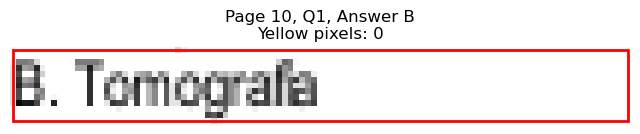

Page 10, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=128.5, y1=145.6
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 269
Page 10, Q1, C: Yellow percentage: 0.0%


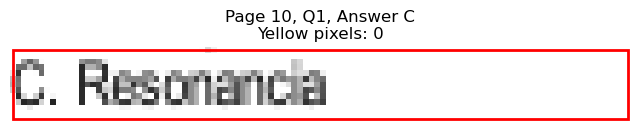

Page 10, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=366.6, y1=121.6
Page 10, Q1, D: Yellow pixels: 390
Page 10, Q1, D: Total non-white pixels: 559
Page 10, Q1, D: Yellow percentage: 69.8%


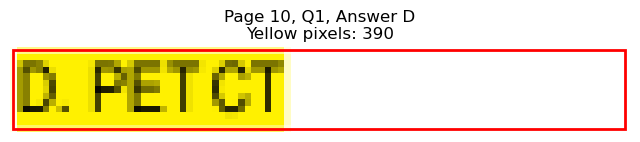

Page 10, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=408.5, y1=133.6
Page 10, Q1, E: Yellow pixels: 41
Page 10, Q1, E: Total non-white pixels: 466
Page 10, Q1, E: Yellow percentage: 8.8%


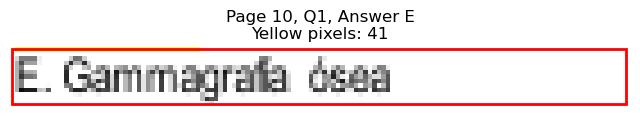


Page 10, Q1 - Selected Answer: D (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=112.0, y1=181.6
Page 10, Q2, A: Yellow pixels: 212
Page 10, Q2, A: Total non-white pixels: 364
Page 10, Q2, A: Yellow percentage: 58.2%


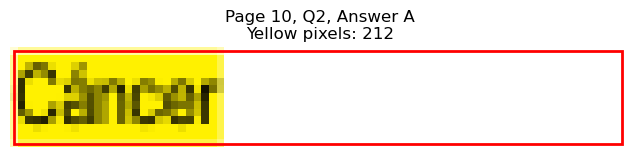

Page 10, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=121.7, y1=193.6
Page 10, Q2, B: Yellow pixels: 27
Page 10, Q2, B: Total non-white pixels: 282
Page 10, Q2, B: Yellow percentage: 9.6%


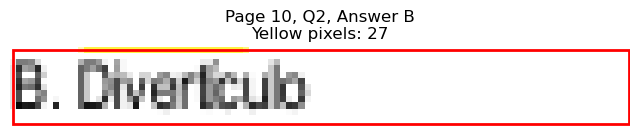

Page 10, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=107.5, y1=205.6
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 155
Page 10, Q2, C: Yellow percentage: 0.0%


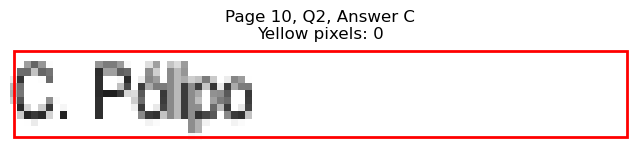

Page 10, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=372.5, y1=181.6
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 229
Page 10, Q2, D: Yellow percentage: 0.0%


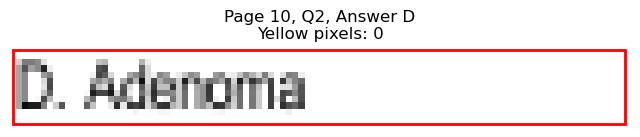

Page 10, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=362.8, y1=193.6
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 175
Page 10, Q2, E: Yellow percentage: 0.0%


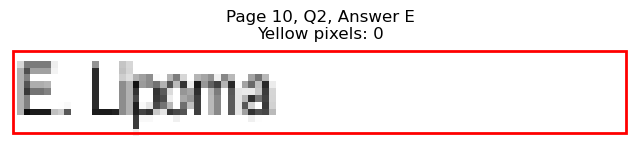


Page 10, Q2 - Selected Answer: A (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.6, y0=229.6, x1=122.5, y1=241.7
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 203
Page 10, Q3, A: Yellow percentage: 0.0%


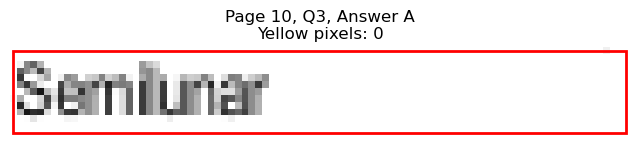

Page 10, Q3 - B: Detected box: x0=71.3, y0=241.6, x1=118.7, y1=253.7
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 245
Page 10, Q3, B: Yellow percentage: 0.0%


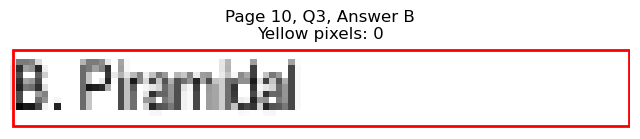

Page 10, Q3 - C: Detected box: x0=71.3, y0=253.6, x1=125.5, y1=265.7
Page 10, Q3, C: Yellow pixels: 408
Page 10, Q3, C: Total non-white pixels: 689
Page 10, Q3, C: Yellow percentage: 59.2%


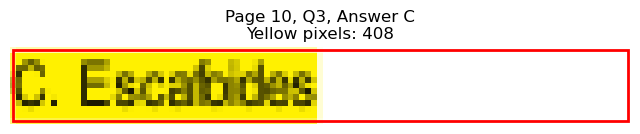

Page 10, Q3 - D: Detected box: x0=322.9, y0=229.6, x1=371.0, y1=241.7
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 234
Page 10, Q3, D: Yellow percentage: 0.0%


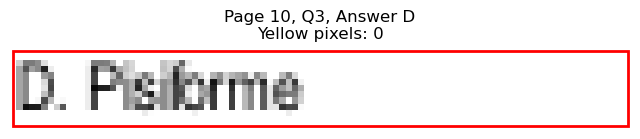

Page 10, Q3 - E: Detected box: x0=322.9, y0=241.6, x1=368.0, y1=253.7
Page 10, Q3, E: Yellow pixels: 0
Page 10, Q3, E: Total non-white pixels: 216
Page 10, Q3, E: Yellow percentage: 0.0%


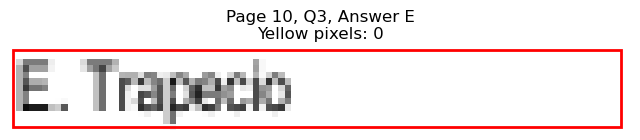


Page 10, Q3 - Selected Answer: C (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=82.6, y0=289.7, x1=126.2, y1=301.8
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 230
Page 10, Q4, A: Yellow percentage: 0.0%


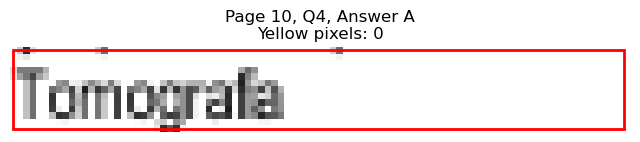

Page 10, Q4 - B: Detected box: x0=71.3, y0=302.5, x1=166.8, y1=314.5
Page 10, Q4, B: Yellow pixels: 823
Page 10, Q4, B: Total non-white pixels: 1222
Page 10, Q4, B: Yellow percentage: 67.3%


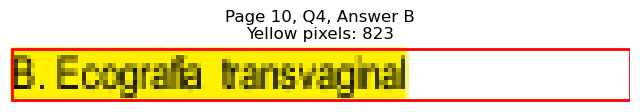

Page 10, Q4 - C: Detected box: x0=71.3, y0=314.5, x1=162.2, y1=326.5
Page 10, Q4, C: Yellow pixels: 92
Page 10, Q4, C: Total non-white pixels: 564
Page 10, Q4, C: Yellow percentage: 16.3%


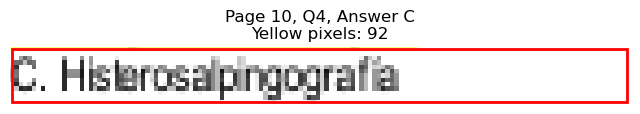

Page 10, Q4 - D: Detected box: x0=322.9, y0=289.7, x1=383.8, y1=301.8
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 311
Page 10, Q4, D: Yellow percentage: 0.0%


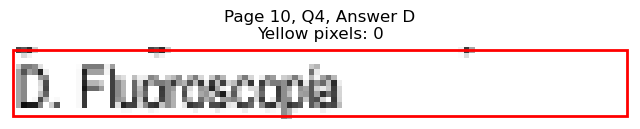

Page 10, Q4 - E: Detected box: x0=322.9, y0=302.5, x1=381.5, y1=314.5
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 262
Page 10, Q4, E: Yellow percentage: 0.0%


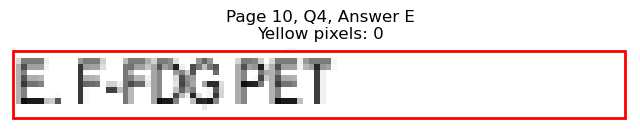


Page 10, Q4 - Selected Answer: B (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.6, y0=350.5, x1=125.5, y1=362.5
Page 10, Q5, A: Yellow pixels: 338
Page 10, Q5, A: Total non-white pixels: 547
Page 10, Q5, A: Yellow percentage: 61.8%


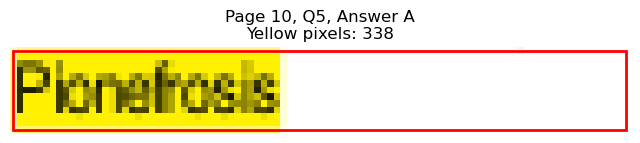

Page 10, Q5 - B: Detected box: x0=71.3, y0=362.5, x1=147.2, y1=374.6
Page 10, Q5, B: Yellow pixels: 40
Page 10, Q5, B: Total non-white pixels: 412
Page 10, Q5, B: Yellow percentage: 9.7%


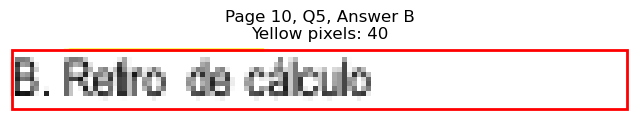

Page 10, Q5 - C: Detected box: x0=71.3, y0=374.5, x1=178.7, y1=386.6
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 664
Page 10, Q5, C: Yellow percentage: 0.0%


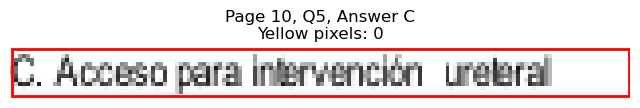

Page 10, Q5 - D: Detected box: x0=322.9, y0=350.5, x1=424.3, y1=362.5
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 477
Page 10, Q5, D: Yellow percentage: 0.0%


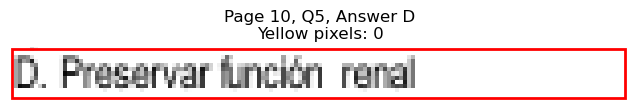

Page 10, Q5 - E: Detected box: x0=322.9, y0=362.5, x1=404.0, y1=374.6
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 395
Page 10, Q5, E: Yellow percentage: 0.0%


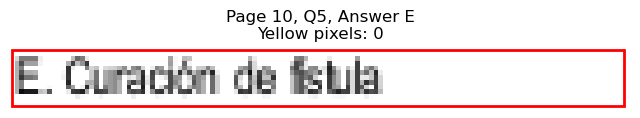


Page 10, Q5 - Selected Answer: A (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=82.6, y0=410.5, x1=197.5, y1=422.6
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 551
Page 10, Q6, A: Yellow percentage: 0.0%


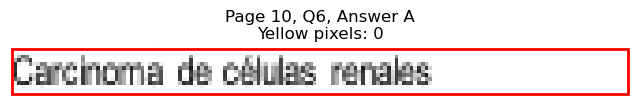

Page 10, Q6 - B: Detected box: x0=71.3, y0=422.5, x1=112.7, y1=434.6
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 187
Page 10, Q6, B: Yellow percentage: 0.0%


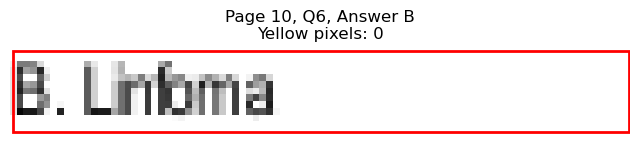

Page 10, Q6 - C: Detected box: x0=71.3, y0=434.6, x1=125.5, y1=446.6
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 230
Page 10, Q6, C: Yellow percentage: 0.0%


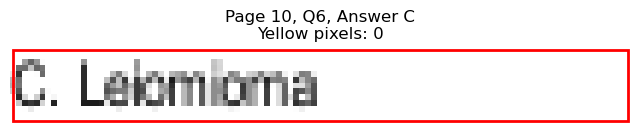

Page 10, Q6 - D: Detected box: x0=322.9, y0=410.5, x1=471.0, y1=422.6
Page 10, Q6, D: Yellow pixels: 1169
Page 10, Q6, D: Total non-white pixels: 1911
Page 10, Q6, D: Yellow percentage: 61.2%


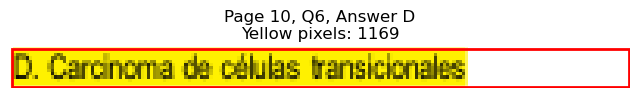

Page 10, Q6 - E: Detected box: x0=322.9, y0=422.5, x1=380.0, y1=434.6
Page 10, Q6, E: Yellow pixels: 108
Page 10, Q6, E: Total non-white pixels: 381
Page 10, Q6, E: Yellow percentage: 28.3%


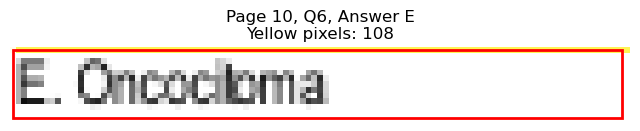


Page 10, Q6 - Selected Answer: D (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=82.6, y0=470.6, x1=109.0, y1=482.6
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 133
Page 10, Q7, A: Yellow percentage: 0.0%


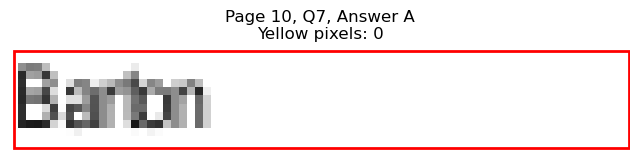

Page 10, Q7 - B: Detected box: x0=71.3, y0=483.4, x1=111.2, y1=495.4
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 200
Page 10, Q7, B: Yellow percentage: 0.0%


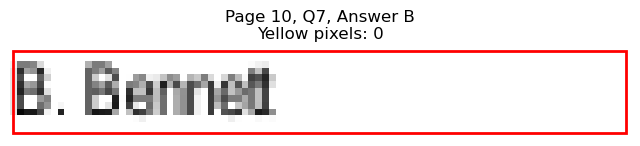

Page 10, Q7 - C: Detected box: x0=71.3, y0=495.4, x1=115.7, y1=507.4
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 204
Page 10, Q7, C: Yellow percentage: 0.0%


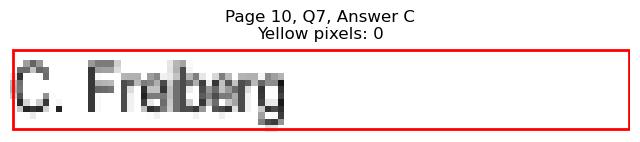

Page 10, Q7 - D: Detected box: x0=322.9, y0=470.6, x1=359.1, y1=482.6
Page 10, Q7, D: Yellow pixels: 283
Page 10, Q7, D: Total non-white pixels: 455
Page 10, Q7, D: Yellow percentage: 62.2%


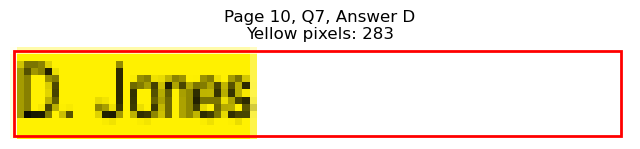

Page 10, Q7 - E: Detected box: x0=322.9, y0=483.4, x1=364.3, y1=495.4
Page 10, Q7, E: Yellow pixels: 33
Page 10, Q7, E: Total non-white pixels: 238
Page 10, Q7, E: Yellow percentage: 13.9%


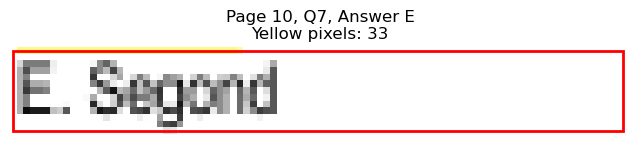


Page 10, Q7 - Selected Answer: D (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=82.6, y0=555.4, x1=125.5, y1=567.5
Page 10, Q8, A: Yellow pixels: 351
Page 10, Q8, A: Total non-white pixels: 549
Page 10, Q8, A: Yellow percentage: 63.9%


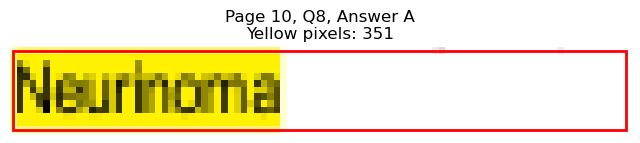

Page 10, Q8 - B: Detected box: x0=71.3, y0=567.5, x1=130.0, y1=579.5
Page 10, Q8, B: Yellow pixels: 40
Page 10, Q8, B: Total non-white pixels: 345
Page 10, Q8, B: Yellow percentage: 11.6%


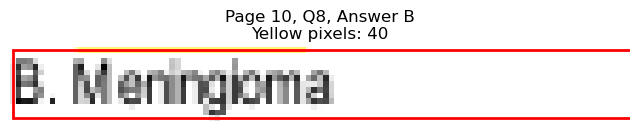

Page 10, Q8 - C: Detected box: x0=71.3, y0=579.4, x1=134.5, y1=591.5
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 292
Page 10, Q8, C: Yellow percentage: 0.0%


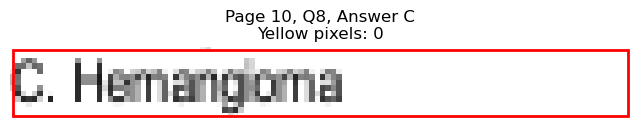

Page 10, Q8 - D: Detected box: x0=322.9, y0=555.4, x1=396.5, y1=567.5
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 345
Page 10, Q8, D: Yellow percentage: 0.0%


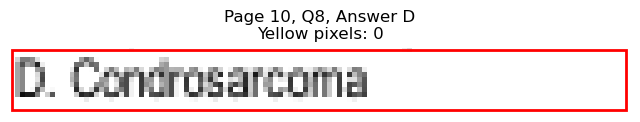

Page 10, Q8 - E: Detected box: x0=322.9, y0=567.5, x1=377.0, y1=579.5
Page 10, Q8, E: Yellow pixels: 0
Page 10, Q8, E: Total non-white pixels: 263
Page 10, Q8, E: Yellow percentage: 0.0%


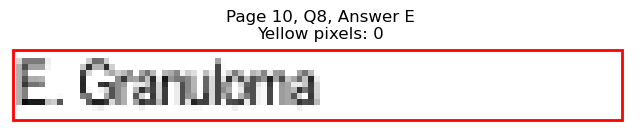


Page 10, Q8 - Selected Answer: A (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=132.1, y0=639.5, x1=178.1, y1=651.6
Page 10, Q9, A: Yellow pixels: 372
Page 10, Q9, A: Total non-white pixels: 572
Page 10, Q9, A: Yellow percentage: 65.0%


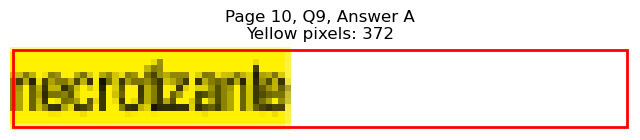

Page 10, Q9 - B: Detected box: x0=71.3, y0=651.5, x1=157.7, y1=663.6
Page 10, Q9, B: Yellow pixels: 93
Page 10, Q9, B: Total non-white pixels: 508
Page 10, Q9, B: Yellow percentage: 18.3%


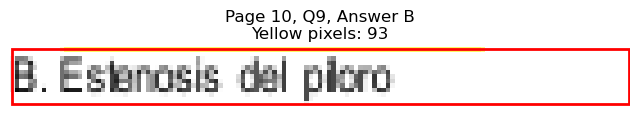

Page 10, Q9 - C: Detected box: x0=71.3, y0=663.5, x1=122.5, y1=675.6
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 437
Page 10, Q9, C: Yellow percentage: 0.0%


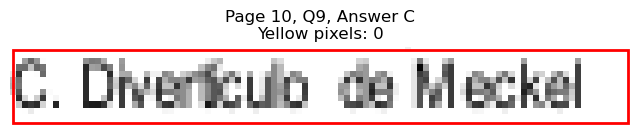

Page 10, Q9 - D: Detected box: x0=322.9, y0=639.5, x1=397.3, y1=651.6
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 369
Page 10, Q9, D: Yellow percentage: 0.0%


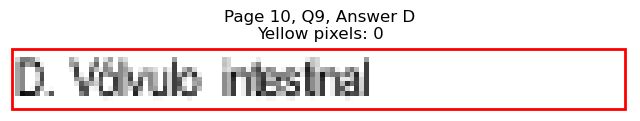

Page 10, Q9 - E: Detected box: x0=322.9, y0=651.5, x1=390.6, y1=663.6
Page 10, Q9, E: Yellow pixels: 0
Page 10, Q9, E: Total non-white pixels: 331
Page 10, Q9, E: Yellow percentage: 0.0%


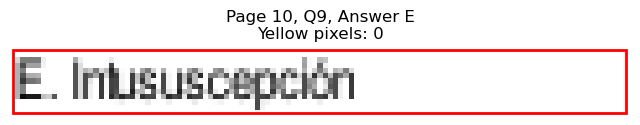


Page 10, Q9 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Mujer de 30 años, sin antecedente familiar par...
1   ¿Cuántas semanas se recomienda mantener un cat...
2   ¿En qué patología vascular, se encuentra el si...
3   ¿Cuál es el signo ecográfico característico de...
4   ¿Cuál es el comportamiento de señal en Resonan...
..                                                ...
95  ¿Cuál es la indicación para realizar una nefro...
96  ¿Cuál es el tipo de tumor pielocalicial renal ...
97  ¿Cuál es el nombre de la fractura transversa d...
98  Varón de 40 años, con hipoacusia neurosensoria...
99  Lactante prematuro presenta distensión abdomin...

[100 rows x 1 columns]

In [8]:
answers_df

option_A                          option_B  \
0                              5                                 1   
1                            4-6                              8-10   
2           Hemangioma cavernoso                  Malformación A-V   
3              Cálculos biliares  Engrosamiento de pared vesicular   
4        Hiperintensa en T1 y T2            Hipointensa en T1 y T2   
..                           ...                               ...   
95                   Pionefrosis                 Retiro de cálculo   
96  Carcinoma de células renales                           Linfoma   
97                        Barton                           Bennett   
98                     Neurinoma                        Meningioma   
99    Enterocolitis necrotizante              Estenosis del píloro   

                                 option_C  \
0                                       3   
1                                   12-15   
2                               Aneurisma   
3                    Distensión vesicular   
4   Intermedia en T1 , hiperintensa en T2   
..                                    ...   
95      Acceso para intervención ureteral   
96                              Leiomioma   
97                               Freiberg   
98                             Hemangioma   
99                  Divertículo de Meckel   

                               option_D  \
0                                     4   
1                                  1- 2   
2                        Angioma venoso   
3                     Murphy ecográfico   
4   Intermedia en T1, hipointensa en T2   
..                                  ...   
95              Preservar función renal   
96  Carcinoma de células transicionales   
97                                Jones   
98                        Condrosarcoma   
99                   Vólvulo intestinal   

                                  option_E  
0                                        6  
1                                      2-3  
2                                Trombosis  
3                   Gas en pared vesicular  
4   Hipointensa en T1 e hiperintensa en T2  
..                                     ...  
95                     Curación de fístula  
96                              Oncocitoma  
97                                  Segond  
98                               Granuloma  
99                          Intususcepción  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               C
1               A
2               D
3               E
4               D
..            ...
95              A
96              D
97              D
98              A
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   Mujer de 30 años, sin antecedente familiar par...   
1   ¿Cuántas semanas se recomienda mantener un cat...   
2   ¿En qué patología vascular, se encuentra el si...   
3   ¿Cuál es el signo ecográfico característico de...   
4   ¿Cuál es el comportamiento de señal en Resonan...   
..                                                ...   
95  ¿Cuál es la indicación para realizar una nefro...   
96  ¿Cuál es el tipo de tumor pielocalicial renal ...   
97  ¿Cuál es el nombre de la fractura transversa d...   
98  Varón de 40 años, con hipoacusia neurosensoria...   
99  Lactante prematuro presenta distensión abdomin...   

                        option_A                          option_B  \
0                              5                                 1   
1                            4-6                              8-10   
2           Hemangioma cavernoso                  Malformación A-V   
3              Cálculos biliares  Engrosamiento de pared vesicular   
4        Hiperintensa en T1 y T2            Hipointensa en T1 y T2   
..                           ...                               ...   
95                   Pionefrosis                 Retiro de cálculo   
96  Carcinoma de células renales                           Linfoma   
97                        Barton                           Bennett   
98                     Neurinoma                        Meningioma   
99    Enterocolitis necrotizante              Estenosis del píloro   

                                 option_C  \
0                                       3   
1                                   12-15   
2                               Aneurisma   
3                    Distensión vesicular   
4   Intermedia en T1 , hiperintensa en T2   
..                                    ...   
95      Acceso para intervención ureteral   
96                              Leiomioma   
97                               Freiberg   
98                             Hemangioma   
99                  Divertículo de Meckel   

                               option_D  \
0                                     4   
1                                  1- 2   
2                        Angioma venoso   
3                     Murphy ecográfico   
4   Intermedia en T1, hipointensa en T2   
..                                  ...   
95              Preservar función renal   
96  Carcinoma de células transicionales   
97                                Jones   
98                        Condrosarcoma   
99                   Vólvulo intestinal   

                                  option_E correct_answer  
0                                        6              C  
1                                      2-3              A  
2                                Trombosis              D  
3                   Gas en pared vesicular              E  
4   Hipointensa en T1 e hiperintensa en T2              D  
..                                     ...            ...  
95                     Curación de fístula              A  
96                              Oncocitoma              D  
97                                  Segond              D  
98                               Granuloma              A  
99                          Intususcepción              A  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/RADIOLOGIA.csv
